# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 800
lr = 0.5e-6
batch_size = 10
num_workers = 1

### Create Model

### Handle GPU

In [5]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:3')
    
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:3 dtype <class 'torch.cuda.FloatTensor'>


### Handle loss function and optimizer

### Track stats

### Load data

In [6]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [7]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [9]:
best_acc_list = []

drop_prob_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.0]
num_tests = len(drop_prob_list)

results = np.zeros(shape=(num_tests, num_epoch, 2, 2))

### Train !

In [11]:
for test_num, drop_prob in enumerate(drop_prob_list):
    print()
    model = resnet18(drop_prob=drop_prob)
    model = model.to(device)
    
    crit = torch.nn.CrossEntropyLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

    stats = np.zeros(shape=(num_epoch, 2, 2))

    # indices
    train = 0
    test  = 1
    acc   = 0
    loss  = 1


    train_ds = har_dataset(train_data, train_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers)
    train_batches = train_dl.__len__()

    test_ds = har_dataset(test_data, test_labels)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
    test_batches = test_dl.__len__()

    best_acc = 0
    tstart = time.time()
    for epoch in range(num_epoch):

        # switch to train mode
        model.train()

        # track accuracy
        total = 0
        correct = 0

        # track loss
        tr_loss = []
        for batch, data in enumerate(train_dl):
            print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')

            # extract signal and labels
            signals, labels = data

            ## Normalize?

            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)

            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)

            # process signals
            out = model(signals)

            # hard decision for classification
            _, pred = torch.max(out.data, 1)

    #         print(pred)
    #         print(labels)
    #         print()

            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()

            # compute loss
            b_loss = crit(out, labels)
            opt.zero_grad()
            b_loss.backward()
            opt.step()

            tr_loss.append(b_loss.item())

        # epoch training stats
        tr_accuracy = 100. * correct / total
        tr_loss = np.mean(tr_loss)

        # evaluate model
        model.eval()

        ts_loss = []
        total   = 0
        correct = 0
        with torch.no_grad():
            for batch, data in enumerate(test_dl):
                print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')

                # extract signals and labels
                signals, labels = data

                # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
                signals = signals.transpose(1,2)

                # move data to device
                signals = signals.to(device)
                labels = labels.type(ltype).to(device)

                # process signals
                out = model(signals)

                # hard decision for classification
                _, pred = torch.max(out.data, 1)

                # compute accuracy
                total   += labels.size(0)
                correct += (pred == labels).sum().item()

                # compute loss
                b_loss = crit(out, labels)

                ts_loss.append(b_loss.item())
    
        # epoch testing stats
        ts_accuracy = 100. * correct / total
        ts_loss = np.mean(ts_loss)

        if ts_accuracy > best_acc:
            best_acc = ts_accuracy
            
        # save stats to plot later
        stats[epoch, train, loss ] = tr_loss
        stats[epoch, train, acc  ] = tr_accuracy
        stats[epoch, test,  loss ] = ts_loss
        stats[epoch, test,  acc  ] = ts_accuracy

        t1 = time.time() - tstart
        print('Epoch: {0:4d} Tr loss: {1:.6f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s Dprob {6:.3f}'.format(
                epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1, drop_prob))
    
    # save results of each model to plot
    results[test_num,:,:,:] = stats
    best_acc_list.append(best_acc)
    
np.savez('dropout_test',res=results)


Epoch:    1 Tr loss: 3.091764 Ts loss: 2.748 Tr Accuracy: 6.19% Ts Accuracy: 7.92% Time: 2.94s Dprob 0.050
Epoch:    2 Tr loss: 2.772189 Ts loss: 2.567 Tr Accuracy: 11.45% Ts Accuracy: 11.14% Time: 5.28s Dprob 0.050
Epoch:    3 Tr loss: 2.551651 Ts loss: 2.417 Tr Accuracy: 14.55% Ts Accuracy: 17.60% Time: 7.93s Dprob 0.050
Epoch:    4 Tr loss: 2.400956 Ts loss: 2.306 Tr Accuracy: 16.49% Ts Accuracy: 19.65% Time: 10.24s Dprob 0.050
Epoch:    5 Tr loss: 2.275176 Ts loss: 2.213 Tr Accuracy: 17.41% Ts Accuracy: 24.63% Time: 13.33s Dprob 0.050
Epoch:    6 Tr loss: 2.204135 Ts loss: 2.134 Tr Accuracy: 22.45% Ts Accuracy: 27.57% Time: 15.82s Dprob 0.050
Epoch:    7 Tr loss: 2.100070 Ts loss: 2.072 Tr Accuracy: 22.11% Ts Accuracy: 28.74% Time: 18.12s Dprob 0.050
Epoch:    8 Tr loss: 2.024434 Ts loss: 2.007 Tr Accuracy: 22.57% Ts Accuracy: 33.14% Time: 20.89s Dprob 0.050
Epoch:    9 Tr loss: 1.963796 Ts loss: 1.963 Tr Accuracy: 28.75% Ts Accuracy: 37.24% Time: 23.40s Dprob 0.050
Epoch:   10 Tr

Epoch:   75 Tr loss: 0.773982 Ts loss: 0.893 Tr Accuracy: 75.83% Ts Accuracy: 72.14% Time: 198.54s Dprob 0.050
Epoch:   76 Tr loss: 0.764621 Ts loss: 0.887 Tr Accuracy: 75.83% Ts Accuracy: 73.02% Time: 201.85s Dprob 0.050
Epoch:   77 Tr loss: 0.742912 Ts loss: 0.876 Tr Accuracy: 78.58% Ts Accuracy: 72.73% Time: 205.45s Dprob 0.050
Epoch:   78 Tr loss: 0.740853 Ts loss: 0.863 Tr Accuracy: 77.78% Ts Accuracy: 73.31% Time: 208.95s Dprob 0.050
Epoch:   79 Tr loss: 0.728827 Ts loss: 0.861 Tr Accuracy: 78.12% Ts Accuracy: 74.78% Time: 212.43s Dprob 0.050
Epoch:   80 Tr loss: 0.726017 Ts loss: 0.858 Tr Accuracy: 78.01% Ts Accuracy: 73.90% Time: 215.77s Dprob 0.050
Epoch:   81 Tr loss: 0.723323 Ts loss: 0.851 Tr Accuracy: 77.09% Ts Accuracy: 74.19% Time: 219.01s Dprob 0.050
Epoch:   82 Tr loss: 0.721911 Ts loss: 0.839 Tr Accuracy: 79.04% Ts Accuracy: 75.07% Time: 222.30s Dprob 0.050
Epoch:   83 Tr loss: 0.722968 Ts loss: 0.836 Tr Accuracy: 77.89% Ts Accuracy: 74.19% Time: 225.47s Dprob 0.050
E

Epoch:  149 Tr loss: 0.397005 Ts loss: 0.570 Tr Accuracy: 89.00% Ts Accuracy: 81.82% Time: 446.70s Dprob 0.050
Epoch:  150 Tr loss: 0.401229 Ts loss: 0.564 Tr Accuracy: 88.20% Ts Accuracy: 80.94% Time: 450.43s Dprob 0.050
Epoch:  151 Tr loss: 0.393792 Ts loss: 0.563 Tr Accuracy: 88.32% Ts Accuracy: 81.52% Time: 453.69s Dprob 0.050
Epoch:  152 Tr loss: 0.402008 Ts loss: 0.560 Tr Accuracy: 87.06% Ts Accuracy: 81.23% Time: 457.04s Dprob 0.050
Epoch:  153 Tr loss: 0.399355 Ts loss: 0.560 Tr Accuracy: 87.74% Ts Accuracy: 80.94% Time: 460.59s Dprob 0.050
Epoch:  154 Tr loss: 0.382964 Ts loss: 0.558 Tr Accuracy: 88.20% Ts Accuracy: 81.52% Time: 464.16s Dprob 0.050
Epoch:  155 Tr loss: 0.382307 Ts loss: 0.554 Tr Accuracy: 88.77% Ts Accuracy: 82.11% Time: 467.57s Dprob 0.050
Epoch:  156 Tr loss: 0.391404 Ts loss: 0.551 Tr Accuracy: 87.51% Ts Accuracy: 81.52% Time: 470.80s Dprob 0.050
Epoch:  157 Tr loss: 0.373229 Ts loss: 0.552 Tr Accuracy: 89.23% Ts Accuracy: 81.52% Time: 474.05s Dprob 0.050
E

Epoch:  223 Tr loss: 0.245502 Ts loss: 0.448 Tr Accuracy: 93.13% Ts Accuracy: 82.99% Time: 701.62s Dprob 0.050
Epoch:  224 Tr loss: 0.241221 Ts loss: 0.445 Tr Accuracy: 93.70% Ts Accuracy: 82.99% Time: 705.03s Dprob 0.050
Epoch:  225 Tr loss: 0.236365 Ts loss: 0.448 Tr Accuracy: 93.36% Ts Accuracy: 82.99% Time: 708.66s Dprob 0.050
Epoch:  226 Tr loss: 0.235666 Ts loss: 0.447 Tr Accuracy: 93.47% Ts Accuracy: 82.99% Time: 711.84s Dprob 0.050
Epoch:  227 Tr loss: 0.238975 Ts loss: 0.447 Tr Accuracy: 92.67% Ts Accuracy: 82.70% Time: 715.01s Dprob 0.050
Epoch:  228 Tr loss: 0.233559 Ts loss: 0.441 Tr Accuracy: 93.47% Ts Accuracy: 82.99% Time: 718.39s Dprob 0.050
Epoch:  229 Tr loss: 0.223549 Ts loss: 0.445 Tr Accuracy: 94.62% Ts Accuracy: 82.70% Time: 721.91s Dprob 0.050
Epoch:  230 Tr loss: 0.238036 Ts loss: 0.440 Tr Accuracy: 93.81% Ts Accuracy: 82.99% Time: 724.97s Dprob 0.050
Epoch:  231 Tr loss: 0.224332 Ts loss: 0.440 Tr Accuracy: 94.16% Ts Accuracy: 83.28% Time: 728.69s Dprob 0.050
E

Epoch:  297 Tr loss: 0.155754 Ts loss: 0.406 Tr Accuracy: 96.11% Ts Accuracy: 83.87% Time: 950.20s Dprob 0.050
Epoch:  298 Tr loss: 0.153301 Ts loss: 0.408 Tr Accuracy: 96.11% Ts Accuracy: 83.58% Time: 953.79s Dprob 0.050
Epoch:  299 Tr loss: 0.159548 Ts loss: 0.408 Tr Accuracy: 95.88% Ts Accuracy: 83.58% Time: 957.03s Dprob 0.050
Epoch:  300 Tr loss: 0.162275 Ts loss: 0.408 Tr Accuracy: 95.07% Ts Accuracy: 83.58% Time: 960.00s Dprob 0.050
Epoch:  301 Tr loss: 0.154454 Ts loss: 0.402 Tr Accuracy: 95.65% Ts Accuracy: 83.87% Time: 963.07s Dprob 0.050
Epoch:  302 Tr loss: 0.150938 Ts loss: 0.404 Tr Accuracy: 94.96% Ts Accuracy: 83.87% Time: 966.88s Dprob 0.050
Epoch:  303 Tr loss: 0.152537 Ts loss: 0.399 Tr Accuracy: 95.30% Ts Accuracy: 83.87% Time: 970.05s Dprob 0.050
Epoch:  304 Tr loss: 0.160372 Ts loss: 0.402 Tr Accuracy: 95.88% Ts Accuracy: 84.46% Time: 973.69s Dprob 0.050
Epoch:  305 Tr loss: 0.157619 Ts loss: 0.398 Tr Accuracy: 96.11% Ts Accuracy: 84.46% Time: 976.80s Dprob 0.050
E

Epoch:  370 Tr loss: 0.107450 Ts loss: 0.405 Tr Accuracy: 97.59% Ts Accuracy: 85.63% Time: 1195.74s Dprob 0.050
Epoch:  371 Tr loss: 0.099405 Ts loss: 0.410 Tr Accuracy: 98.28% Ts Accuracy: 84.75% Time: 1198.76s Dprob 0.050
Epoch:  372 Tr loss: 0.110933 Ts loss: 0.407 Tr Accuracy: 97.02% Ts Accuracy: 85.63% Time: 1201.99s Dprob 0.050
Epoch:  373 Tr loss: 0.109911 Ts loss: 0.409 Tr Accuracy: 97.71% Ts Accuracy: 85.63% Time: 1205.33s Dprob 0.050
Epoch:  374 Tr loss: 0.099156 Ts loss: 0.402 Tr Accuracy: 98.05% Ts Accuracy: 85.63% Time: 1209.02s Dprob 0.050
Epoch:  375 Tr loss: 0.110529 Ts loss: 0.409 Tr Accuracy: 97.25% Ts Accuracy: 85.63% Time: 1212.87s Dprob 0.050
Epoch:  376 Tr loss: 0.101717 Ts loss: 0.408 Tr Accuracy: 97.48% Ts Accuracy: 85.34% Time: 1215.89s Dprob 0.050
Epoch:  377 Tr loss: 0.098780 Ts loss: 0.407 Tr Accuracy: 98.28% Ts Accuracy: 85.34% Time: 1219.75s Dprob 0.050
Epoch:  378 Tr loss: 0.101971 Ts loss: 0.412 Tr Accuracy: 97.94% Ts Accuracy: 85.34% Time: 1223.25s Dpro

Epoch:  443 Tr loss: 0.070728 Ts loss: 0.443 Tr Accuracy: 99.08% Ts Accuracy: 85.63% Time: 1443.56s Dprob 0.050
Epoch:  444 Tr loss: 0.067986 Ts loss: 0.428 Tr Accuracy: 99.20% Ts Accuracy: 85.92% Time: 1446.51s Dprob 0.050
Epoch:  445 Tr loss: 0.073587 Ts loss: 0.435 Tr Accuracy: 98.85% Ts Accuracy: 85.92% Time: 1450.42s Dprob 0.050
Epoch:  446 Tr loss: 0.074122 Ts loss: 0.436 Tr Accuracy: 98.51% Ts Accuracy: 85.92% Time: 1453.78s Dprob 0.050
Epoch:  447 Tr loss: 0.072008 Ts loss: 0.436 Tr Accuracy: 98.85% Ts Accuracy: 85.92% Time: 1456.73s Dprob 0.050
Epoch:  448 Tr loss: 0.069297 Ts loss: 0.433 Tr Accuracy: 98.85% Ts Accuracy: 85.92% Time: 1460.08s Dprob 0.050
Epoch:  449 Tr loss: 0.071967 Ts loss: 0.442 Tr Accuracy: 98.85% Ts Accuracy: 85.92% Time: 1463.64s Dprob 0.050
Epoch:  450 Tr loss: 0.070510 Ts loss: 0.430 Tr Accuracy: 98.63% Ts Accuracy: 85.92% Time: 1467.13s Dprob 0.050
Epoch:  451 Tr loss: 0.071140 Ts loss: 0.441 Tr Accuracy: 98.63% Ts Accuracy: 85.34% Time: 1470.86s Dpro

Epoch:  516 Tr loss: 0.050378 Ts loss: 0.470 Tr Accuracy: 99.43% Ts Accuracy: 86.22% Time: 1685.85s Dprob 0.050
Epoch:  517 Tr loss: 0.052984 Ts loss: 0.463 Tr Accuracy: 99.08% Ts Accuracy: 86.51% Time: 1688.59s Dprob 0.050
Epoch:  518 Tr loss: 0.046595 Ts loss: 0.460 Tr Accuracy: 99.31% Ts Accuracy: 86.51% Time: 1691.41s Dprob 0.050
Epoch:  519 Tr loss: 0.049638 Ts loss: 0.457 Tr Accuracy: 99.20% Ts Accuracy: 86.51% Time: 1693.85s Dprob 0.050
Epoch:  520 Tr loss: 0.049214 Ts loss: 0.457 Tr Accuracy: 99.08% Ts Accuracy: 86.51% Time: 1696.41s Dprob 0.050
Epoch:  521 Tr loss: 0.050298 Ts loss: 0.474 Tr Accuracy: 99.43% Ts Accuracy: 86.22% Time: 1699.18s Dprob 0.050
Epoch:  522 Tr loss: 0.054133 Ts loss: 0.477 Tr Accuracy: 99.20% Ts Accuracy: 86.51% Time: 1702.01s Dprob 0.050
Epoch:  523 Tr loss: 0.051052 Ts loss: 0.468 Tr Accuracy: 98.97% Ts Accuracy: 86.51% Time: 1704.89s Dprob 0.050
Epoch:  524 Tr loss: 0.045242 Ts loss: 0.466 Tr Accuracy: 99.31% Ts Accuracy: 86.22% Time: 1707.74s Dpro

Epoch:  589 Tr loss: 0.036803 Ts loss: 0.497 Tr Accuracy: 99.43% Ts Accuracy: 86.51% Time: 1884.23s Dprob 0.050
Epoch:  590 Tr loss: 0.032576 Ts loss: 0.498 Tr Accuracy: 99.89% Ts Accuracy: 86.22% Time: 1887.02s Dprob 0.050
Epoch:  591 Tr loss: 0.032381 Ts loss: 0.502 Tr Accuracy: 99.66% Ts Accuracy: 86.51% Time: 1889.74s Dprob 0.050
Epoch:  592 Tr loss: 0.034055 Ts loss: 0.500 Tr Accuracy: 99.54% Ts Accuracy: 86.51% Time: 1892.44s Dprob 0.050
Epoch:  593 Tr loss: 0.029659 Ts loss: 0.503 Tr Accuracy: 99.89% Ts Accuracy: 86.22% Time: 1895.17s Dprob 0.050
Epoch:  594 Tr loss: 0.031050 Ts loss: 0.503 Tr Accuracy: 99.31% Ts Accuracy: 86.51% Time: 1897.73s Dprob 0.050
Epoch:  595 Tr loss: 0.035242 Ts loss: 0.512 Tr Accuracy: 99.54% Ts Accuracy: 86.51% Time: 1900.66s Dprob 0.050
Epoch:  596 Tr loss: 0.032720 Ts loss: 0.509 Tr Accuracy: 99.77% Ts Accuracy: 86.51% Time: 1903.38s Dprob 0.050
Epoch:  597 Tr loss: 0.034448 Ts loss: 0.522 Tr Accuracy: 99.89% Ts Accuracy: 86.51% Time: 1906.27s Dpro

Epoch:  662 Tr loss: 0.023382 Ts loss: 0.513 Tr Accuracy: 99.77% Ts Accuracy: 87.39% Time: 2083.82s Dprob 0.050
Epoch:  663 Tr loss: 0.024171 Ts loss: 0.537 Tr Accuracy: 99.77% Ts Accuracy: 86.51% Time: 2086.39s Dprob 0.050
Epoch:  664 Tr loss: 0.025082 Ts loss: 0.544 Tr Accuracy: 99.66% Ts Accuracy: 86.80% Time: 2088.82s Dprob 0.050
Epoch:  665 Tr loss: 0.020922 Ts loss: 0.529 Tr Accuracy: 99.77% Ts Accuracy: 86.51% Time: 2091.76s Dprob 0.050
Epoch:  666 Tr loss: 0.020329 Ts loss: 0.505 Tr Accuracy: 99.89% Ts Accuracy: 87.10% Time: 2094.51s Dprob 0.050
Epoch:  667 Tr loss: 0.021685 Ts loss: 0.511 Tr Accuracy: 100.00% Ts Accuracy: 87.39% Time: 2097.34s Dprob 0.050
Epoch:  668 Tr loss: 0.021130 Ts loss: 0.529 Tr Accuracy: 99.77% Ts Accuracy: 87.39% Time: 2100.10s Dprob 0.050
Epoch:  669 Tr loss: 0.020400 Ts loss: 0.525 Tr Accuracy: 99.89% Ts Accuracy: 86.80% Time: 2103.39s Dprob 0.050
Epoch:  670 Tr loss: 0.023778 Ts loss: 0.527 Tr Accuracy: 99.77% Ts Accuracy: 87.68% Time: 2106.14s Dpr

Epoch:  735 Tr loss: 0.018068 Ts loss: 0.545 Tr Accuracy: 99.66% Ts Accuracy: 86.80% Time: 2316.44s Dprob 0.050
Epoch:  736 Tr loss: 0.012668 Ts loss: 0.563 Tr Accuracy: 100.00% Ts Accuracy: 87.10% Time: 2320.41s Dprob 0.050
Epoch:  737 Tr loss: 0.012910 Ts loss: 0.566 Tr Accuracy: 100.00% Ts Accuracy: 86.80% Time: 2324.42s Dprob 0.050
Epoch:  738 Tr loss: 0.015724 Ts loss: 0.559 Tr Accuracy: 99.89% Ts Accuracy: 86.80% Time: 2328.31s Dprob 0.050
Epoch:  739 Tr loss: 0.014148 Ts loss: 0.543 Tr Accuracy: 100.00% Ts Accuracy: 86.80% Time: 2332.49s Dprob 0.050
Epoch:  740 Tr loss: 0.015027 Ts loss: 0.574 Tr Accuracy: 99.89% Ts Accuracy: 86.80% Time: 2336.14s Dprob 0.050
Epoch:  741 Tr loss: 0.014468 Ts loss: 0.560 Tr Accuracy: 99.89% Ts Accuracy: 86.80% Time: 2340.12s Dprob 0.050
Epoch:  742 Tr loss: 0.013395 Ts loss: 0.558 Tr Accuracy: 99.89% Ts Accuracy: 86.80% Time: 2344.17s Dprob 0.050
Epoch:  743 Tr loss: 0.014812 Ts loss: 0.571 Tr Accuracy: 99.89% Ts Accuracy: 86.80% Time: 2347.80s D

Epoch:    8 Tr loss: 2.020834 Ts loss: 2.135 Tr Accuracy: 26.00% Ts Accuracy: 25.81% Time: 30.91s Dprob 0.100
Epoch:    9 Tr loss: 1.953178 Ts loss: 2.105 Tr Accuracy: 28.64% Ts Accuracy: 27.86% Time: 34.94s Dprob 0.100
Epoch:   10 Tr loss: 1.928486 Ts loss: 2.072 Tr Accuracy: 30.58% Ts Accuracy: 28.74% Time: 38.83s Dprob 0.100
Epoch:   11 Tr loss: 1.860228 Ts loss: 2.045 Tr Accuracy: 31.16% Ts Accuracy: 32.84% Time: 42.47s Dprob 0.100
Epoch:   12 Tr loss: 1.854560 Ts loss: 2.021 Tr Accuracy: 31.16% Ts Accuracy: 31.67% Time: 46.20s Dprob 0.100
Epoch:   13 Tr loss: 1.803744 Ts loss: 1.989 Tr Accuracy: 35.74% Ts Accuracy: 34.02% Time: 49.83s Dprob 0.100
Epoch:   14 Tr loss: 1.740892 Ts loss: 1.968 Tr Accuracy: 37.46% Ts Accuracy: 35.19% Time: 53.88s Dprob 0.100
Epoch:   15 Tr loss: 1.741257 Ts loss: 1.944 Tr Accuracy: 35.85% Ts Accuracy: 38.42% Time: 58.20s Dprob 0.100
Epoch:   16 Tr loss: 1.680844 Ts loss: 1.922 Tr Accuracy: 38.95% Ts Accuracy: 39.30% Time: 62.47s Dprob 0.100
Epoch:   1

Epoch:   82 Tr loss: 0.820164 Ts loss: 1.142 Tr Accuracy: 72.85% Ts Accuracy: 65.40% Time: 319.25s Dprob 0.100
Epoch:   83 Tr loss: 0.801296 Ts loss: 1.137 Tr Accuracy: 75.26% Ts Accuracy: 65.10% Time: 323.17s Dprob 0.100
Epoch:   84 Tr loss: 0.822895 Ts loss: 1.128 Tr Accuracy: 72.28% Ts Accuracy: 65.10% Time: 327.07s Dprob 0.100
Epoch:   85 Tr loss: 0.774738 Ts loss: 1.115 Tr Accuracy: 76.06% Ts Accuracy: 65.69% Time: 331.37s Dprob 0.100
Epoch:   86 Tr loss: 0.791377 Ts loss: 1.117 Tr Accuracy: 73.88% Ts Accuracy: 65.40% Time: 335.12s Dprob 0.100
Epoch:   87 Tr loss: 0.770384 Ts loss: 1.106 Tr Accuracy: 76.06% Ts Accuracy: 65.10% Time: 338.72s Dprob 0.100
Epoch:   88 Tr loss: 0.778455 Ts loss: 1.105 Tr Accuracy: 74.68% Ts Accuracy: 65.69% Time: 342.46s Dprob 0.100
Epoch:   89 Tr loss: 0.769980 Ts loss: 1.093 Tr Accuracy: 75.03% Ts Accuracy: 66.28% Time: 346.13s Dprob 0.100
Epoch:   90 Tr loss: 0.765717 Ts loss: 1.090 Tr Accuracy: 75.72% Ts Accuracy: 65.69% Time: 349.38s Dprob 0.100
E

Epoch:  156 Tr loss: 0.513046 Ts loss: 0.843 Tr Accuracy: 83.39% Ts Accuracy: 68.33% Time: 601.44s Dprob 0.100
Epoch:  157 Tr loss: 0.512824 Ts loss: 0.844 Tr Accuracy: 82.82% Ts Accuracy: 69.21% Time: 605.47s Dprob 0.100
Epoch:  158 Tr loss: 0.495634 Ts loss: 0.833 Tr Accuracy: 83.62% Ts Accuracy: 70.09% Time: 609.47s Dprob 0.100
Epoch:  159 Tr loss: 0.504108 Ts loss: 0.842 Tr Accuracy: 83.39% Ts Accuracy: 70.09% Time: 613.37s Dprob 0.100
Epoch:  160 Tr loss: 0.505090 Ts loss: 0.834 Tr Accuracy: 83.39% Ts Accuracy: 69.21% Time: 617.18s Dprob 0.100
Epoch:  161 Tr loss: 0.493833 Ts loss: 0.826 Tr Accuracy: 82.02% Ts Accuracy: 70.09% Time: 621.39s Dprob 0.100
Epoch:  162 Tr loss: 0.482706 Ts loss: 0.827 Tr Accuracy: 84.77% Ts Accuracy: 70.09% Time: 625.15s Dprob 0.100
Epoch:  163 Tr loss: 0.492657 Ts loss: 0.825 Tr Accuracy: 82.47% Ts Accuracy: 70.09% Time: 628.80s Dprob 0.100
Epoch:  164 Tr loss: 0.470863 Ts loss: 0.826 Tr Accuracy: 84.08% Ts Accuracy: 69.50% Time: 632.69s Dprob 0.100
E

Epoch:  230 Tr loss: 0.360756 Ts loss: 0.708 Tr Accuracy: 87.17% Ts Accuracy: 74.49% Time: 1382.26s Dprob 0.100
Epoch:  231 Tr loss: 0.354885 Ts loss: 0.714 Tr Accuracy: 87.17% Ts Accuracy: 73.90% Time: 1385.30s Dprob 0.100
Epoch:  232 Tr loss: 0.369114 Ts loss: 0.711 Tr Accuracy: 86.83% Ts Accuracy: 74.49% Time: 1388.92s Dprob 0.100
Epoch:  233 Tr loss: 0.363973 Ts loss: 0.699 Tr Accuracy: 87.74% Ts Accuracy: 75.37% Time: 1392.12s Dprob 0.100
Epoch:  234 Tr loss: 0.348702 Ts loss: 0.705 Tr Accuracy: 88.32% Ts Accuracy: 74.78% Time: 1395.93s Dprob 0.100
Epoch:  235 Tr loss: 0.355240 Ts loss: 0.710 Tr Accuracy: 87.97% Ts Accuracy: 74.78% Time: 1399.56s Dprob 0.100
Epoch:  236 Tr loss: 0.358964 Ts loss: 0.705 Tr Accuracy: 86.25% Ts Accuracy: 73.61% Time: 1403.20s Dprob 0.100
Epoch:  237 Tr loss: 0.352180 Ts loss: 0.703 Tr Accuracy: 87.74% Ts Accuracy: 75.37% Time: 1406.61s Dprob 0.100
Epoch:  238 Tr loss: 0.358761 Ts loss: 0.704 Tr Accuracy: 87.40% Ts Accuracy: 75.07% Time: 1410.22s Dpro

Epoch:  303 Tr loss: 0.278025 Ts loss: 0.655 Tr Accuracy: 90.61% Ts Accuracy: 75.07% Time: 1590.64s Dprob 0.100
Epoch:  304 Tr loss: 0.275278 Ts loss: 0.648 Tr Accuracy: 90.61% Ts Accuracy: 75.37% Time: 1593.55s Dprob 0.100
Epoch:  305 Tr loss: 0.275676 Ts loss: 0.653 Tr Accuracy: 91.52% Ts Accuracy: 74.49% Time: 1596.24s Dprob 0.100
Epoch:  306 Tr loss: 0.268256 Ts loss: 0.658 Tr Accuracy: 90.84% Ts Accuracy: 74.49% Time: 1598.98s Dprob 0.100
Epoch:  307 Tr loss: 0.281708 Ts loss: 0.646 Tr Accuracy: 90.15% Ts Accuracy: 74.78% Time: 1601.60s Dprob 0.100
Epoch:  308 Tr loss: 0.269651 Ts loss: 0.644 Tr Accuracy: 91.18% Ts Accuracy: 75.07% Time: 1604.36s Dprob 0.100
Epoch:  309 Tr loss: 0.278456 Ts loss: 0.651 Tr Accuracy: 90.38% Ts Accuracy: 74.49% Time: 1606.89s Dprob 0.100
Epoch:  310 Tr loss: 0.278927 Ts loss: 0.647 Tr Accuracy: 90.26% Ts Accuracy: 74.49% Time: 1609.21s Dprob 0.100
Epoch:  311 Tr loss: 0.263791 Ts loss: 0.647 Tr Accuracy: 90.72% Ts Accuracy: 74.78% Time: 1611.87s Dpro

Epoch:  376 Tr loss: 0.226494 Ts loss: 0.622 Tr Accuracy: 92.90% Ts Accuracy: 78.01% Time: 1781.73s Dprob 0.100
Epoch:  377 Tr loss: 0.225429 Ts loss: 0.614 Tr Accuracy: 92.33% Ts Accuracy: 78.30% Time: 1784.25s Dprob 0.100
Epoch:  378 Tr loss: 0.226669 Ts loss: 0.620 Tr Accuracy: 92.44% Ts Accuracy: 78.01% Time: 1786.90s Dprob 0.100
Epoch:  379 Tr loss: 0.217655 Ts loss: 0.623 Tr Accuracy: 92.44% Ts Accuracy: 78.01% Time: 1789.57s Dprob 0.100
Epoch:  380 Tr loss: 0.226357 Ts loss: 0.626 Tr Accuracy: 92.33% Ts Accuracy: 78.01% Time: 1792.18s Dprob 0.100
Epoch:  381 Tr loss: 0.225648 Ts loss: 0.624 Tr Accuracy: 92.33% Ts Accuracy: 77.71% Time: 1794.66s Dprob 0.100
Epoch:  382 Tr loss: 0.219007 Ts loss: 0.624 Tr Accuracy: 92.44% Ts Accuracy: 78.30% Time: 1797.27s Dprob 0.100
Epoch:  383 Tr loss: 0.221579 Ts loss: 0.614 Tr Accuracy: 92.90% Ts Accuracy: 78.30% Time: 1799.73s Dprob 0.100
Epoch:  384 Tr loss: 0.219341 Ts loss: 0.621 Tr Accuracy: 93.24% Ts Accuracy: 78.01% Time: 1802.41s Dpro

Epoch:  449 Tr loss: 0.186736 Ts loss: 0.601 Tr Accuracy: 93.81% Ts Accuracy: 79.18% Time: 1971.48s Dprob 0.100
Epoch:  450 Tr loss: 0.185444 Ts loss: 0.599 Tr Accuracy: 93.93% Ts Accuracy: 79.47% Time: 1974.27s Dprob 0.100
Epoch:  451 Tr loss: 0.185250 Ts loss: 0.608 Tr Accuracy: 94.62% Ts Accuracy: 79.18% Time: 1976.87s Dprob 0.100
Epoch:  452 Tr loss: 0.183969 Ts loss: 0.599 Tr Accuracy: 93.36% Ts Accuracy: 79.18% Time: 1979.39s Dprob 0.100
Epoch:  453 Tr loss: 0.188748 Ts loss: 0.603 Tr Accuracy: 93.81% Ts Accuracy: 79.77% Time: 1982.30s Dprob 0.100
Epoch:  454 Tr loss: 0.181592 Ts loss: 0.613 Tr Accuracy: 93.93% Ts Accuracy: 78.89% Time: 1984.98s Dprob 0.100
Epoch:  455 Tr loss: 0.186900 Ts loss: 0.613 Tr Accuracy: 93.81% Ts Accuracy: 79.18% Time: 1987.49s Dprob 0.100
Epoch:  456 Tr loss: 0.190864 Ts loss: 0.599 Tr Accuracy: 94.04% Ts Accuracy: 79.18% Time: 1989.92s Dprob 0.100
Epoch:  457 Tr loss: 0.178958 Ts loss: 0.614 Tr Accuracy: 94.16% Ts Accuracy: 78.89% Time: 1992.48s Dpro

Epoch:  522 Tr loss: 0.155768 Ts loss: 0.595 Tr Accuracy: 94.85% Ts Accuracy: 80.06% Time: 2162.67s Dprob 0.100
Epoch:  523 Tr loss: 0.141626 Ts loss: 0.606 Tr Accuracy: 95.99% Ts Accuracy: 80.35% Time: 2165.39s Dprob 0.100
Epoch:  524 Tr loss: 0.158103 Ts loss: 0.606 Tr Accuracy: 95.07% Ts Accuracy: 80.06% Time: 2167.77s Dprob 0.100
Epoch:  525 Tr loss: 0.169390 Ts loss: 0.596 Tr Accuracy: 94.62% Ts Accuracy: 80.06% Time: 2170.33s Dprob 0.100
Epoch:  526 Tr loss: 0.151816 Ts loss: 0.601 Tr Accuracy: 95.42% Ts Accuracy: 80.06% Time: 2172.80s Dprob 0.100
Epoch:  527 Tr loss: 0.157481 Ts loss: 0.597 Tr Accuracy: 94.96% Ts Accuracy: 80.35% Time: 2175.34s Dprob 0.100
Epoch:  528 Tr loss: 0.159970 Ts loss: 0.591 Tr Accuracy: 94.39% Ts Accuracy: 80.35% Time: 2177.80s Dprob 0.100
Epoch:  529 Tr loss: 0.153155 Ts loss: 0.598 Tr Accuracy: 94.96% Ts Accuracy: 80.06% Time: 2180.35s Dprob 0.100
Epoch:  530 Tr loss: 0.151293 Ts loss: 0.597 Tr Accuracy: 95.76% Ts Accuracy: 80.35% Time: 2182.85s Dpro

Epoch:  595 Tr loss: 0.140062 Ts loss: 0.589 Tr Accuracy: 95.30% Ts Accuracy: 80.35% Time: 2350.27s Dprob 0.100
Epoch:  596 Tr loss: 0.130378 Ts loss: 0.597 Tr Accuracy: 95.76% Ts Accuracy: 80.65% Time: 2352.87s Dprob 0.100
Epoch:  597 Tr loss: 0.127518 Ts loss: 0.597 Tr Accuracy: 96.11% Ts Accuracy: 80.65% Time: 2355.36s Dprob 0.100
Epoch:  598 Tr loss: 0.124579 Ts loss: 0.589 Tr Accuracy: 96.11% Ts Accuracy: 80.65% Time: 2358.05s Dprob 0.100
Epoch:  599 Tr loss: 0.124019 Ts loss: 0.590 Tr Accuracy: 96.68% Ts Accuracy: 80.35% Time: 2360.57s Dprob 0.100
Epoch:  600 Tr loss: 0.127893 Ts loss: 0.593 Tr Accuracy: 96.33% Ts Accuracy: 80.35% Time: 2363.30s Dprob 0.100
Epoch:  601 Tr loss: 0.119944 Ts loss: 0.588 Tr Accuracy: 96.91% Ts Accuracy: 80.35% Time: 2365.86s Dprob 0.100
Epoch:  602 Tr loss: 0.119989 Ts loss: 0.584 Tr Accuracy: 96.11% Ts Accuracy: 80.65% Time: 2368.27s Dprob 0.100
Epoch:  603 Tr loss: 0.137296 Ts loss: 0.587 Tr Accuracy: 94.96% Ts Accuracy: 80.65% Time: 2370.70s Dpro

Epoch:  668 Tr loss: 0.109402 Ts loss: 0.599 Tr Accuracy: 96.56% Ts Accuracy: 80.65% Time: 2543.23s Dprob 0.100
Epoch:  669 Tr loss: 0.117327 Ts loss: 0.607 Tr Accuracy: 96.11% Ts Accuracy: 80.65% Time: 2545.61s Dprob 0.100
Epoch:  670 Tr loss: 0.105890 Ts loss: 0.590 Tr Accuracy: 97.48% Ts Accuracy: 80.65% Time: 2548.58s Dprob 0.100
Epoch:  671 Tr loss: 0.110324 Ts loss: 0.586 Tr Accuracy: 96.33% Ts Accuracy: 80.65% Time: 2551.23s Dprob 0.100
Epoch:  672 Tr loss: 0.113304 Ts loss: 0.585 Tr Accuracy: 96.11% Ts Accuracy: 80.94% Time: 2553.84s Dprob 0.100
Epoch:  673 Tr loss: 0.106957 Ts loss: 0.597 Tr Accuracy: 96.45% Ts Accuracy: 80.65% Time: 2556.40s Dprob 0.100
Epoch:  674 Tr loss: 0.102544 Ts loss: 0.596 Tr Accuracy: 97.14% Ts Accuracy: 80.65% Time: 2559.01s Dprob 0.100
Epoch:  675 Tr loss: 0.104735 Ts loss: 0.592 Tr Accuracy: 97.25% Ts Accuracy: 80.65% Time: 2561.58s Dprob 0.100
Epoch:  676 Tr loss: 0.105218 Ts loss: 0.596 Tr Accuracy: 97.14% Ts Accuracy: 80.65% Time: 2563.97s Dpro

Epoch:  741 Tr loss: 0.089374 Ts loss: 0.609 Tr Accuracy: 97.37% Ts Accuracy: 81.23% Time: 2730.84s Dprob 0.100
Epoch:  742 Tr loss: 0.087794 Ts loss: 0.615 Tr Accuracy: 96.68% Ts Accuracy: 80.94% Time: 2733.66s Dprob 0.100
Epoch:  743 Tr loss: 0.095281 Ts loss: 0.625 Tr Accuracy: 96.68% Ts Accuracy: 80.94% Time: 2736.60s Dprob 0.100
Epoch:  744 Tr loss: 0.086915 Ts loss: 0.616 Tr Accuracy: 97.59% Ts Accuracy: 81.23% Time: 2739.32s Dprob 0.100
Epoch:  745 Tr loss: 0.082146 Ts loss: 0.606 Tr Accuracy: 97.71% Ts Accuracy: 80.94% Time: 2741.87s Dprob 0.100
Epoch:  746 Tr loss: 0.089147 Ts loss: 0.598 Tr Accuracy: 97.25% Ts Accuracy: 80.94% Time: 2744.49s Dprob 0.100
Epoch:  747 Tr loss: 0.092552 Ts loss: 0.597 Tr Accuracy: 97.25% Ts Accuracy: 81.23% Time: 2747.34s Dprob 0.100
Epoch:  748 Tr loss: 0.089341 Ts loss: 0.609 Tr Accuracy: 97.59% Ts Accuracy: 80.94% Time: 2750.07s Dprob 0.100
Epoch:  749 Tr loss: 0.093163 Ts loss: 0.596 Tr Accuracy: 97.02% Ts Accuracy: 80.94% Time: 2752.99s Dpro

Epoch:   15 Tr loss: 1.794412 Ts loss: 2.057 Tr Accuracy: 34.02% Ts Accuracy: 35.19% Time: 40.36s Dprob 0.150
Epoch:   16 Tr loss: 1.731839 Ts loss: 2.034 Tr Accuracy: 36.77% Ts Accuracy: 34.90% Time: 42.95s Dprob 0.150
Epoch:   17 Tr loss: 1.699558 Ts loss: 2.021 Tr Accuracy: 36.08% Ts Accuracy: 34.31% Time: 45.70s Dprob 0.150
Epoch:   18 Tr loss: 1.688823 Ts loss: 2.001 Tr Accuracy: 36.77% Ts Accuracy: 34.60% Time: 48.31s Dprob 0.150
Epoch:   19 Tr loss: 1.643284 Ts loss: 1.995 Tr Accuracy: 39.29% Ts Accuracy: 35.19% Time: 51.03s Dprob 0.150
Epoch:   20 Tr loss: 1.612170 Ts loss: 1.973 Tr Accuracy: 40.32% Ts Accuracy: 35.19% Time: 53.75s Dprob 0.150
Epoch:   21 Tr loss: 1.604896 Ts loss: 1.957 Tr Accuracy: 41.01% Ts Accuracy: 37.54% Time: 56.33s Dprob 0.150
Epoch:   22 Tr loss: 1.571597 Ts loss: 1.949 Tr Accuracy: 42.50% Ts Accuracy: 35.48% Time: 58.89s Dprob 0.150
Epoch:   23 Tr loss: 1.550160 Ts loss: 1.931 Tr Accuracy: 43.07% Ts Accuracy: 37.24% Time: 61.41s Dprob 0.150
Epoch:   2

Epoch:   89 Tr loss: 0.843487 Ts loss: 1.384 Tr Accuracy: 72.05% Ts Accuracy: 57.48% Time: 237.73s Dprob 0.150
Epoch:   90 Tr loss: 0.838819 Ts loss: 1.384 Tr Accuracy: 73.42% Ts Accuracy: 57.48% Time: 240.18s Dprob 0.150
Epoch:   91 Tr loss: 0.832642 Ts loss: 1.372 Tr Accuracy: 72.28% Ts Accuracy: 58.06% Time: 242.78s Dprob 0.150
Epoch:   92 Tr loss: 0.835753 Ts loss: 1.369 Tr Accuracy: 72.74% Ts Accuracy: 57.18% Time: 245.86s Dprob 0.150
Epoch:   93 Tr loss: 0.819919 Ts loss: 1.362 Tr Accuracy: 74.23% Ts Accuracy: 58.36% Time: 248.51s Dprob 0.150
Epoch:   94 Tr loss: 0.828020 Ts loss: 1.355 Tr Accuracy: 70.56% Ts Accuracy: 58.06% Time: 251.45s Dprob 0.150
Epoch:   95 Tr loss: 0.826918 Ts loss: 1.352 Tr Accuracy: 72.28% Ts Accuracy: 57.48% Time: 253.86s Dprob 0.150
Epoch:   96 Tr loss: 0.809737 Ts loss: 1.340 Tr Accuracy: 71.59% Ts Accuracy: 58.06% Time: 256.45s Dprob 0.150
Epoch:   97 Tr loss: 0.807178 Ts loss: 1.337 Tr Accuracy: 73.31% Ts Accuracy: 58.06% Time: 258.85s Dprob 0.150
E

Epoch:  163 Tr loss: 0.539211 Ts loss: 1.012 Tr Accuracy: 82.59% Ts Accuracy: 66.86% Time: 430.25s Dprob 0.150
Epoch:  164 Tr loss: 0.541293 Ts loss: 0.997 Tr Accuracy: 82.02% Ts Accuracy: 66.28% Time: 432.74s Dprob 0.150
Epoch:  165 Tr loss: 0.534762 Ts loss: 1.002 Tr Accuracy: 81.10% Ts Accuracy: 66.86% Time: 435.11s Dprob 0.150
Epoch:  166 Tr loss: 0.508942 Ts loss: 0.998 Tr Accuracy: 82.02% Ts Accuracy: 66.57% Time: 437.48s Dprob 0.150
Epoch:  167 Tr loss: 0.513367 Ts loss: 0.994 Tr Accuracy: 83.28% Ts Accuracy: 67.16% Time: 439.99s Dprob 0.150
Epoch:  168 Tr loss: 0.523973 Ts loss: 0.981 Tr Accuracy: 82.36% Ts Accuracy: 67.45% Time: 442.85s Dprob 0.150
Epoch:  169 Tr loss: 0.534273 Ts loss: 0.984 Tr Accuracy: 81.10% Ts Accuracy: 67.16% Time: 445.35s Dprob 0.150
Epoch:  170 Tr loss: 0.517114 Ts loss: 0.980 Tr Accuracy: 82.25% Ts Accuracy: 66.57% Time: 447.86s Dprob 0.150
Epoch:  171 Tr loss: 0.496486 Ts loss: 0.979 Tr Accuracy: 82.36% Ts Accuracy: 68.04% Time: 450.38s Dprob 0.150
E

Epoch:  237 Tr loss: 0.375142 Ts loss: 0.801 Tr Accuracy: 87.40% Ts Accuracy: 74.49% Time: 623.39s Dprob 0.150
Epoch:  238 Tr loss: 0.393734 Ts loss: 0.780 Tr Accuracy: 87.06% Ts Accuracy: 75.66% Time: 626.01s Dprob 0.150
Epoch:  239 Tr loss: 0.386800 Ts loss: 0.795 Tr Accuracy: 86.37% Ts Accuracy: 74.49% Time: 628.54s Dprob 0.150
Epoch:  240 Tr loss: 0.399118 Ts loss: 0.799 Tr Accuracy: 84.99% Ts Accuracy: 73.90% Time: 631.09s Dprob 0.150
Epoch:  241 Tr loss: 0.388890 Ts loss: 0.780 Tr Accuracy: 87.06% Ts Accuracy: 74.78% Time: 633.63s Dprob 0.150
Epoch:  242 Tr loss: 0.372817 Ts loss: 0.790 Tr Accuracy: 86.60% Ts Accuracy: 74.19% Time: 636.32s Dprob 0.150
Epoch:  243 Tr loss: 0.375005 Ts loss: 0.777 Tr Accuracy: 86.60% Ts Accuracy: 74.49% Time: 638.96s Dprob 0.150
Epoch:  244 Tr loss: 0.382417 Ts loss: 0.778 Tr Accuracy: 86.71% Ts Accuracy: 75.66% Time: 641.55s Dprob 0.150
Epoch:  245 Tr loss: 0.380588 Ts loss: 0.770 Tr Accuracy: 86.14% Ts Accuracy: 75.07% Time: 644.07s Dprob 0.150
E

Epoch:  311 Tr loss: 0.305266 Ts loss: 0.674 Tr Accuracy: 89.23% Ts Accuracy: 77.71% Time: 817.36s Dprob 0.150
Epoch:  312 Tr loss: 0.310122 Ts loss: 0.683 Tr Accuracy: 89.12% Ts Accuracy: 76.83% Time: 819.99s Dprob 0.150
Epoch:  313 Tr loss: 0.296942 Ts loss: 0.677 Tr Accuracy: 89.46% Ts Accuracy: 78.30% Time: 822.67s Dprob 0.150
Epoch:  314 Tr loss: 0.319215 Ts loss: 0.687 Tr Accuracy: 88.66% Ts Accuracy: 77.13% Time: 825.35s Dprob 0.150
Epoch:  315 Tr loss: 0.320297 Ts loss: 0.680 Tr Accuracy: 88.89% Ts Accuracy: 78.01% Time: 827.85s Dprob 0.150
Epoch:  316 Tr loss: 0.306106 Ts loss: 0.686 Tr Accuracy: 90.49% Ts Accuracy: 77.13% Time: 830.19s Dprob 0.150
Epoch:  317 Tr loss: 0.301460 Ts loss: 0.680 Tr Accuracy: 89.46% Ts Accuracy: 76.83% Time: 832.78s Dprob 0.150
Epoch:  318 Tr loss: 0.293465 Ts loss: 0.680 Tr Accuracy: 89.46% Ts Accuracy: 77.42% Time: 835.21s Dprob 0.150
Epoch:  319 Tr loss: 0.308818 Ts loss: 0.668 Tr Accuracy: 88.55% Ts Accuracy: 77.71% Time: 837.83s Dprob 0.150
E

Epoch:  385 Tr loss: 0.260984 Ts loss: 0.616 Tr Accuracy: 91.87% Ts Accuracy: 78.30% Time: 1008.66s Dprob 0.150
Epoch:  386 Tr loss: 0.266438 Ts loss: 0.626 Tr Accuracy: 90.95% Ts Accuracy: 78.30% Time: 1011.31s Dprob 0.150
Epoch:  387 Tr loss: 0.267946 Ts loss: 0.631 Tr Accuracy: 90.38% Ts Accuracy: 77.71% Time: 1013.96s Dprob 0.150
Epoch:  388 Tr loss: 0.259793 Ts loss: 0.622 Tr Accuracy: 90.38% Ts Accuracy: 78.30% Time: 1016.35s Dprob 0.150
Epoch:  389 Tr loss: 0.253181 Ts loss: 0.629 Tr Accuracy: 90.49% Ts Accuracy: 77.71% Time: 1019.01s Dprob 0.150
Epoch:  390 Tr loss: 0.259622 Ts loss: 0.637 Tr Accuracy: 90.03% Ts Accuracy: 77.71% Time: 1021.58s Dprob 0.150
Epoch:  391 Tr loss: 0.252355 Ts loss: 0.627 Tr Accuracy: 90.38% Ts Accuracy: 78.01% Time: 1024.15s Dprob 0.150
Epoch:  392 Tr loss: 0.254410 Ts loss: 0.625 Tr Accuracy: 90.49% Ts Accuracy: 78.01% Time: 1026.79s Dprob 0.150
Epoch:  393 Tr loss: 0.265187 Ts loss: 0.627 Tr Accuracy: 90.49% Ts Accuracy: 78.01% Time: 1029.60s Dpro

Epoch:  458 Tr loss: 0.231566 Ts loss: 0.605 Tr Accuracy: 92.21% Ts Accuracy: 79.47% Time: 1198.61s Dprob 0.150
Epoch:  459 Tr loss: 0.230490 Ts loss: 0.608 Tr Accuracy: 92.21% Ts Accuracy: 78.89% Time: 1201.10s Dprob 0.150
Epoch:  460 Tr loss: 0.222021 Ts loss: 0.600 Tr Accuracy: 92.10% Ts Accuracy: 79.18% Time: 1203.59s Dprob 0.150
Epoch:  461 Tr loss: 0.223458 Ts loss: 0.613 Tr Accuracy: 92.78% Ts Accuracy: 78.59% Time: 1206.30s Dprob 0.150
Epoch:  462 Tr loss: 0.224424 Ts loss: 0.602 Tr Accuracy: 92.10% Ts Accuracy: 79.18% Time: 1208.80s Dprob 0.150
Epoch:  463 Tr loss: 0.229134 Ts loss: 0.596 Tr Accuracy: 91.87% Ts Accuracy: 79.18% Time: 1211.40s Dprob 0.150
Epoch:  464 Tr loss: 0.220605 Ts loss: 0.600 Tr Accuracy: 92.33% Ts Accuracy: 78.89% Time: 1214.08s Dprob 0.150
Epoch:  465 Tr loss: 0.216005 Ts loss: 0.597 Tr Accuracy: 93.13% Ts Accuracy: 79.18% Time: 1216.73s Dprob 0.150
Epoch:  466 Tr loss: 0.224759 Ts loss: 0.600 Tr Accuracy: 90.84% Ts Accuracy: 79.18% Time: 1219.26s Dpro

Epoch:  531 Tr loss: 0.199998 Ts loss: 0.579 Tr Accuracy: 93.47% Ts Accuracy: 79.77% Time: 1388.44s Dprob 0.150
Epoch:  532 Tr loss: 0.202448 Ts loss: 0.579 Tr Accuracy: 92.67% Ts Accuracy: 80.06% Time: 1390.94s Dprob 0.150
Epoch:  533 Tr loss: 0.202679 Ts loss: 0.574 Tr Accuracy: 91.64% Ts Accuracy: 79.77% Time: 1393.41s Dprob 0.150
Epoch:  534 Tr loss: 0.198047 Ts loss: 0.576 Tr Accuracy: 92.67% Ts Accuracy: 80.06% Time: 1396.01s Dprob 0.150
Epoch:  535 Tr loss: 0.199071 Ts loss: 0.573 Tr Accuracy: 92.55% Ts Accuracy: 80.65% Time: 1398.69s Dprob 0.150
Epoch:  536 Tr loss: 0.203228 Ts loss: 0.579 Tr Accuracy: 92.90% Ts Accuracy: 80.06% Time: 1401.51s Dprob 0.150
Epoch:  537 Tr loss: 0.199985 Ts loss: 0.580 Tr Accuracy: 93.24% Ts Accuracy: 80.06% Time: 1404.07s Dprob 0.150
Epoch:  538 Tr loss: 0.206415 Ts loss: 0.579 Tr Accuracy: 91.64% Ts Accuracy: 80.06% Time: 1406.52s Dprob 0.150
Epoch:  539 Tr loss: 0.197642 Ts loss: 0.575 Tr Accuracy: 92.55% Ts Accuracy: 80.65% Time: 1409.12s Dpro

Epoch:  604 Tr loss: 0.172984 Ts loss: 0.564 Tr Accuracy: 93.13% Ts Accuracy: 80.06% Time: 1584.12s Dprob 0.150
Epoch:  605 Tr loss: 0.165710 Ts loss: 0.577 Tr Accuracy: 94.73% Ts Accuracy: 79.47% Time: 1586.44s Dprob 0.150
Epoch:  606 Tr loss: 0.160165 Ts loss: 0.567 Tr Accuracy: 95.30% Ts Accuracy: 80.35% Time: 1588.99s Dprob 0.150
Epoch:  607 Tr loss: 0.175544 Ts loss: 0.574 Tr Accuracy: 93.47% Ts Accuracy: 80.65% Time: 1591.69s Dprob 0.150
Epoch:  608 Tr loss: 0.174642 Ts loss: 0.570 Tr Accuracy: 93.59% Ts Accuracy: 79.77% Time: 1594.54s Dprob 0.150
Epoch:  609 Tr loss: 0.162063 Ts loss: 0.573 Tr Accuracy: 94.39% Ts Accuracy: 80.35% Time: 1597.34s Dprob 0.150
Epoch:  610 Tr loss: 0.177857 Ts loss: 0.568 Tr Accuracy: 93.59% Ts Accuracy: 80.35% Time: 1600.02s Dprob 0.150
Epoch:  611 Tr loss: 0.167066 Ts loss: 0.572 Tr Accuracy: 93.93% Ts Accuracy: 80.06% Time: 1602.79s Dprob 0.150
Epoch:  612 Tr loss: 0.172840 Ts loss: 0.558 Tr Accuracy: 93.01% Ts Accuracy: 80.35% Time: 1605.13s Dpro

Epoch:  677 Tr loss: 0.158662 Ts loss: 0.561 Tr Accuracy: 95.07% Ts Accuracy: 80.94% Time: 1776.13s Dprob 0.150
Epoch:  678 Tr loss: 0.156990 Ts loss: 0.565 Tr Accuracy: 94.39% Ts Accuracy: 80.65% Time: 1778.64s Dprob 0.150
Epoch:  679 Tr loss: 0.154514 Ts loss: 0.568 Tr Accuracy: 93.81% Ts Accuracy: 80.94% Time: 1781.17s Dprob 0.150
Epoch:  680 Tr loss: 0.151356 Ts loss: 0.567 Tr Accuracy: 95.30% Ts Accuracy: 81.23% Time: 1783.69s Dprob 0.150
Epoch:  681 Tr loss: 0.147612 Ts loss: 0.563 Tr Accuracy: 94.50% Ts Accuracy: 80.94% Time: 1786.42s Dprob 0.150
Epoch:  682 Tr loss: 0.146332 Ts loss: 0.562 Tr Accuracy: 95.30% Ts Accuracy: 81.23% Time: 1789.00s Dprob 0.150
Epoch:  683 Tr loss: 0.143426 Ts loss: 0.560 Tr Accuracy: 94.85% Ts Accuracy: 80.94% Time: 1791.73s Dprob 0.150
Epoch:  684 Tr loss: 0.136471 Ts loss: 0.567 Tr Accuracy: 95.53% Ts Accuracy: 80.65% Time: 1794.29s Dprob 0.150
Epoch:  685 Tr loss: 0.150286 Ts loss: 0.572 Tr Accuracy: 94.96% Ts Accuracy: 80.94% Time: 1797.08s Dpro

Epoch:  750 Tr loss: 0.127562 Ts loss: 0.555 Tr Accuracy: 95.65% Ts Accuracy: 81.82% Time: 1965.99s Dprob 0.150
Epoch:  751 Tr loss: 0.137139 Ts loss: 0.551 Tr Accuracy: 95.76% Ts Accuracy: 82.11% Time: 1968.90s Dprob 0.150
Epoch:  752 Tr loss: 0.129972 Ts loss: 0.559 Tr Accuracy: 95.53% Ts Accuracy: 81.23% Time: 1972.09s Dprob 0.150
Epoch:  753 Tr loss: 0.121676 Ts loss: 0.550 Tr Accuracy: 96.22% Ts Accuracy: 81.82% Time: 1974.83s Dprob 0.150
Epoch:  754 Tr loss: 0.142034 Ts loss: 0.554 Tr Accuracy: 94.16% Ts Accuracy: 82.11% Time: 1977.44s Dprob 0.150
Epoch:  755 Tr loss: 0.148280 Ts loss: 0.556 Tr Accuracy: 94.85% Ts Accuracy: 82.40% Time: 1980.07s Dprob 0.150
Epoch:  756 Tr loss: 0.138454 Ts loss: 0.556 Tr Accuracy: 95.42% Ts Accuracy: 81.82% Time: 1983.09s Dprob 0.150
Epoch:  757 Tr loss: 0.140202 Ts loss: 0.565 Tr Accuracy: 94.73% Ts Accuracy: 82.11% Time: 1985.40s Dprob 0.150
Epoch:  758 Tr loss: 0.136522 Ts loss: 0.569 Tr Accuracy: 94.73% Ts Accuracy: 81.82% Time: 1987.84s Dpro

Epoch:   24 Tr loss: 1.666435 Ts loss: 2.068 Tr Accuracy: 38.14% Ts Accuracy: 38.12% Time: 62.91s Dprob 0.200
Epoch:   25 Tr loss: 1.649383 Ts loss: 2.063 Tr Accuracy: 37.23% Ts Accuracy: 39.59% Time: 65.35s Dprob 0.200
Epoch:   26 Tr loss: 1.619219 Ts loss: 2.048 Tr Accuracy: 39.40% Ts Accuracy: 39.30% Time: 67.63s Dprob 0.200
Epoch:   27 Tr loss: 1.640144 Ts loss: 2.048 Tr Accuracy: 39.63% Ts Accuracy: 38.71% Time: 70.60s Dprob 0.200
Epoch:   28 Tr loss: 1.595633 Ts loss: 2.046 Tr Accuracy: 40.44% Ts Accuracy: 38.71% Time: 73.05s Dprob 0.200
Epoch:   29 Tr loss: 1.583178 Ts loss: 2.035 Tr Accuracy: 40.32% Ts Accuracy: 38.42% Time: 75.70s Dprob 0.200
Epoch:   30 Tr loss: 1.551478 Ts loss: 2.029 Tr Accuracy: 43.07% Ts Accuracy: 39.30% Time: 78.36s Dprob 0.200
Epoch:   31 Tr loss: 1.527231 Ts loss: 2.020 Tr Accuracy: 40.44% Ts Accuracy: 39.30% Time: 80.97s Dprob 0.200
Epoch:   32 Tr loss: 1.521884 Ts loss: 2.019 Tr Accuracy: 40.89% Ts Accuracy: 38.12% Time: 83.37s Dprob 0.200
Epoch:   3

Epoch:   98 Tr loss: 1.006795 Ts loss: 1.738 Tr Accuracy: 64.49% Ts Accuracy: 43.11% Time: 254.29s Dprob 0.200
Epoch:   99 Tr loss: 0.983648 Ts loss: 1.734 Tr Accuracy: 62.89% Ts Accuracy: 43.99% Time: 256.81s Dprob 0.200
Epoch:  100 Tr loss: 0.982393 Ts loss: 1.746 Tr Accuracy: 64.95% Ts Accuracy: 43.70% Time: 259.14s Dprob 0.200
Epoch:  101 Tr loss: 0.992826 Ts loss: 1.727 Tr Accuracy: 63.00% Ts Accuracy: 43.99% Time: 261.73s Dprob 0.200
Epoch:  102 Tr loss: 0.988436 Ts loss: 1.720 Tr Accuracy: 64.72% Ts Accuracy: 44.57% Time: 264.09s Dprob 0.200
Epoch:  103 Tr loss: 0.953625 Ts loss: 1.725 Tr Accuracy: 66.21% Ts Accuracy: 44.57% Time: 266.64s Dprob 0.200
Epoch:  104 Tr loss: 0.964442 Ts loss: 1.718 Tr Accuracy: 65.18% Ts Accuracy: 44.87% Time: 268.80s Dprob 0.200
Epoch:  105 Tr loss: 0.926314 Ts loss: 1.720 Tr Accuracy: 67.24% Ts Accuracy: 45.45% Time: 271.49s Dprob 0.200
Epoch:  106 Tr loss: 0.962533 Ts loss: 1.707 Tr Accuracy: 64.03% Ts Accuracy: 45.16% Time: 274.10s Dprob 0.200
E

Epoch:  172 Tr loss: 0.650210 Ts loss: 1.391 Tr Accuracy: 77.43% Ts Accuracy: 52.79% Time: 444.64s Dprob 0.200
Epoch:  173 Tr loss: 0.656133 Ts loss: 1.364 Tr Accuracy: 77.09% Ts Accuracy: 54.55% Time: 447.03s Dprob 0.200
Epoch:  174 Tr loss: 0.671755 Ts loss: 1.383 Tr Accuracy: 74.23% Ts Accuracy: 53.67% Time: 449.43s Dprob 0.200
Epoch:  175 Tr loss: 0.675563 Ts loss: 1.367 Tr Accuracy: 75.72% Ts Accuracy: 53.37% Time: 452.19s Dprob 0.200
Epoch:  176 Tr loss: 0.667525 Ts loss: 1.370 Tr Accuracy: 77.32% Ts Accuracy: 53.67% Time: 454.93s Dprob 0.200
Epoch:  177 Tr loss: 0.649193 Ts loss: 1.357 Tr Accuracy: 76.98% Ts Accuracy: 54.55% Time: 457.85s Dprob 0.200
Epoch:  178 Tr loss: 0.651103 Ts loss: 1.360 Tr Accuracy: 78.24% Ts Accuracy: 54.25% Time: 460.25s Dprob 0.200
Epoch:  179 Tr loss: 0.669998 Ts loss: 1.351 Tr Accuracy: 75.83% Ts Accuracy: 54.84% Time: 462.65s Dprob 0.200
Epoch:  180 Tr loss: 0.652265 Ts loss: 1.345 Tr Accuracy: 75.26% Ts Accuracy: 54.84% Time: 465.19s Dprob 0.200
E

Epoch:  246 Tr loss: 0.485678 Ts loss: 1.072 Tr Accuracy: 81.56% Ts Accuracy: 62.76% Time: 636.49s Dprob 0.200
Epoch:  247 Tr loss: 0.497932 Ts loss: 1.073 Tr Accuracy: 80.99% Ts Accuracy: 62.46% Time: 639.34s Dprob 0.200
Epoch:  248 Tr loss: 0.488735 Ts loss: 1.080 Tr Accuracy: 82.02% Ts Accuracy: 62.17% Time: 641.87s Dprob 0.200
Epoch:  249 Tr loss: 0.479210 Ts loss: 1.065 Tr Accuracy: 81.21% Ts Accuracy: 63.05% Time: 644.88s Dprob 0.200
Epoch:  250 Tr loss: 0.490803 Ts loss: 1.068 Tr Accuracy: 80.99% Ts Accuracy: 62.76% Time: 647.85s Dprob 0.200
Epoch:  251 Tr loss: 0.485110 Ts loss: 1.066 Tr Accuracy: 81.67% Ts Accuracy: 62.76% Time: 650.27s Dprob 0.200
Epoch:  252 Tr loss: 0.478568 Ts loss: 1.048 Tr Accuracy: 81.67% Ts Accuracy: 63.05% Time: 652.97s Dprob 0.200
Epoch:  253 Tr loss: 0.477250 Ts loss: 1.050 Tr Accuracy: 82.25% Ts Accuracy: 63.34% Time: 655.33s Dprob 0.200
Epoch:  254 Tr loss: 0.484339 Ts loss: 1.055 Tr Accuracy: 80.99% Ts Accuracy: 63.34% Time: 657.83s Dprob 0.200
E

Epoch:  320 Tr loss: 0.406993 Ts loss: 0.905 Tr Accuracy: 83.73% Ts Accuracy: 66.86% Time: 828.22s Dprob 0.200
Epoch:  321 Tr loss: 0.389600 Ts loss: 0.903 Tr Accuracy: 84.08% Ts Accuracy: 67.16% Time: 830.65s Dprob 0.200
Epoch:  322 Tr loss: 0.378421 Ts loss: 0.885 Tr Accuracy: 85.91% Ts Accuracy: 67.74% Time: 833.11s Dprob 0.200
Epoch:  323 Tr loss: 0.370358 Ts loss: 0.886 Tr Accuracy: 86.60% Ts Accuracy: 67.74% Time: 835.62s Dprob 0.200
Epoch:  324 Tr loss: 0.382400 Ts loss: 0.900 Tr Accuracy: 84.42% Ts Accuracy: 67.45% Time: 838.59s Dprob 0.200
Epoch:  325 Tr loss: 0.395349 Ts loss: 0.881 Tr Accuracy: 83.85% Ts Accuracy: 67.16% Time: 841.48s Dprob 0.200
Epoch:  326 Tr loss: 0.385762 Ts loss: 0.890 Tr Accuracy: 84.42% Ts Accuracy: 67.45% Time: 844.48s Dprob 0.200
Epoch:  327 Tr loss: 0.386494 Ts loss: 0.889 Tr Accuracy: 84.42% Ts Accuracy: 67.74% Time: 846.99s Dprob 0.200
Epoch:  328 Tr loss: 0.375357 Ts loss: 0.883 Tr Accuracy: 86.25% Ts Accuracy: 67.74% Time: 849.92s Dprob 0.200
E

Epoch:  394 Tr loss: 0.334490 Ts loss: 0.802 Tr Accuracy: 86.48% Ts Accuracy: 70.97% Time: 1024.99s Dprob 0.200
Epoch:  395 Tr loss: 0.338913 Ts loss: 0.792 Tr Accuracy: 87.97% Ts Accuracy: 70.67% Time: 1027.58s Dprob 0.200
Epoch:  396 Tr loss: 0.355162 Ts loss: 0.791 Tr Accuracy: 85.34% Ts Accuracy: 70.97% Time: 1030.65s Dprob 0.200
Epoch:  397 Tr loss: 0.351434 Ts loss: 0.800 Tr Accuracy: 85.45% Ts Accuracy: 70.38% Time: 1033.30s Dprob 0.200
Epoch:  398 Tr loss: 0.359412 Ts loss: 0.792 Tr Accuracy: 85.91% Ts Accuracy: 71.26% Time: 1036.30s Dprob 0.200
Epoch:  399 Tr loss: 0.330456 Ts loss: 0.800 Tr Accuracy: 86.83% Ts Accuracy: 71.26% Time: 1038.86s Dprob 0.200
Epoch:  400 Tr loss: 0.339536 Ts loss: 0.792 Tr Accuracy: 87.40% Ts Accuracy: 70.97% Time: 1041.53s Dprob 0.200
Epoch:  401 Tr loss: 0.321005 Ts loss: 0.793 Tr Accuracy: 87.63% Ts Accuracy: 71.26% Time: 1044.51s Dprob 0.200
Epoch:  402 Tr loss: 0.327662 Ts loss: 0.786 Tr Accuracy: 86.94% Ts Accuracy: 70.97% Time: 1047.37s Dpro

Epoch:  467 Tr loss: 0.302909 Ts loss: 0.741 Tr Accuracy: 88.09% Ts Accuracy: 72.14% Time: 1214.78s Dprob 0.200
Epoch:  468 Tr loss: 0.303712 Ts loss: 0.745 Tr Accuracy: 88.20% Ts Accuracy: 71.85% Time: 1217.54s Dprob 0.200
Epoch:  469 Tr loss: 0.296458 Ts loss: 0.744 Tr Accuracy: 87.86% Ts Accuracy: 71.85% Time: 1220.05s Dprob 0.200
Epoch:  470 Tr loss: 0.297491 Ts loss: 0.751 Tr Accuracy: 86.71% Ts Accuracy: 71.55% Time: 1222.59s Dprob 0.200
Epoch:  471 Tr loss: 0.300672 Ts loss: 0.739 Tr Accuracy: 87.86% Ts Accuracy: 72.73% Time: 1225.37s Dprob 0.200
Epoch:  472 Tr loss: 0.300720 Ts loss: 0.740 Tr Accuracy: 87.97% Ts Accuracy: 73.02% Time: 1228.03s Dprob 0.200
Epoch:  473 Tr loss: 0.289097 Ts loss: 0.738 Tr Accuracy: 89.12% Ts Accuracy: 72.73% Time: 1230.52s Dprob 0.200
Epoch:  474 Tr loss: 0.300956 Ts loss: 0.735 Tr Accuracy: 88.09% Ts Accuracy: 73.31% Time: 1233.31s Dprob 0.200
Epoch:  475 Tr loss: 0.279072 Ts loss: 0.737 Tr Accuracy: 89.46% Ts Accuracy: 72.73% Time: 1236.11s Dpro

Epoch:  540 Tr loss: 0.243789 Ts loss: 0.714 Tr Accuracy: 89.92% Ts Accuracy: 74.49% Time: 1403.57s Dprob 0.200
Epoch:  541 Tr loss: 0.263918 Ts loss: 0.707 Tr Accuracy: 89.46% Ts Accuracy: 75.37% Time: 1406.32s Dprob 0.200
Epoch:  542 Tr loss: 0.270072 Ts loss: 0.704 Tr Accuracy: 89.46% Ts Accuracy: 74.19% Time: 1408.98s Dprob 0.200
Epoch:  543 Tr loss: 0.260682 Ts loss: 0.704 Tr Accuracy: 89.69% Ts Accuracy: 74.78% Time: 1411.64s Dprob 0.200
Epoch:  544 Tr loss: 0.268714 Ts loss: 0.703 Tr Accuracy: 89.69% Ts Accuracy: 73.90% Time: 1414.18s Dprob 0.200
Epoch:  545 Tr loss: 0.258896 Ts loss: 0.700 Tr Accuracy: 90.26% Ts Accuracy: 74.78% Time: 1416.66s Dprob 0.200
Epoch:  546 Tr loss: 0.255395 Ts loss: 0.708 Tr Accuracy: 90.15% Ts Accuracy: 75.07% Time: 1418.90s Dprob 0.200
Epoch:  547 Tr loss: 0.278198 Ts loss: 0.709 Tr Accuracy: 88.32% Ts Accuracy: 74.49% Time: 1421.29s Dprob 0.200
Epoch:  548 Tr loss: 0.276363 Ts loss: 0.698 Tr Accuracy: 89.92% Ts Accuracy: 74.78% Time: 1423.61s Dpro

Epoch:  613 Tr loss: 0.232338 Ts loss: 0.692 Tr Accuracy: 92.10% Ts Accuracy: 75.07% Time: 1591.98s Dprob 0.200
Epoch:  614 Tr loss: 0.219990 Ts loss: 0.684 Tr Accuracy: 91.64% Ts Accuracy: 75.37% Time: 1594.49s Dprob 0.200
Epoch:  615 Tr loss: 0.238089 Ts loss: 0.689 Tr Accuracy: 91.07% Ts Accuracy: 75.37% Time: 1597.05s Dprob 0.200
Epoch:  616 Tr loss: 0.235672 Ts loss: 0.676 Tr Accuracy: 90.84% Ts Accuracy: 75.37% Time: 1599.59s Dprob 0.200
Epoch:  617 Tr loss: 0.248428 Ts loss: 0.690 Tr Accuracy: 89.81% Ts Accuracy: 75.66% Time: 1601.97s Dprob 0.200
Epoch:  618 Tr loss: 0.243140 Ts loss: 0.683 Tr Accuracy: 90.72% Ts Accuracy: 75.66% Time: 1604.38s Dprob 0.200
Epoch:  619 Tr loss: 0.242764 Ts loss: 0.674 Tr Accuracy: 90.61% Ts Accuracy: 75.66% Time: 1607.14s Dprob 0.200
Epoch:  620 Tr loss: 0.234497 Ts loss: 0.679 Tr Accuracy: 91.07% Ts Accuracy: 75.37% Time: 1609.61s Dprob 0.200
Epoch:  621 Tr loss: 0.224722 Ts loss: 0.679 Tr Accuracy: 92.10% Ts Accuracy: 76.25% Time: 1612.19s Dpro

Epoch:  686 Tr loss: 0.212045 Ts loss: 0.677 Tr Accuracy: 93.36% Ts Accuracy: 75.95% Time: 1778.11s Dprob 0.200
Epoch:  687 Tr loss: 0.211037 Ts loss: 0.676 Tr Accuracy: 91.98% Ts Accuracy: 76.25% Time: 1780.58s Dprob 0.200
Epoch:  688 Tr loss: 0.219735 Ts loss: 0.672 Tr Accuracy: 91.18% Ts Accuracy: 75.95% Time: 1783.19s Dprob 0.200
Epoch:  689 Tr loss: 0.206792 Ts loss: 0.677 Tr Accuracy: 92.78% Ts Accuracy: 75.95% Time: 1785.89s Dprob 0.200
Epoch:  690 Tr loss: 0.217313 Ts loss: 0.661 Tr Accuracy: 91.75% Ts Accuracy: 75.37% Time: 1788.47s Dprob 0.200
Epoch:  691 Tr loss: 0.208756 Ts loss: 0.667 Tr Accuracy: 91.87% Ts Accuracy: 75.37% Time: 1791.02s Dprob 0.200
Epoch:  692 Tr loss: 0.211164 Ts loss: 0.675 Tr Accuracy: 91.75% Ts Accuracy: 75.95% Time: 1793.64s Dprob 0.200
Epoch:  693 Tr loss: 0.203350 Ts loss: 0.666 Tr Accuracy: 92.78% Ts Accuracy: 75.95% Time: 1796.15s Dprob 0.200
Epoch:  694 Tr loss: 0.212351 Ts loss: 0.666 Tr Accuracy: 91.75% Ts Accuracy: 75.66% Time: 1798.73s Dpro

Epoch:  759 Tr loss: 0.190610 Ts loss: 0.656 Tr Accuracy: 92.55% Ts Accuracy: 75.95% Time: 1967.49s Dprob 0.200
Epoch:  760 Tr loss: 0.184272 Ts loss: 0.655 Tr Accuracy: 93.59% Ts Accuracy: 75.95% Time: 1969.94s Dprob 0.200
Epoch:  761 Tr loss: 0.185446 Ts loss: 0.662 Tr Accuracy: 93.01% Ts Accuracy: 76.25% Time: 1972.36s Dprob 0.200
Epoch:  762 Tr loss: 0.183502 Ts loss: 0.654 Tr Accuracy: 93.47% Ts Accuracy: 75.66% Time: 1974.97s Dprob 0.200
Epoch:  763 Tr loss: 0.180245 Ts loss: 0.655 Tr Accuracy: 93.47% Ts Accuracy: 75.66% Time: 1977.39s Dprob 0.200
Epoch:  764 Tr loss: 0.187299 Ts loss: 0.654 Tr Accuracy: 93.36% Ts Accuracy: 75.66% Time: 1980.17s Dprob 0.200
Epoch:  765 Tr loss: 0.179624 Ts loss: 0.662 Tr Accuracy: 93.59% Ts Accuracy: 76.25% Time: 1982.73s Dprob 0.200
Epoch:  766 Tr loss: 0.190915 Ts loss: 0.657 Tr Accuracy: 93.24% Ts Accuracy: 76.25% Time: 1985.32s Dprob 0.200
Epoch:  767 Tr loss: 0.194890 Ts loss: 0.647 Tr Accuracy: 92.10% Ts Accuracy: 76.54% Time: 1987.75s Dpro

Epoch:   33 Tr loss: 1.437106 Ts loss: 2.105 Tr Accuracy: 47.88% Ts Accuracy: 31.38% Time: 86.65s Dprob 0.250
Epoch:   34 Tr loss: 1.394072 Ts loss: 2.102 Tr Accuracy: 47.31% Ts Accuracy: 31.09% Time: 89.04s Dprob 0.250
Epoch:   35 Tr loss: 1.402824 Ts loss: 2.091 Tr Accuracy: 48.22% Ts Accuracy: 31.67% Time: 91.45s Dprob 0.250
Epoch:   36 Tr loss: 1.380535 Ts loss: 2.089 Tr Accuracy: 47.54% Ts Accuracy: 30.21% Time: 94.26s Dprob 0.250
Epoch:   37 Tr loss: 1.360315 Ts loss: 2.088 Tr Accuracy: 49.48% Ts Accuracy: 31.09% Time: 96.77s Dprob 0.250
Epoch:   38 Tr loss: 1.318061 Ts loss: 2.079 Tr Accuracy: 53.15% Ts Accuracy: 30.79% Time: 99.42s Dprob 0.250
Epoch:   39 Tr loss: 1.354556 Ts loss: 2.084 Tr Accuracy: 50.29% Ts Accuracy: 30.50% Time: 101.83s Dprob 0.250
Epoch:   40 Tr loss: 1.318536 Ts loss: 2.076 Tr Accuracy: 52.00% Ts Accuracy: 31.09% Time: 104.33s Dprob 0.250
Epoch:   41 Tr loss: 1.316445 Ts loss: 2.068 Tr Accuracy: 51.55% Ts Accuracy: 31.38% Time: 106.83s Dprob 0.250
Epoch: 

Epoch:  107 Tr loss: 0.834479 Ts loss: 1.903 Tr Accuracy: 69.87% Ts Accuracy: 29.91% Time: 276.81s Dprob 0.250
Epoch:  108 Tr loss: 0.867645 Ts loss: 1.901 Tr Accuracy: 67.47% Ts Accuracy: 30.79% Time: 279.45s Dprob 0.250
Epoch:  109 Tr loss: 0.856709 Ts loss: 1.890 Tr Accuracy: 66.21% Ts Accuracy: 31.67% Time: 282.23s Dprob 0.250
Epoch:  110 Tr loss: 0.835028 Ts loss: 1.909 Tr Accuracy: 69.87% Ts Accuracy: 30.21% Time: 284.77s Dprob 0.250
Epoch:  111 Tr loss: 0.860168 Ts loss: 1.904 Tr Accuracy: 66.78% Ts Accuracy: 30.21% Time: 287.10s Dprob 0.250
Epoch:  112 Tr loss: 0.831600 Ts loss: 1.893 Tr Accuracy: 67.24% Ts Accuracy: 30.50% Time: 289.63s Dprob 0.250
Epoch:  113 Tr loss: 0.861806 Ts loss: 1.907 Tr Accuracy: 65.86% Ts Accuracy: 29.33% Time: 292.11s Dprob 0.250
Epoch:  114 Tr loss: 0.837343 Ts loss: 1.903 Tr Accuracy: 67.93% Ts Accuracy: 30.21% Time: 294.70s Dprob 0.250
Epoch:  115 Tr loss: 0.808426 Ts loss: 1.903 Tr Accuracy: 70.33% Ts Accuracy: 30.21% Time: 297.14s Dprob 0.250
E

Epoch:  181 Tr loss: 0.680074 Ts loss: 1.736 Tr Accuracy: 75.49% Ts Accuracy: 36.07% Time: 467.12s Dprob 0.250
Epoch:  182 Tr loss: 0.674104 Ts loss: 1.744 Tr Accuracy: 74.91% Ts Accuracy: 36.07% Time: 469.68s Dprob 0.250
Epoch:  183 Tr loss: 0.681034 Ts loss: 1.751 Tr Accuracy: 73.88% Ts Accuracy: 36.07% Time: 472.61s Dprob 0.250
Epoch:  184 Tr loss: 0.666693 Ts loss: 1.755 Tr Accuracy: 74.00% Ts Accuracy: 36.07% Time: 475.46s Dprob 0.250
Epoch:  185 Tr loss: 0.659692 Ts loss: 1.753 Tr Accuracy: 75.60% Ts Accuracy: 36.36% Time: 478.21s Dprob 0.250
Epoch:  186 Tr loss: 0.686499 Ts loss: 1.740 Tr Accuracy: 74.80% Ts Accuracy: 36.36% Time: 480.82s Dprob 0.250
Epoch:  187 Tr loss: 0.667147 Ts loss: 1.739 Tr Accuracy: 75.37% Ts Accuracy: 36.66% Time: 483.68s Dprob 0.250
Epoch:  188 Tr loss: 0.664002 Ts loss: 1.739 Tr Accuracy: 75.14% Ts Accuracy: 36.36% Time: 486.39s Dprob 0.250
Epoch:  189 Tr loss: 0.635531 Ts loss: 1.728 Tr Accuracy: 75.95% Ts Accuracy: 36.95% Time: 488.89s Dprob 0.250
E

Epoch:  255 Tr loss: 0.549869 Ts loss: 1.532 Tr Accuracy: 77.89% Ts Accuracy: 46.33% Time: 661.74s Dprob 0.250
Epoch:  256 Tr loss: 0.535871 Ts loss: 1.537 Tr Accuracy: 79.38% Ts Accuracy: 47.21% Time: 664.30s Dprob 0.250
Epoch:  257 Tr loss: 0.552015 Ts loss: 1.514 Tr Accuracy: 78.47% Ts Accuracy: 47.21% Time: 666.51s Dprob 0.250
Epoch:  258 Tr loss: 0.536023 Ts loss: 1.536 Tr Accuracy: 81.10% Ts Accuracy: 46.92% Time: 668.91s Dprob 0.250
Epoch:  259 Tr loss: 0.534823 Ts loss: 1.518 Tr Accuracy: 78.69% Ts Accuracy: 48.39% Time: 671.33s Dprob 0.250
Epoch:  260 Tr loss: 0.532828 Ts loss: 1.506 Tr Accuracy: 80.99% Ts Accuracy: 48.09% Time: 673.76s Dprob 0.250
Epoch:  261 Tr loss: 0.532414 Ts loss: 1.512 Tr Accuracy: 79.84% Ts Accuracy: 47.21% Time: 676.44s Dprob 0.250
Epoch:  262 Tr loss: 0.522832 Ts loss: 1.496 Tr Accuracy: 80.18% Ts Accuracy: 48.97% Time: 678.96s Dprob 0.250
Epoch:  263 Tr loss: 0.536920 Ts loss: 1.513 Tr Accuracy: 79.15% Ts Accuracy: 48.09% Time: 681.49s Dprob 0.250
E

Epoch:  329 Tr loss: 0.453034 Ts loss: 1.284 Tr Accuracy: 82.82% Ts Accuracy: 56.60% Time: 850.97s Dprob 0.250
Epoch:  330 Tr loss: 0.457610 Ts loss: 1.297 Tr Accuracy: 82.47% Ts Accuracy: 56.30% Time: 853.45s Dprob 0.250
Epoch:  331 Tr loss: 0.435880 Ts loss: 1.288 Tr Accuracy: 85.45% Ts Accuracy: 56.89% Time: 856.29s Dprob 0.250
Epoch:  332 Tr loss: 0.438428 Ts loss: 1.279 Tr Accuracy: 83.28% Ts Accuracy: 56.30% Time: 858.93s Dprob 0.250
Epoch:  333 Tr loss: 0.465672 Ts loss: 1.290 Tr Accuracy: 81.56% Ts Accuracy: 56.30% Time: 861.59s Dprob 0.250
Epoch:  334 Tr loss: 0.435791 Ts loss: 1.281 Tr Accuracy: 84.42% Ts Accuracy: 57.18% Time: 864.06s Dprob 0.250
Epoch:  335 Tr loss: 0.451084 Ts loss: 1.277 Tr Accuracy: 82.36% Ts Accuracy: 56.89% Time: 866.78s Dprob 0.250
Epoch:  336 Tr loss: 0.431452 Ts loss: 1.270 Tr Accuracy: 84.31% Ts Accuracy: 56.60% Time: 869.01s Dprob 0.250
Epoch:  337 Tr loss: 0.423820 Ts loss: 1.258 Tr Accuracy: 83.05% Ts Accuracy: 56.89% Time: 871.50s Dprob 0.250
E

Epoch:  403 Tr loss: 0.378267 Ts loss: 1.100 Tr Accuracy: 86.25% Ts Accuracy: 63.05% Time: 1043.29s Dprob 0.250
Epoch:  404 Tr loss: 0.393302 Ts loss: 1.121 Tr Accuracy: 84.54% Ts Accuracy: 62.76% Time: 1046.12s Dprob 0.250
Epoch:  405 Tr loss: 0.371297 Ts loss: 1.084 Tr Accuracy: 85.45% Ts Accuracy: 64.22% Time: 1048.41s Dprob 0.250
Epoch:  406 Tr loss: 0.366404 Ts loss: 1.103 Tr Accuracy: 86.71% Ts Accuracy: 63.34% Time: 1051.03s Dprob 0.250
Epoch:  407 Tr loss: 0.364712 Ts loss: 1.098 Tr Accuracy: 87.40% Ts Accuracy: 63.34% Time: 1053.75s Dprob 0.250
Epoch:  408 Tr loss: 0.383221 Ts loss: 1.108 Tr Accuracy: 86.03% Ts Accuracy: 63.64% Time: 1056.42s Dprob 0.250
Epoch:  409 Tr loss: 0.372635 Ts loss: 1.100 Tr Accuracy: 87.29% Ts Accuracy: 63.05% Time: 1058.97s Dprob 0.250
Epoch:  410 Tr loss: 0.383262 Ts loss: 1.075 Tr Accuracy: 84.65% Ts Accuracy: 63.93% Time: 1061.30s Dprob 0.250
Epoch:  411 Tr loss: 0.382337 Ts loss: 1.089 Tr Accuracy: 86.14% Ts Accuracy: 64.22% Time: 1063.79s Dpro

Epoch:  476 Tr loss: 0.333381 Ts loss: 0.973 Tr Accuracy: 87.63% Ts Accuracy: 68.04% Time: 1233.63s Dprob 0.250
Epoch:  477 Tr loss: 0.319084 Ts loss: 0.974 Tr Accuracy: 87.06% Ts Accuracy: 67.16% Time: 1236.04s Dprob 0.250
Epoch:  478 Tr loss: 0.315099 Ts loss: 0.963 Tr Accuracy: 88.66% Ts Accuracy: 67.74% Time: 1238.60s Dprob 0.250
Epoch:  479 Tr loss: 0.327830 Ts loss: 0.980 Tr Accuracy: 87.74% Ts Accuracy: 67.16% Time: 1241.35s Dprob 0.250
Epoch:  480 Tr loss: 0.327835 Ts loss: 0.972 Tr Accuracy: 87.06% Ts Accuracy: 68.04% Time: 1244.06s Dprob 0.250
Epoch:  481 Tr loss: 0.327383 Ts loss: 0.974 Tr Accuracy: 88.32% Ts Accuracy: 67.16% Time: 1246.89s Dprob 0.250
Epoch:  482 Tr loss: 0.310328 Ts loss: 0.957 Tr Accuracy: 88.66% Ts Accuracy: 69.21% Time: 1249.76s Dprob 0.250
Epoch:  483 Tr loss: 0.322123 Ts loss: 0.955 Tr Accuracy: 87.51% Ts Accuracy: 68.04% Time: 1252.23s Dprob 0.250
Epoch:  484 Tr loss: 0.321742 Ts loss: 0.961 Tr Accuracy: 87.63% Ts Accuracy: 67.74% Time: 1254.80s Dpro

Epoch:  549 Tr loss: 0.268941 Ts loss: 0.864 Tr Accuracy: 90.26% Ts Accuracy: 70.38% Time: 1423.58s Dprob 0.250
Epoch:  550 Tr loss: 0.300722 Ts loss: 0.858 Tr Accuracy: 88.43% Ts Accuracy: 70.67% Time: 1426.16s Dprob 0.250
Epoch:  551 Tr loss: 0.267294 Ts loss: 0.871 Tr Accuracy: 90.15% Ts Accuracy: 70.38% Time: 1428.60s Dprob 0.250
Epoch:  552 Tr loss: 0.295902 Ts loss: 0.868 Tr Accuracy: 88.66% Ts Accuracy: 70.67% Time: 1431.23s Dprob 0.250
Epoch:  553 Tr loss: 0.294029 Ts loss: 0.852 Tr Accuracy: 87.97% Ts Accuracy: 71.26% Time: 1433.90s Dprob 0.250
Epoch:  554 Tr loss: 0.286498 Ts loss: 0.853 Tr Accuracy: 89.69% Ts Accuracy: 71.26% Time: 1436.40s Dprob 0.250
Epoch:  555 Tr loss: 0.292344 Ts loss: 0.869 Tr Accuracy: 88.89% Ts Accuracy: 70.97% Time: 1438.90s Dprob 0.250
Epoch:  556 Tr loss: 0.284577 Ts loss: 0.851 Tr Accuracy: 89.58% Ts Accuracy: 71.26% Time: 1441.37s Dprob 0.250
Epoch:  557 Tr loss: 0.278791 Ts loss: 0.865 Tr Accuracy: 89.35% Ts Accuracy: 70.67% Time: 1443.96s Dpro

Epoch:  622 Tr loss: 0.246744 Ts loss: 0.774 Tr Accuracy: 91.18% Ts Accuracy: 72.73% Time: 1611.66s Dprob 0.250
Epoch:  623 Tr loss: 0.259317 Ts loss: 0.776 Tr Accuracy: 90.15% Ts Accuracy: 72.73% Time: 1614.42s Dprob 0.250
Epoch:  624 Tr loss: 0.262483 Ts loss: 0.774 Tr Accuracy: 90.38% Ts Accuracy: 72.73% Time: 1617.33s Dprob 0.250
Epoch:  625 Tr loss: 0.253575 Ts loss: 0.777 Tr Accuracy: 90.72% Ts Accuracy: 72.73% Time: 1620.05s Dprob 0.250
Epoch:  626 Tr loss: 0.252243 Ts loss: 0.759 Tr Accuracy: 91.52% Ts Accuracy: 73.02% Time: 1622.66s Dprob 0.250
Epoch:  627 Tr loss: 0.248064 Ts loss: 0.772 Tr Accuracy: 91.18% Ts Accuracy: 72.73% Time: 1625.12s Dprob 0.250
Epoch:  628 Tr loss: 0.268554 Ts loss: 0.764 Tr Accuracy: 89.58% Ts Accuracy: 72.73% Time: 1627.80s Dprob 0.250
Epoch:  629 Tr loss: 0.254290 Ts loss: 0.765 Tr Accuracy: 91.41% Ts Accuracy: 73.02% Time: 1630.38s Dprob 0.250
Epoch:  630 Tr loss: 0.255161 Ts loss: 0.775 Tr Accuracy: 90.84% Ts Accuracy: 72.43% Time: 1632.76s Dpro

Epoch:  695 Tr loss: 0.220936 Ts loss: 0.733 Tr Accuracy: 91.98% Ts Accuracy: 73.90% Time: 1801.59s Dprob 0.250
Epoch:  696 Tr loss: 0.214255 Ts loss: 0.717 Tr Accuracy: 91.98% Ts Accuracy: 73.90% Time: 1804.00s Dprob 0.250
Epoch:  697 Tr loss: 0.219082 Ts loss: 0.713 Tr Accuracy: 92.78% Ts Accuracy: 74.49% Time: 1806.67s Dprob 0.250
Epoch:  698 Tr loss: 0.226396 Ts loss: 0.716 Tr Accuracy: 92.33% Ts Accuracy: 74.19% Time: 1809.33s Dprob 0.250
Epoch:  699 Tr loss: 0.215643 Ts loss: 0.727 Tr Accuracy: 92.44% Ts Accuracy: 74.19% Time: 1811.87s Dprob 0.250
Epoch:  700 Tr loss: 0.227443 Ts loss: 0.718 Tr Accuracy: 92.21% Ts Accuracy: 74.19% Time: 1814.37s Dprob 0.250
Epoch:  701 Tr loss: 0.219798 Ts loss: 0.711 Tr Accuracy: 91.41% Ts Accuracy: 74.49% Time: 1816.92s Dprob 0.250
Epoch:  702 Tr loss: 0.224589 Ts loss: 0.715 Tr Accuracy: 91.41% Ts Accuracy: 74.78% Time: 1819.29s Dprob 0.250
Epoch:  703 Tr loss: 0.224245 Ts loss: 0.724 Tr Accuracy: 93.24% Ts Accuracy: 74.19% Time: 1821.90s Dpro

Epoch:  768 Tr loss: 0.196239 Ts loss: 0.688 Tr Accuracy: 93.93% Ts Accuracy: 77.13% Time: 1995.63s Dprob 0.250
Epoch:  769 Tr loss: 0.215552 Ts loss: 0.699 Tr Accuracy: 91.98% Ts Accuracy: 76.83% Time: 1998.45s Dprob 0.250
Epoch:  770 Tr loss: 0.199320 Ts loss: 0.690 Tr Accuracy: 92.78% Ts Accuracy: 77.13% Time: 2000.89s Dprob 0.250
Epoch:  771 Tr loss: 0.209340 Ts loss: 0.694 Tr Accuracy: 92.67% Ts Accuracy: 76.83% Time: 2003.45s Dprob 0.250
Epoch:  772 Tr loss: 0.209456 Ts loss: 0.695 Tr Accuracy: 92.44% Ts Accuracy: 76.25% Time: 2006.28s Dprob 0.250
Epoch:  773 Tr loss: 0.218423 Ts loss: 0.685 Tr Accuracy: 91.98% Ts Accuracy: 77.13% Time: 2009.06s Dprob 0.250
Epoch:  774 Tr loss: 0.210616 Ts loss: 0.690 Tr Accuracy: 92.21% Ts Accuracy: 76.83% Time: 2011.55s Dprob 0.250
Epoch:  775 Tr loss: 0.208479 Ts loss: 0.701 Tr Accuracy: 92.67% Ts Accuracy: 76.54% Time: 2013.98s Dprob 0.250
Epoch:  776 Tr loss: 0.199842 Ts loss: 0.695 Tr Accuracy: 93.13% Ts Accuracy: 76.83% Time: 2016.43s Dpro

Epoch:   42 Tr loss: 1.509343 Ts loss: 2.260 Tr Accuracy: 42.15% Ts Accuracy: 14.08% Time: 125.55s Dprob 0.300
Epoch:   43 Tr loss: 1.462151 Ts loss: 2.258 Tr Accuracy: 42.61% Ts Accuracy: 14.08% Time: 128.86s Dprob 0.300
Epoch:   44 Tr loss: 1.452835 Ts loss: 2.257 Tr Accuracy: 44.33% Ts Accuracy: 14.37% Time: 131.87s Dprob 0.300
Epoch:   45 Tr loss: 1.425675 Ts loss: 2.262 Tr Accuracy: 43.18% Ts Accuracy: 13.49% Time: 134.96s Dprob 0.300
Epoch:   46 Tr loss: 1.400715 Ts loss: 2.257 Tr Accuracy: 47.08% Ts Accuracy: 13.78% Time: 137.95s Dprob 0.300
Epoch:   47 Tr loss: 1.429520 Ts loss: 2.257 Tr Accuracy: 44.67% Ts Accuracy: 13.78% Time: 140.84s Dprob 0.300
Epoch:   48 Tr loss: 1.408784 Ts loss: 2.256 Tr Accuracy: 47.08% Ts Accuracy: 14.08% Time: 143.78s Dprob 0.300
Epoch:   49 Tr loss: 1.382625 Ts loss: 2.259 Tr Accuracy: 45.25% Ts Accuracy: 13.78% Time: 146.84s Dprob 0.300
Epoch:   50 Tr loss: 1.380553 Ts loss: 2.251 Tr Accuracy: 47.19% Ts Accuracy: 14.08% Time: 149.71s Dprob 0.300
E

Epoch:  116 Tr loss: 1.021572 Ts loss: 2.268 Tr Accuracy: 58.08% Ts Accuracy: 15.25% Time: 388.24s Dprob 0.300
Epoch:  117 Tr loss: 1.041988 Ts loss: 2.265 Tr Accuracy: 57.62% Ts Accuracy: 16.42% Time: 392.19s Dprob 0.300
Epoch:  118 Tr loss: 0.997001 Ts loss: 2.269 Tr Accuracy: 63.57% Ts Accuracy: 15.54% Time: 395.93s Dprob 0.300
Epoch:  119 Tr loss: 1.030084 Ts loss: 2.265 Tr Accuracy: 60.94% Ts Accuracy: 16.13% Time: 399.70s Dprob 0.300
Epoch:  120 Tr loss: 0.994002 Ts loss: 2.279 Tr Accuracy: 64.49% Ts Accuracy: 15.25% Time: 403.24s Dprob 0.300
Epoch:  121 Tr loss: 1.013157 Ts loss: 2.277 Tr Accuracy: 61.51% Ts Accuracy: 15.25% Time: 406.78s Dprob 0.300
Epoch:  122 Tr loss: 1.013534 Ts loss: 2.279 Tr Accuracy: 61.63% Ts Accuracy: 16.13% Time: 411.03s Dprob 0.300
Epoch:  123 Tr loss: 1.008292 Ts loss: 2.274 Tr Accuracy: 61.74% Ts Accuracy: 16.72% Time: 415.12s Dprob 0.300
Epoch:  124 Tr loss: 1.007165 Ts loss: 2.273 Tr Accuracy: 61.17% Ts Accuracy: 15.84% Time: 418.75s Dprob 0.300
E

Epoch:  190 Tr loss: 0.811951 Ts loss: 2.226 Tr Accuracy: 71.48% Ts Accuracy: 18.18% Time: 669.44s Dprob 0.300
Epoch:  191 Tr loss: 0.807560 Ts loss: 2.226 Tr Accuracy: 71.13% Ts Accuracy: 18.18% Time: 673.64s Dprob 0.300
Epoch:  192 Tr loss: 0.794437 Ts loss: 2.229 Tr Accuracy: 71.36% Ts Accuracy: 18.18% Time: 677.09s Dprob 0.300
Epoch:  193 Tr loss: 0.776009 Ts loss: 2.224 Tr Accuracy: 71.82% Ts Accuracy: 18.48% Time: 680.99s Dprob 0.300
Epoch:  194 Tr loss: 0.802576 Ts loss: 2.203 Tr Accuracy: 70.56% Ts Accuracy: 18.48% Time: 685.02s Dprob 0.300
Epoch:  195 Tr loss: 0.803785 Ts loss: 2.209 Tr Accuracy: 70.79% Ts Accuracy: 18.18% Time: 689.12s Dprob 0.300
Epoch:  196 Tr loss: 0.791096 Ts loss: 2.210 Tr Accuracy: 69.99% Ts Accuracy: 18.18% Time: 693.06s Dprob 0.300
Epoch:  197 Tr loss: 0.803723 Ts loss: 2.209 Tr Accuracy: 69.87% Ts Accuracy: 18.18% Time: 696.39s Dprob 0.300
Epoch:  198 Tr loss: 0.770316 Ts loss: 2.195 Tr Accuracy: 71.94% Ts Accuracy: 18.77% Time: 700.50s Dprob 0.300
E

Epoch:  264 Tr loss: 0.636975 Ts loss: 1.998 Tr Accuracy: 77.32% Ts Accuracy: 25.22% Time: 955.72s Dprob 0.300
Epoch:  265 Tr loss: 0.648207 Ts loss: 1.974 Tr Accuracy: 76.98% Ts Accuracy: 26.10% Time: 959.93s Dprob 0.300
Epoch:  266 Tr loss: 0.649020 Ts loss: 1.996 Tr Accuracy: 76.40% Ts Accuracy: 24.93% Time: 963.61s Dprob 0.300
Epoch:  267 Tr loss: 0.631561 Ts loss: 1.987 Tr Accuracy: 78.12% Ts Accuracy: 25.22% Time: 967.29s Dprob 0.300
Epoch:  268 Tr loss: 0.639971 Ts loss: 1.997 Tr Accuracy: 76.17% Ts Accuracy: 24.93% Time: 971.10s Dprob 0.300
Epoch:  269 Tr loss: 0.655237 Ts loss: 2.006 Tr Accuracy: 77.09% Ts Accuracy: 24.34% Time: 974.90s Dprob 0.300
Epoch:  270 Tr loss: 0.621893 Ts loss: 1.986 Tr Accuracy: 78.12% Ts Accuracy: 25.22% Time: 978.96s Dprob 0.300
Epoch:  271 Tr loss: 0.666276 Ts loss: 1.973 Tr Accuracy: 74.68% Ts Accuracy: 25.81% Time: 982.34s Dprob 0.300
Epoch:  272 Tr loss: 0.624101 Ts loss: 1.977 Tr Accuracy: 78.81% Ts Accuracy: 25.81% Time: 986.17s Dprob 0.300
E

Epoch:  337 Tr loss: 0.541491 Ts loss: 1.743 Tr Accuracy: 79.84% Ts Accuracy: 39.30% Time: 1240.92s Dprob 0.300
Epoch:  338 Tr loss: 0.522960 Ts loss: 1.745 Tr Accuracy: 81.10% Ts Accuracy: 39.30% Time: 1244.95s Dprob 0.300
Epoch:  339 Tr loss: 0.536190 Ts loss: 1.731 Tr Accuracy: 80.64% Ts Accuracy: 39.88% Time: 1248.69s Dprob 0.300
Epoch:  340 Tr loss: 0.545433 Ts loss: 1.725 Tr Accuracy: 78.58% Ts Accuracy: 40.47% Time: 1252.75s Dprob 0.300
Epoch:  341 Tr loss: 0.548462 Ts loss: 1.720 Tr Accuracy: 79.38% Ts Accuracy: 40.18% Time: 1256.93s Dprob 0.300
Epoch:  342 Tr loss: 0.554175 Ts loss: 1.718 Tr Accuracy: 78.81% Ts Accuracy: 40.18% Time: 1261.12s Dprob 0.300
Epoch:  343 Tr loss: 0.527859 Ts loss: 1.698 Tr Accuracy: 80.18% Ts Accuracy: 41.64% Time: 1264.79s Dprob 0.300
Epoch:  344 Tr loss: 0.528879 Ts loss: 1.716 Tr Accuracy: 80.18% Ts Accuracy: 40.47% Time: 1268.44s Dprob 0.300
Epoch:  345 Tr loss: 0.535391 Ts loss: 1.721 Tr Accuracy: 80.30% Ts Accuracy: 40.18% Time: 1271.91s Dpro

Epoch:  410 Tr loss: 0.456016 Ts loss: 1.519 Tr Accuracy: 82.25% Ts Accuracy: 46.63% Time: 1521.81s Dprob 0.300
Epoch:  411 Tr loss: 0.480111 Ts loss: 1.544 Tr Accuracy: 81.10% Ts Accuracy: 46.33% Time: 1525.80s Dprob 0.300
Epoch:  412 Tr loss: 0.481171 Ts loss: 1.518 Tr Accuracy: 82.13% Ts Accuracy: 46.92% Time: 1529.27s Dprob 0.300
Epoch:  413 Tr loss: 0.465584 Ts loss: 1.524 Tr Accuracy: 82.82% Ts Accuracy: 46.63% Time: 1532.95s Dprob 0.300
Epoch:  414 Tr loss: 0.471130 Ts loss: 1.514 Tr Accuracy: 81.67% Ts Accuracy: 47.21% Time: 1536.60s Dprob 0.300
Epoch:  415 Tr loss: 0.463268 Ts loss: 1.490 Tr Accuracy: 83.28% Ts Accuracy: 47.21% Time: 1540.52s Dprob 0.300
Epoch:  416 Tr loss: 0.472114 Ts loss: 1.514 Tr Accuracy: 82.70% Ts Accuracy: 46.92% Time: 1544.14s Dprob 0.300
Epoch:  417 Tr loss: 0.477498 Ts loss: 1.499 Tr Accuracy: 80.30% Ts Accuracy: 47.21% Time: 1547.79s Dprob 0.300
Epoch:  418 Tr loss: 0.465999 Ts loss: 1.491 Tr Accuracy: 81.33% Ts Accuracy: 47.21% Time: 1551.35s Dpro

Epoch:  483 Tr loss: 0.418622 Ts loss: 1.367 Tr Accuracy: 84.54% Ts Accuracy: 52.79% Time: 1802.04s Dprob 0.300
Epoch:  484 Tr loss: 0.433693 Ts loss: 1.350 Tr Accuracy: 84.42% Ts Accuracy: 52.79% Time: 1805.49s Dprob 0.300
Epoch:  485 Tr loss: 0.429705 Ts loss: 1.365 Tr Accuracy: 83.96% Ts Accuracy: 52.20% Time: 1809.99s Dprob 0.300
Epoch:  486 Tr loss: 0.410260 Ts loss: 1.359 Tr Accuracy: 84.77% Ts Accuracy: 52.20% Time: 1814.26s Dprob 0.300
Epoch:  487 Tr loss: 0.396395 Ts loss: 1.361 Tr Accuracy: 85.91% Ts Accuracy: 52.20% Time: 1817.87s Dprob 0.300
Epoch:  488 Tr loss: 0.435249 Ts loss: 1.361 Tr Accuracy: 83.28% Ts Accuracy: 52.20% Time: 1821.37s Dprob 0.300
Epoch:  489 Tr loss: 0.411650 Ts loss: 1.339 Tr Accuracy: 84.42% Ts Accuracy: 53.08% Time: 1824.80s Dprob 0.300
Epoch:  490 Tr loss: 0.424219 Ts loss: 1.321 Tr Accuracy: 83.62% Ts Accuracy: 53.67% Time: 1829.02s Dprob 0.300
Epoch:  491 Tr loss: 0.429717 Ts loss: 1.343 Tr Accuracy: 82.93% Ts Accuracy: 52.79% Time: 1832.78s Dpro

Epoch:  556 Tr loss: 0.383086 Ts loss: 1.217 Tr Accuracy: 85.68% Ts Accuracy: 55.72% Time: 2077.27s Dprob 0.300
Epoch:  557 Tr loss: 0.374452 Ts loss: 1.230 Tr Accuracy: 86.25% Ts Accuracy: 55.72% Time: 2080.88s Dprob 0.300
Epoch:  558 Tr loss: 0.367749 Ts loss: 1.221 Tr Accuracy: 86.48% Ts Accuracy: 56.60% Time: 2084.79s Dprob 0.300
Epoch:  559 Tr loss: 0.374300 Ts loss: 1.229 Tr Accuracy: 86.25% Ts Accuracy: 56.60% Time: 2088.76s Dprob 0.300
Epoch:  560 Tr loss: 0.385067 Ts loss: 1.217 Tr Accuracy: 85.11% Ts Accuracy: 56.30% Time: 2092.22s Dprob 0.300
Epoch:  561 Tr loss: 0.366927 Ts loss: 1.219 Tr Accuracy: 86.71% Ts Accuracy: 56.01% Time: 2095.78s Dprob 0.300
Epoch:  562 Tr loss: 0.375009 Ts loss: 1.217 Tr Accuracy: 85.22% Ts Accuracy: 56.60% Time: 2099.18s Dprob 0.300
Epoch:  563 Tr loss: 0.373459 Ts loss: 1.222 Tr Accuracy: 87.29% Ts Accuracy: 56.30% Time: 2102.77s Dprob 0.300
Epoch:  564 Tr loss: 0.374081 Ts loss: 1.230 Tr Accuracy: 84.77% Ts Accuracy: 55.72% Time: 2106.68s Dpro

Epoch:  629 Tr loss: 0.342286 Ts loss: 1.109 Tr Accuracy: 88.32% Ts Accuracy: 61.00% Time: 2349.87s Dprob 0.300
Epoch:  630 Tr loss: 0.359543 Ts loss: 1.119 Tr Accuracy: 86.14% Ts Accuracy: 61.29% Time: 2353.92s Dprob 0.300
Epoch:  631 Tr loss: 0.354707 Ts loss: 1.098 Tr Accuracy: 88.09% Ts Accuracy: 61.88% Time: 2357.41s Dprob 0.300
Epoch:  632 Tr loss: 0.343008 Ts loss: 1.107 Tr Accuracy: 88.43% Ts Accuracy: 61.29% Time: 2360.84s Dprob 0.300
Epoch:  633 Tr loss: 0.331802 Ts loss: 1.100 Tr Accuracy: 87.74% Ts Accuracy: 61.88% Time: 2364.74s Dprob 0.300
Epoch:  634 Tr loss: 0.340547 Ts loss: 1.115 Tr Accuracy: 86.71% Ts Accuracy: 61.58% Time: 2368.59s Dprob 0.300
Epoch:  635 Tr loss: 0.352437 Ts loss: 1.121 Tr Accuracy: 86.71% Ts Accuracy: 61.29% Time: 2372.43s Dprob 0.300
Epoch:  636 Tr loss: 0.337843 Ts loss: 1.105 Tr Accuracy: 88.09% Ts Accuracy: 61.29% Time: 2376.23s Dprob 0.300
Epoch:  637 Tr loss: 0.338564 Ts loss: 1.104 Tr Accuracy: 87.51% Ts Accuracy: 61.29% Time: 2379.86s Dpro

Epoch:  702 Tr loss: 0.316459 Ts loss: 1.042 Tr Accuracy: 87.74% Ts Accuracy: 63.93% Time: 2626.62s Dprob 0.300
Epoch:  703 Tr loss: 0.310739 Ts loss: 1.027 Tr Accuracy: 88.20% Ts Accuracy: 65.40% Time: 2630.49s Dprob 0.300
Epoch:  704 Tr loss: 0.325154 Ts loss: 1.029 Tr Accuracy: 86.83% Ts Accuracy: 65.10% Time: 2634.16s Dprob 0.300
Epoch:  705 Tr loss: 0.321555 Ts loss: 1.014 Tr Accuracy: 88.09% Ts Accuracy: 65.98% Time: 2638.39s Dprob 0.300
Epoch:  706 Tr loss: 0.316111 Ts loss: 1.020 Tr Accuracy: 88.09% Ts Accuracy: 65.10% Time: 2642.30s Dprob 0.300
Epoch:  707 Tr loss: 0.309245 Ts loss: 1.024 Tr Accuracy: 89.12% Ts Accuracy: 65.40% Time: 2646.02s Dprob 0.300
Epoch:  708 Tr loss: 0.314930 Ts loss: 1.037 Tr Accuracy: 87.40% Ts Accuracy: 64.22% Time: 2649.92s Dprob 0.300
Epoch:  709 Tr loss: 0.307161 Ts loss: 1.015 Tr Accuracy: 88.89% Ts Accuracy: 65.98% Time: 2653.31s Dprob 0.300
Epoch:  710 Tr loss: 0.320802 Ts loss: 1.017 Tr Accuracy: 86.48% Ts Accuracy: 65.69% Time: 2656.83s Dpro

Epoch:  775 Tr loss: 0.290414 Ts loss: 0.974 Tr Accuracy: 89.00% Ts Accuracy: 67.16% Time: 2906.78s Dprob 0.300
Epoch:  776 Tr loss: 0.280190 Ts loss: 0.970 Tr Accuracy: 90.03% Ts Accuracy: 67.45% Time: 2910.35s Dprob 0.300
Epoch:  777 Tr loss: 0.295411 Ts loss: 0.972 Tr Accuracy: 88.55% Ts Accuracy: 67.45% Time: 2913.73s Dprob 0.300
Epoch:  778 Tr loss: 0.299032 Ts loss: 0.968 Tr Accuracy: 88.32% Ts Accuracy: 68.04% Time: 2917.66s Dprob 0.300
Epoch:  779 Tr loss: 0.296648 Ts loss: 0.965 Tr Accuracy: 88.66% Ts Accuracy: 67.74% Time: 2921.63s Dprob 0.300
Epoch:  780 Tr loss: 0.312123 Ts loss: 0.973 Tr Accuracy: 88.55% Ts Accuracy: 67.74% Time: 2926.20s Dprob 0.300
Epoch:  781 Tr loss: 0.289828 Ts loss: 0.971 Tr Accuracy: 89.58% Ts Accuracy: 67.45% Time: 2930.17s Dprob 0.300
Epoch:  782 Tr loss: 0.280414 Ts loss: 0.970 Tr Accuracy: 89.46% Ts Accuracy: 67.16% Time: 2933.87s Dprob 0.300
Epoch:  783 Tr loss: 0.303319 Ts loss: 0.971 Tr Accuracy: 88.66% Ts Accuracy: 67.16% Time: 2937.95s Dpro

Epoch:   49 Tr loss: 1.417891 Ts loss: 2.479 Tr Accuracy: 44.79% Ts Accuracy: 11.14% Time: 189.67s Dprob 0.350
Epoch:   50 Tr loss: 1.395180 Ts loss: 2.477 Tr Accuracy: 44.67% Ts Accuracy: 11.14% Time: 193.00s Dprob 0.350
Epoch:   51 Tr loss: 1.356956 Ts loss: 2.483 Tr Accuracy: 48.11% Ts Accuracy: 11.14% Time: 196.62s Dprob 0.350
Epoch:   52 Tr loss: 1.370318 Ts loss: 2.486 Tr Accuracy: 47.65% Ts Accuracy: 11.14% Time: 200.90s Dprob 0.350
Epoch:   53 Tr loss: 1.370139 Ts loss: 2.490 Tr Accuracy: 45.48% Ts Accuracy: 11.14% Time: 204.89s Dprob 0.350
Epoch:   54 Tr loss: 1.365577 Ts loss: 2.490 Tr Accuracy: 45.36% Ts Accuracy: 11.14% Time: 208.75s Dprob 0.350
Epoch:   55 Tr loss: 1.348344 Ts loss: 2.489 Tr Accuracy: 45.82% Ts Accuracy: 11.14% Time: 212.76s Dprob 0.350
Epoch:   56 Tr loss: 1.344313 Ts loss: 2.494 Tr Accuracy: 48.68% Ts Accuracy: 11.14% Time: 216.62s Dprob 0.350
Epoch:   57 Tr loss: 1.310058 Ts loss: 2.492 Tr Accuracy: 48.91% Ts Accuracy: 11.14% Time: 220.86s Dprob 0.350
E

Epoch:  123 Tr loss: 1.074035 Ts loss: 2.606 Tr Accuracy: 58.99% Ts Accuracy: 10.56% Time: 475.66s Dprob 0.350
Epoch:  124 Tr loss: 1.057607 Ts loss: 2.608 Tr Accuracy: 57.62% Ts Accuracy: 10.56% Time: 479.64s Dprob 0.350
Epoch:  125 Tr loss: 1.049479 Ts loss: 2.612 Tr Accuracy: 59.34% Ts Accuracy: 10.56% Time: 483.78s Dprob 0.350
Epoch:  126 Tr loss: 1.047432 Ts loss: 2.606 Tr Accuracy: 59.68% Ts Accuracy: 10.85% Time: 487.39s Dprob 0.350
Epoch:  127 Tr loss: 1.042353 Ts loss: 2.612 Tr Accuracy: 58.76% Ts Accuracy: 10.85% Time: 491.17s Dprob 0.350
Epoch:  128 Tr loss: 1.007089 Ts loss: 2.625 Tr Accuracy: 60.82% Ts Accuracy: 10.56% Time: 495.19s Dprob 0.350
Epoch:  129 Tr loss: 1.025066 Ts loss: 2.623 Tr Accuracy: 59.45% Ts Accuracy: 10.56% Time: 499.18s Dprob 0.350
Epoch:  130 Tr loss: 1.015921 Ts loss: 2.624 Tr Accuracy: 61.28% Ts Accuracy: 10.56% Time: 502.71s Dprob 0.350
Epoch:  131 Tr loss: 1.011111 Ts loss: 2.620 Tr Accuracy: 61.05% Ts Accuracy: 10.56% Time: 506.78s Dprob 0.350
E

Epoch:  197 Tr loss: 0.842973 Ts loss: 2.664 Tr Accuracy: 68.84% Ts Accuracy: 11.73% Time: 761.27s Dprob 0.350
Epoch:  198 Tr loss: 0.861607 Ts loss: 2.660 Tr Accuracy: 67.58% Ts Accuracy: 11.73% Time: 765.23s Dprob 0.350
Epoch:  199 Tr loss: 0.854145 Ts loss: 2.667 Tr Accuracy: 67.35% Ts Accuracy: 11.73% Time: 769.10s Dprob 0.350
Epoch:  200 Tr loss: 0.850573 Ts loss: 2.666 Tr Accuracy: 70.22% Ts Accuracy: 11.73% Time: 772.83s Dprob 0.350
Epoch:  201 Tr loss: 0.884018 Ts loss: 2.661 Tr Accuracy: 67.58% Ts Accuracy: 11.73% Time: 776.78s Dprob 0.350
Epoch:  202 Tr loss: 0.830179 Ts loss: 2.654 Tr Accuracy: 69.87% Ts Accuracy: 11.73% Time: 781.05s Dprob 0.350
Epoch:  203 Tr loss: 0.857707 Ts loss: 2.670 Tr Accuracy: 69.64% Ts Accuracy: 11.73% Time: 784.78s Dprob 0.350
Epoch:  204 Tr loss: 0.853546 Ts loss: 2.657 Tr Accuracy: 69.07% Ts Accuracy: 11.73% Time: 788.74s Dprob 0.350
Epoch:  205 Tr loss: 0.838042 Ts loss: 2.652 Tr Accuracy: 68.50% Ts Accuracy: 11.73% Time: 792.31s Dprob 0.350
E

Epoch:  271 Tr loss: 0.691718 Ts loss: 2.612 Tr Accuracy: 75.37% Ts Accuracy: 14.08% Time: 1044.32s Dprob 0.350
Epoch:  272 Tr loss: 0.717076 Ts loss: 2.608 Tr Accuracy: 74.80% Ts Accuracy: 14.96% Time: 1047.81s Dprob 0.350
Epoch:  273 Tr loss: 0.716756 Ts loss: 2.614 Tr Accuracy: 73.54% Ts Accuracy: 14.37% Time: 1051.63s Dprob 0.350
Epoch:  274 Tr loss: 0.688880 Ts loss: 2.626 Tr Accuracy: 75.49% Ts Accuracy: 14.37% Time: 1055.39s Dprob 0.350
Epoch:  275 Tr loss: 0.702794 Ts loss: 2.627 Tr Accuracy: 74.34% Ts Accuracy: 13.78% Time: 1058.90s Dprob 0.350
Epoch:  276 Tr loss: 0.729767 Ts loss: 2.607 Tr Accuracy: 72.97% Ts Accuracy: 14.96% Time: 1062.28s Dprob 0.350
Epoch:  277 Tr loss: 0.684220 Ts loss: 2.618 Tr Accuracy: 76.63% Ts Accuracy: 14.96% Time: 1065.65s Dprob 0.350
Epoch:  278 Tr loss: 0.694299 Ts loss: 2.606 Tr Accuracy: 75.03% Ts Accuracy: 14.96% Time: 1069.39s Dprob 0.350
Epoch:  279 Tr loss: 0.682936 Ts loss: 2.611 Tr Accuracy: 74.91% Ts Accuracy: 14.96% Time: 1073.37s Dpro

Epoch:  344 Tr loss: 0.580485 Ts loss: 2.481 Tr Accuracy: 79.15% Ts Accuracy: 19.06% Time: 1318.65s Dprob 0.350
Epoch:  345 Tr loss: 0.561604 Ts loss: 2.475 Tr Accuracy: 78.92% Ts Accuracy: 19.35% Time: 1322.82s Dprob 0.350
Epoch:  346 Tr loss: 0.588426 Ts loss: 2.460 Tr Accuracy: 79.04% Ts Accuracy: 20.23% Time: 1327.04s Dprob 0.350
Epoch:  347 Tr loss: 0.584205 Ts loss: 2.482 Tr Accuracy: 77.43% Ts Accuracy: 19.06% Time: 1330.92s Dprob 0.350
Epoch:  348 Tr loss: 0.583962 Ts loss: 2.450 Tr Accuracy: 78.01% Ts Accuracy: 19.65% Time: 1334.69s Dprob 0.350
Epoch:  349 Tr loss: 0.583167 Ts loss: 2.450 Tr Accuracy: 79.27% Ts Accuracy: 20.23% Time: 1338.68s Dprob 0.350
Epoch:  350 Tr loss: 0.568549 Ts loss: 2.476 Tr Accuracy: 80.30% Ts Accuracy: 19.94% Time: 1342.38s Dprob 0.350
Epoch:  351 Tr loss: 0.588493 Ts loss: 2.462 Tr Accuracy: 78.58% Ts Accuracy: 19.94% Time: 1346.27s Dprob 0.350
Epoch:  352 Tr loss: 0.567070 Ts loss: 2.450 Tr Accuracy: 79.04% Ts Accuracy: 20.53% Time: 1350.17s Dpro

Epoch:  417 Tr loss: 0.489671 Ts loss: 2.294 Tr Accuracy: 81.44% Ts Accuracy: 24.63% Time: 1597.72s Dprob 0.350
Epoch:  418 Tr loss: 0.507771 Ts loss: 2.296 Tr Accuracy: 82.02% Ts Accuracy: 24.93% Time: 1601.43s Dprob 0.350
Epoch:  419 Tr loss: 0.505160 Ts loss: 2.286 Tr Accuracy: 80.64% Ts Accuracy: 25.51% Time: 1604.93s Dprob 0.350
Epoch:  420 Tr loss: 0.510940 Ts loss: 2.309 Tr Accuracy: 80.87% Ts Accuracy: 23.75% Time: 1608.85s Dprob 0.350
Epoch:  421 Tr loss: 0.517274 Ts loss: 2.305 Tr Accuracy: 81.33% Ts Accuracy: 23.75% Time: 1612.92s Dprob 0.350
Epoch:  422 Tr loss: 0.505044 Ts loss: 2.278 Tr Accuracy: 80.87% Ts Accuracy: 25.51% Time: 1616.80s Dprob 0.350
Epoch:  423 Tr loss: 0.492801 Ts loss: 2.292 Tr Accuracy: 81.90% Ts Accuracy: 24.63% Time: 1621.15s Dprob 0.350
Epoch:  424 Tr loss: 0.507236 Ts loss: 2.266 Tr Accuracy: 80.99% Ts Accuracy: 25.81% Time: 1624.83s Dprob 0.350
Epoch:  425 Tr loss: 0.502595 Ts loss: 2.269 Tr Accuracy: 80.53% Ts Accuracy: 25.81% Time: 1628.52s Dpro

Epoch:  490 Tr loss: 0.481634 Ts loss: 2.088 Tr Accuracy: 80.99% Ts Accuracy: 32.55% Time: 1940.34s Dprob 0.350
Epoch:  491 Tr loss: 0.464358 Ts loss: 2.086 Tr Accuracy: 81.21% Ts Accuracy: 32.55% Time: 1944.34s Dprob 0.350
Epoch:  492 Tr loss: 0.448157 Ts loss: 2.087 Tr Accuracy: 82.82% Ts Accuracy: 32.84% Time: 1947.93s Dprob 0.350
Epoch:  493 Tr loss: 0.447208 Ts loss: 2.071 Tr Accuracy: 83.73% Ts Accuracy: 33.14% Time: 1951.67s Dprob 0.350
Epoch:  494 Tr loss: 0.437339 Ts loss: 2.077 Tr Accuracy: 82.36% Ts Accuracy: 32.55% Time: 1955.08s Dprob 0.350
Epoch:  495 Tr loss: 0.441740 Ts loss: 2.073 Tr Accuracy: 83.16% Ts Accuracy: 33.43% Time: 1959.37s Dprob 0.350
Epoch:  496 Tr loss: 0.458771 Ts loss: 2.034 Tr Accuracy: 82.59% Ts Accuracy: 34.90% Time: 1963.34s Dprob 0.350
Epoch:  497 Tr loss: 0.451218 Ts loss: 2.074 Tr Accuracy: 82.93% Ts Accuracy: 33.72% Time: 1966.79s Dprob 0.350
Epoch:  498 Tr loss: 0.455389 Ts loss: 2.079 Tr Accuracy: 83.16% Ts Accuracy: 33.14% Time: 1970.79s Dpro

Epoch:  563 Tr loss: 0.410974 Ts loss: 1.891 Tr Accuracy: 82.82% Ts Accuracy: 41.06% Time: 2216.46s Dprob 0.350
Epoch:  564 Tr loss: 0.409867 Ts loss: 1.886 Tr Accuracy: 83.96% Ts Accuracy: 42.23% Time: 2220.30s Dprob 0.350
Epoch:  565 Tr loss: 0.401469 Ts loss: 1.858 Tr Accuracy: 83.85% Ts Accuracy: 42.52% Time: 2224.21s Dprob 0.350
Epoch:  566 Tr loss: 0.399306 Ts loss: 1.907 Tr Accuracy: 84.19% Ts Accuracy: 40.18% Time: 2227.49s Dprob 0.350
Epoch:  567 Tr loss: 0.415875 Ts loss: 1.854 Tr Accuracy: 82.70% Ts Accuracy: 43.11% Time: 2231.16s Dprob 0.350
Epoch:  568 Tr loss: 0.395137 Ts loss: 1.853 Tr Accuracy: 85.45% Ts Accuracy: 43.11% Time: 2234.93s Dprob 0.350
Epoch:  569 Tr loss: 0.413241 Ts loss: 1.881 Tr Accuracy: 82.93% Ts Accuracy: 41.06% Time: 2238.79s Dprob 0.350
Epoch:  570 Tr loss: 0.405611 Ts loss: 1.862 Tr Accuracy: 84.77% Ts Accuracy: 42.82% Time: 2242.87s Dprob 0.350
Epoch:  571 Tr loss: 0.392875 Ts loss: 1.856 Tr Accuracy: 85.22% Ts Accuracy: 43.11% Time: 2246.86s Dpro

Epoch:  636 Tr loss: 0.377766 Ts loss: 1.698 Tr Accuracy: 85.11% Ts Accuracy: 47.51% Time: 2492.72s Dprob 0.350
Epoch:  637 Tr loss: 0.386394 Ts loss: 1.723 Tr Accuracy: 84.88% Ts Accuracy: 46.92% Time: 2496.73s Dprob 0.350
Epoch:  638 Tr loss: 0.358182 Ts loss: 1.718 Tr Accuracy: 87.06% Ts Accuracy: 47.21% Time: 2500.54s Dprob 0.350
Epoch:  639 Tr loss: 0.381963 Ts loss: 1.727 Tr Accuracy: 85.34% Ts Accuracy: 47.51% Time: 2504.37s Dprob 0.350
Epoch:  640 Tr loss: 0.365979 Ts loss: 1.706 Tr Accuracy: 86.25% Ts Accuracy: 47.21% Time: 2508.35s Dprob 0.350
Epoch:  641 Tr loss: 0.388899 Ts loss: 1.709 Tr Accuracy: 83.96% Ts Accuracy: 47.21% Time: 2511.95s Dprob 0.350
Epoch:  642 Tr loss: 0.383920 Ts loss: 1.692 Tr Accuracy: 84.19% Ts Accuracy: 47.80% Time: 2515.79s Dprob 0.350
Epoch:  643 Tr loss: 0.365368 Ts loss: 1.695 Tr Accuracy: 86.03% Ts Accuracy: 47.51% Time: 2519.21s Dprob 0.350
Epoch:  644 Tr loss: 0.377242 Ts loss: 1.698 Tr Accuracy: 85.11% Ts Accuracy: 47.51% Time: 2522.67s Dpro

Epoch:  709 Tr loss: 0.330003 Ts loss: 1.560 Tr Accuracy: 87.86% Ts Accuracy: 50.44% Time: 2770.51s Dprob 0.350
Epoch:  710 Tr loss: 0.337777 Ts loss: 1.564 Tr Accuracy: 85.57% Ts Accuracy: 50.44% Time: 2773.98s Dprob 0.350
Epoch:  711 Tr loss: 0.340898 Ts loss: 1.596 Tr Accuracy: 86.94% Ts Accuracy: 49.85% Time: 2777.66s Dprob 0.350
Epoch:  712 Tr loss: 0.339278 Ts loss: 1.588 Tr Accuracy: 87.63% Ts Accuracy: 49.85% Time: 2781.65s Dprob 0.350
Epoch:  713 Tr loss: 0.352529 Ts loss: 1.583 Tr Accuracy: 85.22% Ts Accuracy: 49.85% Time: 2785.16s Dprob 0.350
Epoch:  714 Tr loss: 0.346558 Ts loss: 1.575 Tr Accuracy: 86.25% Ts Accuracy: 50.15% Time: 2789.13s Dprob 0.350
Epoch:  715 Tr loss: 0.336522 Ts loss: 1.576 Tr Accuracy: 87.17% Ts Accuracy: 50.44% Time: 2792.75s Dprob 0.350
Epoch:  716 Tr loss: 0.358072 Ts loss: 1.579 Tr Accuracy: 85.45% Ts Accuracy: 50.15% Time: 2796.62s Dprob 0.350
Epoch:  717 Tr loss: 0.337385 Ts loss: 1.581 Tr Accuracy: 85.80% Ts Accuracy: 50.15% Time: 2800.68s Dpro

Epoch:  782 Tr loss: 0.333604 Ts loss: 1.496 Tr Accuracy: 85.91% Ts Accuracy: 52.20% Time: 3049.65s Dprob 0.350
Epoch:  783 Tr loss: 0.314059 Ts loss: 1.467 Tr Accuracy: 87.63% Ts Accuracy: 52.79% Time: 3052.89s Dprob 0.350
Epoch:  784 Tr loss: 0.315696 Ts loss: 1.467 Tr Accuracy: 87.40% Ts Accuracy: 52.79% Time: 3056.87s Dprob 0.350
Epoch:  785 Tr loss: 0.324228 Ts loss: 1.482 Tr Accuracy: 86.37% Ts Accuracy: 52.79% Time: 3060.75s Dprob 0.350
Epoch:  786 Tr loss: 0.348720 Ts loss: 1.487 Tr Accuracy: 83.85% Ts Accuracy: 52.79% Time: 3064.54s Dprob 0.350
Epoch:  787 Tr loss: 0.332985 Ts loss: 1.469 Tr Accuracy: 87.06% Ts Accuracy: 53.37% Time: 3068.26s Dprob 0.350
Epoch:  788 Tr loss: 0.339201 Ts loss: 1.503 Tr Accuracy: 87.17% Ts Accuracy: 51.91% Time: 3071.99s Dprob 0.350
Epoch:  789 Tr loss: 0.322134 Ts loss: 1.492 Tr Accuracy: 88.20% Ts Accuracy: 52.79% Time: 3076.11s Dprob 0.350
Epoch:  790 Tr loss: 0.305771 Ts loss: 1.492 Tr Accuracy: 88.20% Ts Accuracy: 52.49% Time: 3079.94s Dpro

Epoch:   56 Tr loss: 1.350608 Ts loss: 2.615 Tr Accuracy: 45.36% Ts Accuracy: 10.26% Time: 216.51s Dprob 0.400
Epoch:   57 Tr loss: 1.350206 Ts loss: 2.626 Tr Accuracy: 47.54% Ts Accuracy: 10.56% Time: 220.52s Dprob 0.400
Epoch:   58 Tr loss: 1.312960 Ts loss: 2.622 Tr Accuracy: 47.65% Ts Accuracy: 10.85% Time: 224.10s Dprob 0.400
Epoch:   59 Tr loss: 1.305092 Ts loss: 2.633 Tr Accuracy: 49.71% Ts Accuracy: 10.56% Time: 227.68s Dprob 0.400
Epoch:   60 Tr loss: 1.308391 Ts loss: 2.636 Tr Accuracy: 49.26% Ts Accuracy: 10.56% Time: 231.49s Dprob 0.400
Epoch:   61 Tr loss: 1.308499 Ts loss: 2.636 Tr Accuracy: 48.00% Ts Accuracy: 9.68% Time: 235.40s Dprob 0.400
Epoch:   62 Tr loss: 1.274667 Ts loss: 2.648 Tr Accuracy: 51.20% Ts Accuracy: 9.38% Time: 239.42s Dprob 0.400
Epoch:   63 Tr loss: 1.302242 Ts loss: 2.654 Tr Accuracy: 48.45% Ts Accuracy: 9.09% Time: 243.06s Dprob 0.400
Epoch:   64 Tr loss: 1.300096 Ts loss: 2.651 Tr Accuracy: 49.14% Ts Accuracy: 10.26% Time: 246.98s Dprob 0.400
Epoc

Epoch:  130 Tr loss: 1.087448 Ts loss: 2.929 Tr Accuracy: 55.90% Ts Accuracy: 10.26% Time: 496.51s Dprob 0.400
Epoch:  131 Tr loss: 1.070034 Ts loss: 2.934 Tr Accuracy: 57.62% Ts Accuracy: 10.26% Time: 500.15s Dprob 0.400
Epoch:  132 Tr loss: 1.078863 Ts loss: 2.933 Tr Accuracy: 56.93% Ts Accuracy: 10.26% Time: 503.82s Dprob 0.400
Epoch:  133 Tr loss: 1.036166 Ts loss: 2.939 Tr Accuracy: 58.76% Ts Accuracy: 10.26% Time: 507.29s Dprob 0.400
Epoch:  134 Tr loss: 1.051150 Ts loss: 2.944 Tr Accuracy: 58.42% Ts Accuracy: 10.26% Time: 510.68s Dprob 0.400
Epoch:  135 Tr loss: 1.050288 Ts loss: 2.942 Tr Accuracy: 57.73% Ts Accuracy: 10.26% Time: 514.44s Dprob 0.400
Epoch:  136 Tr loss: 1.054107 Ts loss: 2.951 Tr Accuracy: 57.73% Ts Accuracy: 10.26% Time: 518.21s Dprob 0.400
Epoch:  137 Tr loss: 1.065868 Ts loss: 2.951 Tr Accuracy: 56.59% Ts Accuracy: 10.26% Time: 522.11s Dprob 0.400
Epoch:  138 Tr loss: 1.024330 Ts loss: 2.957 Tr Accuracy: 58.99% Ts Accuracy: 10.26% Time: 525.87s Dprob 0.400
E

Epoch:  204 Tr loss: 0.898024 Ts loss: 3.157 Tr Accuracy: 64.49% Ts Accuracy: 10.26% Time: 779.37s Dprob 0.400
Epoch:  205 Tr loss: 0.927019 Ts loss: 3.156 Tr Accuracy: 65.64% Ts Accuracy: 10.26% Time: 783.15s Dprob 0.400
Epoch:  206 Tr loss: 0.949003 Ts loss: 3.164 Tr Accuracy: 61.17% Ts Accuracy: 10.26% Time: 787.25s Dprob 0.400
Epoch:  207 Tr loss: 0.893694 Ts loss: 3.173 Tr Accuracy: 64.03% Ts Accuracy: 10.26% Time: 791.18s Dprob 0.400
Epoch:  208 Tr loss: 0.919572 Ts loss: 3.157 Tr Accuracy: 63.92% Ts Accuracy: 10.26% Time: 795.16s Dprob 0.400
Epoch:  209 Tr loss: 0.923032 Ts loss: 3.163 Tr Accuracy: 61.51% Ts Accuracy: 10.26% Time: 798.63s Dprob 0.400
Epoch:  210 Tr loss: 0.935094 Ts loss: 3.170 Tr Accuracy: 63.57% Ts Accuracy: 10.26% Time: 802.16s Dprob 0.400
Epoch:  211 Tr loss: 0.953364 Ts loss: 3.177 Tr Accuracy: 62.54% Ts Accuracy: 10.26% Time: 806.05s Dprob 0.400
Epoch:  212 Tr loss: 0.919519 Ts loss: 3.180 Tr Accuracy: 62.77% Ts Accuracy: 10.26% Time: 809.94s Dprob 0.400
E

Epoch:  278 Tr loss: 0.835220 Ts loss: 3.292 Tr Accuracy: 67.12% Ts Accuracy: 10.26% Time: 1060.69s Dprob 0.400
Epoch:  279 Tr loss: 0.835209 Ts loss: 3.282 Tr Accuracy: 65.98% Ts Accuracy: 10.26% Time: 1064.66s Dprob 0.400
Epoch:  280 Tr loss: 0.839717 Ts loss: 3.295 Tr Accuracy: 67.24% Ts Accuracy: 10.26% Time: 1068.63s Dprob 0.400
Epoch:  281 Tr loss: 0.828206 Ts loss: 3.299 Tr Accuracy: 67.58% Ts Accuracy: 10.26% Time: 1072.59s Dprob 0.400
Epoch:  282 Tr loss: 0.806133 Ts loss: 3.292 Tr Accuracy: 67.12% Ts Accuracy: 10.26% Time: 1076.50s Dprob 0.400
Epoch:  283 Tr loss: 0.848069 Ts loss: 3.295 Tr Accuracy: 67.70% Ts Accuracy: 10.26% Time: 1079.90s Dprob 0.400
Epoch:  284 Tr loss: 0.819802 Ts loss: 3.294 Tr Accuracy: 67.12% Ts Accuracy: 10.26% Time: 1083.57s Dprob 0.400
Epoch:  285 Tr loss: 0.843192 Ts loss: 3.302 Tr Accuracy: 66.44% Ts Accuracy: 10.26% Time: 1087.21s Dprob 0.400
Epoch:  286 Tr loss: 0.855119 Ts loss: 3.302 Tr Accuracy: 65.29% Ts Accuracy: 10.26% Time: 1090.85s Dpro

Epoch:  351 Tr loss: 0.782731 Ts loss: 3.353 Tr Accuracy: 69.42% Ts Accuracy: 10.26% Time: 1333.01s Dprob 0.400
Epoch:  352 Tr loss: 0.763761 Ts loss: 3.357 Tr Accuracy: 68.96% Ts Accuracy: 10.26% Time: 1336.92s Dprob 0.400
Epoch:  353 Tr loss: 0.794084 Ts loss: 3.350 Tr Accuracy: 68.16% Ts Accuracy: 10.26% Time: 1340.86s Dprob 0.400
Epoch:  354 Tr loss: 0.750745 Ts loss: 3.355 Tr Accuracy: 70.56% Ts Accuracy: 10.26% Time: 1344.52s Dprob 0.400
Epoch:  355 Tr loss: 0.771942 Ts loss: 3.353 Tr Accuracy: 70.56% Ts Accuracy: 10.26% Time: 1348.37s Dprob 0.400
Epoch:  356 Tr loss: 0.771009 Ts loss: 3.362 Tr Accuracy: 69.76% Ts Accuracy: 10.26% Time: 1352.25s Dprob 0.400
Epoch:  357 Tr loss: 0.778570 Ts loss: 3.358 Tr Accuracy: 70.79% Ts Accuracy: 10.26% Time: 1355.76s Dprob 0.400
Epoch:  358 Tr loss: 0.780712 Ts loss: 3.340 Tr Accuracy: 69.53% Ts Accuracy: 10.26% Time: 1359.52s Dprob 0.400
Epoch:  359 Tr loss: 0.754305 Ts loss: 3.344 Tr Accuracy: 71.59% Ts Accuracy: 10.26% Time: 1363.50s Dpro

Epoch:  424 Tr loss: 0.709092 Ts loss: 3.363 Tr Accuracy: 73.77% Ts Accuracy: 10.26% Time: 1606.17s Dprob 0.400
Epoch:  425 Tr loss: 0.692663 Ts loss: 3.362 Tr Accuracy: 73.77% Ts Accuracy: 10.26% Time: 1609.72s Dprob 0.400
Epoch:  426 Tr loss: 0.728291 Ts loss: 3.357 Tr Accuracy: 72.05% Ts Accuracy: 10.26% Time: 1613.35s Dprob 0.400
Epoch:  427 Tr loss: 0.707542 Ts loss: 3.356 Tr Accuracy: 72.28% Ts Accuracy: 10.26% Time: 1616.45s Dprob 0.400
Epoch:  428 Tr loss: 0.716726 Ts loss: 3.344 Tr Accuracy: 72.39% Ts Accuracy: 10.26% Time: 1619.88s Dprob 0.400
Epoch:  429 Tr loss: 0.709422 Ts loss: 3.343 Tr Accuracy: 71.94% Ts Accuracy: 10.26% Time: 1623.38s Dprob 0.400
Epoch:  430 Tr loss: 0.660213 Ts loss: 3.356 Tr Accuracy: 74.23% Ts Accuracy: 10.26% Time: 1627.21s Dprob 0.400
Epoch:  431 Tr loss: 0.689830 Ts loss: 3.348 Tr Accuracy: 73.65% Ts Accuracy: 10.26% Time: 1630.90s Dprob 0.400
Epoch:  432 Tr loss: 0.706442 Ts loss: 3.349 Tr Accuracy: 72.51% Ts Accuracy: 10.26% Time: 1634.49s Dpro

Epoch:  497 Tr loss: 0.673843 Ts loss: 3.289 Tr Accuracy: 73.88% Ts Accuracy: 10.56% Time: 1878.79s Dprob 0.400
Epoch:  498 Tr loss: 0.633028 Ts loss: 3.273 Tr Accuracy: 75.26% Ts Accuracy: 10.56% Time: 1882.21s Dprob 0.400
Epoch:  499 Tr loss: 0.652260 Ts loss: 3.285 Tr Accuracy: 74.46% Ts Accuracy: 10.26% Time: 1885.59s Dprob 0.400
Epoch:  500 Tr loss: 0.644566 Ts loss: 3.275 Tr Accuracy: 76.86% Ts Accuracy: 10.56% Time: 1889.11s Dprob 0.400
Epoch:  501 Tr loss: 0.643266 Ts loss: 3.266 Tr Accuracy: 75.49% Ts Accuracy: 10.56% Time: 1892.78s Dprob 0.400
Epoch:  502 Tr loss: 0.664865 Ts loss: 3.277 Tr Accuracy: 74.68% Ts Accuracy: 10.56% Time: 1896.68s Dprob 0.400
Epoch:  503 Tr loss: 0.640754 Ts loss: 3.276 Tr Accuracy: 75.95% Ts Accuracy: 10.26% Time: 1900.14s Dprob 0.400
Epoch:  504 Tr loss: 0.644753 Ts loss: 3.267 Tr Accuracy: 76.52% Ts Accuracy: 10.56% Time: 1904.02s Dprob 0.400
Epoch:  505 Tr loss: 0.680210 Ts loss: 3.274 Tr Accuracy: 74.68% Ts Accuracy: 10.56% Time: 1907.49s Dpro

Epoch:  570 Tr loss: 0.589385 Ts loss: 3.138 Tr Accuracy: 77.55% Ts Accuracy: 10.56% Time: 2150.02s Dprob 0.400
Epoch:  571 Tr loss: 0.598552 Ts loss: 3.129 Tr Accuracy: 75.95% Ts Accuracy: 10.85% Time: 2153.59s Dprob 0.400
Epoch:  572 Tr loss: 0.602540 Ts loss: 3.158 Tr Accuracy: 77.78% Ts Accuracy: 10.56% Time: 2157.46s Dprob 0.400
Epoch:  573 Tr loss: 0.583523 Ts loss: 3.169 Tr Accuracy: 77.66% Ts Accuracy: 10.56% Time: 2161.20s Dprob 0.400
Epoch:  574 Tr loss: 0.574201 Ts loss: 3.173 Tr Accuracy: 78.47% Ts Accuracy: 10.56% Time: 2165.29s Dprob 0.400
Epoch:  575 Tr loss: 0.599729 Ts loss: 3.149 Tr Accuracy: 76.98% Ts Accuracy: 10.56% Time: 2169.02s Dprob 0.400
Epoch:  576 Tr loss: 0.601868 Ts loss: 3.155 Tr Accuracy: 77.55% Ts Accuracy: 10.56% Time: 2172.69s Dprob 0.400
Epoch:  577 Tr loss: 0.604401 Ts loss: 3.156 Tr Accuracy: 76.06% Ts Accuracy: 10.56% Time: 2176.87s Dprob 0.400
Epoch:  578 Tr loss: 0.612337 Ts loss: 3.133 Tr Accuracy: 76.98% Ts Accuracy: 10.85% Time: 2180.65s Dpro

Epoch:  643 Tr loss: 0.556840 Ts loss: 3.020 Tr Accuracy: 77.55% Ts Accuracy: 12.90% Time: 2426.33s Dprob 0.400
Epoch:  644 Tr loss: 0.568852 Ts loss: 3.002 Tr Accuracy: 79.04% Ts Accuracy: 13.49% Time: 2429.95s Dprob 0.400
Epoch:  645 Tr loss: 0.568692 Ts loss: 3.029 Tr Accuracy: 78.35% Ts Accuracy: 12.90% Time: 2433.83s Dprob 0.400
Epoch:  646 Tr loss: 0.565767 Ts loss: 2.990 Tr Accuracy: 78.35% Ts Accuracy: 13.49% Time: 2437.22s Dprob 0.400
Epoch:  647 Tr loss: 0.568416 Ts loss: 2.999 Tr Accuracy: 78.01% Ts Accuracy: 13.49% Time: 2440.88s Dprob 0.400
Epoch:  648 Tr loss: 0.541259 Ts loss: 2.988 Tr Accuracy: 79.38% Ts Accuracy: 13.78% Time: 2444.46s Dprob 0.400
Epoch:  649 Tr loss: 0.563601 Ts loss: 2.993 Tr Accuracy: 79.61% Ts Accuracy: 13.78% Time: 2448.37s Dprob 0.400
Epoch:  650 Tr loss: 0.552651 Ts loss: 3.009 Tr Accuracy: 79.38% Ts Accuracy: 13.78% Time: 2452.08s Dprob 0.400
Epoch:  651 Tr loss: 0.557091 Ts loss: 2.987 Tr Accuracy: 79.27% Ts Accuracy: 13.49% Time: 2456.08s Dpro

Epoch:  716 Tr loss: 0.524730 Ts loss: 2.870 Tr Accuracy: 80.07% Ts Accuracy: 17.01% Time: 2702.58s Dprob 0.400
Epoch:  717 Tr loss: 0.533567 Ts loss: 2.856 Tr Accuracy: 80.07% Ts Accuracy: 17.01% Time: 2706.20s Dprob 0.400
Epoch:  718 Tr loss: 0.520485 Ts loss: 2.876 Tr Accuracy: 79.73% Ts Accuracy: 17.01% Time: 2710.33s Dprob 0.400
Epoch:  719 Tr loss: 0.516065 Ts loss: 2.864 Tr Accuracy: 80.99% Ts Accuracy: 17.30% Time: 2713.66s Dprob 0.400
Epoch:  720 Tr loss: 0.532797 Ts loss: 2.861 Tr Accuracy: 81.10% Ts Accuracy: 17.01% Time: 2717.47s Dprob 0.400
Epoch:  721 Tr loss: 0.511234 Ts loss: 2.866 Tr Accuracy: 81.33% Ts Accuracy: 17.01% Time: 2721.46s Dprob 0.400
Epoch:  722 Tr loss: 0.506567 Ts loss: 2.844 Tr Accuracy: 80.53% Ts Accuracy: 17.30% Time: 2725.34s Dprob 0.400
Epoch:  723 Tr loss: 0.528318 Ts loss: 2.843 Tr Accuracy: 80.53% Ts Accuracy: 17.60% Time: 2729.44s Dprob 0.400
Epoch:  724 Tr loss: 0.524491 Ts loss: 2.836 Tr Accuracy: 79.50% Ts Accuracy: 17.89% Time: 2733.31s Dpro

Epoch:  789 Tr loss: 0.501242 Ts loss: 2.751 Tr Accuracy: 80.76% Ts Accuracy: 21.41% Time: 2985.18s Dprob 0.400
Epoch:  790 Tr loss: 0.495285 Ts loss: 2.752 Tr Accuracy: 80.87% Ts Accuracy: 21.70% Time: 2989.16s Dprob 0.400
Epoch:  791 Tr loss: 0.484147 Ts loss: 2.751 Tr Accuracy: 80.87% Ts Accuracy: 21.70% Time: 2993.09s Dprob 0.400
Epoch:  792 Tr loss: 0.495888 Ts loss: 2.745 Tr Accuracy: 81.67% Ts Accuracy: 21.11% Time: 2996.95s Dprob 0.400
Epoch:  793 Tr loss: 0.507803 Ts loss: 2.758 Tr Accuracy: 80.99% Ts Accuracy: 20.53% Time: 3000.82s Dprob 0.400
Epoch:  794 Tr loss: 0.476592 Ts loss: 2.737 Tr Accuracy: 83.28% Ts Accuracy: 21.70% Time: 3004.38s Dprob 0.400
Epoch:  795 Tr loss: 0.492007 Ts loss: 2.739 Tr Accuracy: 80.07% Ts Accuracy: 21.11% Time: 3008.45s Dprob 0.400
Epoch:  796 Tr loss: 0.484072 Ts loss: 2.728 Tr Accuracy: 82.36% Ts Accuracy: 21.99% Time: 3012.36s Dprob 0.400
Epoch:  797 Tr loss: 0.492412 Ts loss: 2.753 Tr Accuracy: 81.21% Ts Accuracy: 20.53% Time: 3016.25s Dpro

Epoch:   64 Tr loss: 1.420378 Ts loss: 2.669 Tr Accuracy: 47.08% Ts Accuracy: 9.97% Time: 246.08s Dprob 0.450
Epoch:   65 Tr loss: 1.397615 Ts loss: 2.671 Tr Accuracy: 46.39% Ts Accuracy: 9.97% Time: 250.28s Dprob 0.450
Epoch:   66 Tr loss: 1.392533 Ts loss: 2.675 Tr Accuracy: 46.16% Ts Accuracy: 9.97% Time: 254.14s Dprob 0.450
Epoch:   67 Tr loss: 1.355178 Ts loss: 2.680 Tr Accuracy: 47.88% Ts Accuracy: 9.97% Time: 257.85s Dprob 0.450
Epoch:   68 Tr loss: 1.375381 Ts loss: 2.682 Tr Accuracy: 47.65% Ts Accuracy: 9.97% Time: 261.92s Dprob 0.450
Epoch:   69 Tr loss: 1.379661 Ts loss: 2.687 Tr Accuracy: 48.45% Ts Accuracy: 9.97% Time: 265.67s Dprob 0.450
Epoch:   70 Tr loss: 1.350732 Ts loss: 2.689 Tr Accuracy: 49.83% Ts Accuracy: 9.97% Time: 269.25s Dprob 0.450
Epoch:   71 Tr loss: 1.367051 Ts loss: 2.693 Tr Accuracy: 47.19% Ts Accuracy: 9.97% Time: 273.27s Dprob 0.450
Epoch:   72 Tr loss: 1.383731 Ts loss: 2.694 Tr Accuracy: 46.05% Ts Accuracy: 9.97% Time: 277.25s Dprob 0.450
Epoch:   7

Epoch:  138 Tr loss: 1.133155 Ts loss: 2.892 Tr Accuracy: 54.07% Ts Accuracy: 10.26% Time: 532.71s Dprob 0.450
Epoch:  139 Tr loss: 1.108557 Ts loss: 2.894 Tr Accuracy: 56.36% Ts Accuracy: 10.26% Time: 536.44s Dprob 0.450
Epoch:  140 Tr loss: 1.115518 Ts loss: 2.895 Tr Accuracy: 54.75% Ts Accuracy: 10.26% Time: 539.85s Dprob 0.450
Epoch:  141 Tr loss: 1.122648 Ts loss: 2.899 Tr Accuracy: 55.21% Ts Accuracy: 10.26% Time: 543.53s Dprob 0.450
Epoch:  142 Tr loss: 1.150788 Ts loss: 2.902 Tr Accuracy: 53.72% Ts Accuracy: 10.26% Time: 547.62s Dprob 0.450
Epoch:  143 Tr loss: 1.137833 Ts loss: 2.908 Tr Accuracy: 54.52% Ts Accuracy: 10.26% Time: 551.40s Dprob 0.450
Epoch:  144 Tr loss: 1.117127 Ts loss: 2.903 Tr Accuracy: 54.64% Ts Accuracy: 10.26% Time: 555.44s Dprob 0.450
Epoch:  145 Tr loss: 1.121295 Ts loss: 2.906 Tr Accuracy: 56.47% Ts Accuracy: 10.26% Time: 558.76s Dprob 0.450
Epoch:  146 Tr loss: 1.139360 Ts loss: 2.915 Tr Accuracy: 54.30% Ts Accuracy: 10.26% Time: 562.60s Dprob 0.450
E

Epoch:  212 Tr loss: 1.031729 Ts loss: 3.074 Tr Accuracy: 59.11% Ts Accuracy: 10.26% Time: 819.77s Dprob 0.450
Epoch:  213 Tr loss: 0.970917 Ts loss: 3.072 Tr Accuracy: 61.05% Ts Accuracy: 10.26% Time: 823.47s Dprob 0.450
Epoch:  214 Tr loss: 0.988363 Ts loss: 3.081 Tr Accuracy: 61.17% Ts Accuracy: 10.26% Time: 827.71s Dprob 0.450
Epoch:  215 Tr loss: 1.003906 Ts loss: 3.084 Tr Accuracy: 59.45% Ts Accuracy: 10.26% Time: 831.08s Dprob 0.450
Epoch:  216 Tr loss: 0.965072 Ts loss: 3.083 Tr Accuracy: 61.28% Ts Accuracy: 10.26% Time: 835.23s Dprob 0.450
Epoch:  217 Tr loss: 0.997885 Ts loss: 3.079 Tr Accuracy: 60.02% Ts Accuracy: 10.26% Time: 839.15s Dprob 0.450
Epoch:  218 Tr loss: 0.979634 Ts loss: 3.089 Tr Accuracy: 60.82% Ts Accuracy: 10.26% Time: 842.62s Dprob 0.450
Epoch:  219 Tr loss: 0.975248 Ts loss: 3.089 Tr Accuracy: 60.94% Ts Accuracy: 10.26% Time: 846.49s Dprob 0.450
Epoch:  220 Tr loss: 0.986820 Ts loss: 3.092 Tr Accuracy: 58.19% Ts Accuracy: 10.26% Time: 850.10s Dprob 0.450
E

Epoch:  286 Tr loss: 0.919228 Ts loss: 3.207 Tr Accuracy: 63.34% Ts Accuracy: 10.26% Time: 1099.35s Dprob 0.450
Epoch:  287 Tr loss: 0.902942 Ts loss: 3.212 Tr Accuracy: 64.49% Ts Accuracy: 10.26% Time: 1103.19s Dprob 0.450
Epoch:  288 Tr loss: 0.917132 Ts loss: 3.212 Tr Accuracy: 61.40% Ts Accuracy: 10.26% Time: 1107.15s Dprob 0.450
Epoch:  289 Tr loss: 0.890904 Ts loss: 3.218 Tr Accuracy: 65.98% Ts Accuracy: 10.26% Time: 1110.79s Dprob 0.450
Epoch:  290 Tr loss: 0.923752 Ts loss: 3.220 Tr Accuracy: 64.49% Ts Accuracy: 10.26% Time: 1114.53s Dprob 0.450
Epoch:  291 Tr loss: 0.891275 Ts loss: 3.212 Tr Accuracy: 66.21% Ts Accuracy: 10.26% Time: 1118.61s Dprob 0.450
Epoch:  292 Tr loss: 0.931845 Ts loss: 3.211 Tr Accuracy: 64.49% Ts Accuracy: 10.26% Time: 1122.56s Dprob 0.450
Epoch:  293 Tr loss: 0.884480 Ts loss: 3.223 Tr Accuracy: 65.18% Ts Accuracy: 10.26% Time: 1126.17s Dprob 0.450
Epoch:  294 Tr loss: 0.933132 Ts loss: 3.222 Tr Accuracy: 61.97% Ts Accuracy: 10.26% Time: 1130.18s Dpro

Epoch:  359 Tr loss: 0.826547 Ts loss: 3.291 Tr Accuracy: 68.04% Ts Accuracy: 10.26% Time: 1379.44s Dprob 0.450
Epoch:  360 Tr loss: 0.834555 Ts loss: 3.292 Tr Accuracy: 68.04% Ts Accuracy: 10.26% Time: 1383.19s Dprob 0.450
Epoch:  361 Tr loss: 0.830623 Ts loss: 3.300 Tr Accuracy: 67.47% Ts Accuracy: 10.26% Time: 1387.15s Dprob 0.450
Epoch:  362 Tr loss: 0.882621 Ts loss: 3.295 Tr Accuracy: 65.86% Ts Accuracy: 10.26% Time: 1390.70s Dprob 0.450
Epoch:  363 Tr loss: 0.876492 Ts loss: 3.296 Tr Accuracy: 66.09% Ts Accuracy: 10.26% Time: 1394.41s Dprob 0.450
Epoch:  364 Tr loss: 0.809745 Ts loss: 3.297 Tr Accuracy: 68.27% Ts Accuracy: 10.26% Time: 1398.49s Dprob 0.450
Epoch:  365 Tr loss: 0.837466 Ts loss: 3.297 Tr Accuracy: 68.27% Ts Accuracy: 10.26% Time: 1402.21s Dprob 0.450
Epoch:  366 Tr loss: 0.859972 Ts loss: 3.299 Tr Accuracy: 67.12% Ts Accuracy: 10.26% Time: 1406.13s Dprob 0.450
Epoch:  367 Tr loss: 0.833480 Ts loss: 3.295 Tr Accuracy: 66.67% Ts Accuracy: 10.26% Time: 1409.86s Dpro

Epoch:  432 Tr loss: 0.785855 Ts loss: 3.339 Tr Accuracy: 71.02% Ts Accuracy: 10.26% Time: 1665.01s Dprob 0.450
Epoch:  433 Tr loss: 0.763636 Ts loss: 3.337 Tr Accuracy: 69.53% Ts Accuracy: 10.26% Time: 1668.94s Dprob 0.450
Epoch:  434 Tr loss: 0.784666 Ts loss: 3.334 Tr Accuracy: 68.61% Ts Accuracy: 10.26% Time: 1672.71s Dprob 0.450
Epoch:  435 Tr loss: 0.785695 Ts loss: 3.334 Tr Accuracy: 69.64% Ts Accuracy: 10.26% Time: 1676.68s Dprob 0.450
Epoch:  436 Tr loss: 0.765180 Ts loss: 3.341 Tr Accuracy: 70.68% Ts Accuracy: 10.26% Time: 1680.39s Dprob 0.450
Epoch:  437 Tr loss: 0.791355 Ts loss: 3.344 Tr Accuracy: 68.73% Ts Accuracy: 10.26% Time: 1684.23s Dprob 0.450
Epoch:  438 Tr loss: 0.790626 Ts loss: 3.337 Tr Accuracy: 69.99% Ts Accuracy: 10.26% Time: 1688.57s Dprob 0.450
Epoch:  439 Tr loss: 0.754044 Ts loss: 3.332 Tr Accuracy: 71.13% Ts Accuracy: 10.26% Time: 1692.77s Dprob 0.450
Epoch:  440 Tr loss: 0.784262 Ts loss: 3.337 Tr Accuracy: 69.99% Ts Accuracy: 10.26% Time: 1696.65s Dpro

Epoch:  505 Tr loss: 0.679715 Ts loss: 3.324 Tr Accuracy: 74.80% Ts Accuracy: 10.26% Time: 1941.05s Dprob 0.450
Epoch:  506 Tr loss: 0.674527 Ts loss: 3.322 Tr Accuracy: 73.77% Ts Accuracy: 10.26% Time: 1944.94s Dprob 0.450
Epoch:  507 Tr loss: 0.702500 Ts loss: 3.334 Tr Accuracy: 72.51% Ts Accuracy: 10.26% Time: 1949.31s Dprob 0.450
Epoch:  508 Tr loss: 0.687156 Ts loss: 3.338 Tr Accuracy: 73.54% Ts Accuracy: 10.26% Time: 1953.02s Dprob 0.450
Epoch:  509 Tr loss: 0.695730 Ts loss: 3.322 Tr Accuracy: 71.82% Ts Accuracy: 10.26% Time: 1956.79s Dprob 0.450
Epoch:  510 Tr loss: 0.698096 Ts loss: 3.327 Tr Accuracy: 72.97% Ts Accuracy: 10.26% Time: 1960.33s Dprob 0.450
Epoch:  511 Tr loss: 0.701662 Ts loss: 3.326 Tr Accuracy: 72.97% Ts Accuracy: 10.26% Time: 1964.36s Dprob 0.450
Epoch:  512 Tr loss: 0.698139 Ts loss: 3.329 Tr Accuracy: 74.34% Ts Accuracy: 10.26% Time: 1968.00s Dprob 0.450
Epoch:  513 Tr loss: 0.671068 Ts loss: 3.328 Tr Accuracy: 74.91% Ts Accuracy: 10.26% Time: 1971.35s Dpro

Epoch:  578 Tr loss: 0.659616 Ts loss: 3.266 Tr Accuracy: 73.65% Ts Accuracy: 10.26% Time: 2220.25s Dprob 0.450
Epoch:  579 Tr loss: 0.665829 Ts loss: 3.280 Tr Accuracy: 74.68% Ts Accuracy: 10.26% Time: 2223.82s Dprob 0.450
Epoch:  580 Tr loss: 0.678922 Ts loss: 3.283 Tr Accuracy: 73.54% Ts Accuracy: 10.26% Time: 2227.37s Dprob 0.450
Epoch:  581 Tr loss: 0.637857 Ts loss: 3.271 Tr Accuracy: 74.46% Ts Accuracy: 10.26% Time: 2231.10s Dprob 0.450
Epoch:  582 Tr loss: 0.641061 Ts loss: 3.280 Tr Accuracy: 74.57% Ts Accuracy: 10.26% Time: 2234.25s Dprob 0.450
Epoch:  583 Tr loss: 0.656594 Ts loss: 3.271 Tr Accuracy: 74.46% Ts Accuracy: 10.26% Time: 2237.76s Dprob 0.450
Epoch:  584 Tr loss: 0.643722 Ts loss: 3.263 Tr Accuracy: 74.46% Ts Accuracy: 10.26% Time: 2241.97s Dprob 0.450
Epoch:  585 Tr loss: 0.637155 Ts loss: 3.268 Tr Accuracy: 75.49% Ts Accuracy: 10.26% Time: 2245.82s Dprob 0.450
Epoch:  586 Tr loss: 0.640078 Ts loss: 3.278 Tr Accuracy: 75.60% Ts Accuracy: 10.26% Time: 2249.31s Dpro

Epoch:  651 Tr loss: 0.608239 Ts loss: 3.197 Tr Accuracy: 76.75% Ts Accuracy: 10.85% Time: 2497.27s Dprob 0.450
Epoch:  652 Tr loss: 0.619664 Ts loss: 3.184 Tr Accuracy: 76.06% Ts Accuracy: 11.44% Time: 2500.95s Dprob 0.450
Epoch:  653 Tr loss: 0.597745 Ts loss: 3.196 Tr Accuracy: 75.95% Ts Accuracy: 10.85% Time: 2504.85s Dprob 0.450
Epoch:  654 Tr loss: 0.630485 Ts loss: 3.202 Tr Accuracy: 75.03% Ts Accuracy: 10.85% Time: 2508.81s Dprob 0.450
Epoch:  655 Tr loss: 0.618367 Ts loss: 3.200 Tr Accuracy: 75.72% Ts Accuracy: 10.85% Time: 2512.71s Dprob 0.450
Epoch:  656 Tr loss: 0.606827 Ts loss: 3.193 Tr Accuracy: 76.17% Ts Accuracy: 11.14% Time: 2516.62s Dprob 0.450
Epoch:  657 Tr loss: 0.582006 Ts loss: 3.184 Tr Accuracy: 76.63% Ts Accuracy: 11.44% Time: 2520.86s Dprob 0.450
Epoch:  658 Tr loss: 0.580242 Ts loss: 3.173 Tr Accuracy: 77.89% Ts Accuracy: 11.44% Time: 2524.65s Dprob 0.450
Epoch:  659 Tr loss: 0.587554 Ts loss: 3.184 Tr Accuracy: 77.78% Ts Accuracy: 11.44% Time: 2528.30s Dpro

Epoch:  724 Tr loss: 0.535567 Ts loss: 3.114 Tr Accuracy: 79.95% Ts Accuracy: 13.49% Time: 2773.88s Dprob 0.450
Epoch:  725 Tr loss: 0.542941 Ts loss: 3.096 Tr Accuracy: 79.38% Ts Accuracy: 14.37% Time: 2776.98s Dprob 0.450
Epoch:  726 Tr loss: 0.559299 Ts loss: 3.115 Tr Accuracy: 77.78% Ts Accuracy: 13.20% Time: 2780.70s Dprob 0.450
Epoch:  727 Tr loss: 0.548116 Ts loss: 3.096 Tr Accuracy: 79.73% Ts Accuracy: 14.08% Time: 2784.48s Dprob 0.450
Epoch:  728 Tr loss: 0.558984 Ts loss: 3.095 Tr Accuracy: 79.15% Ts Accuracy: 14.37% Time: 2788.25s Dprob 0.450
Epoch:  729 Tr loss: 0.561200 Ts loss: 3.101 Tr Accuracy: 78.92% Ts Accuracy: 14.08% Time: 2792.14s Dprob 0.450
Epoch:  730 Tr loss: 0.552038 Ts loss: 3.100 Tr Accuracy: 78.24% Ts Accuracy: 13.49% Time: 2795.94s Dprob 0.450
Epoch:  731 Tr loss: 0.540346 Ts loss: 3.116 Tr Accuracy: 78.12% Ts Accuracy: 13.78% Time: 2799.80s Dprob 0.450
Epoch:  732 Tr loss: 0.553185 Ts loss: 3.090 Tr Accuracy: 79.95% Ts Accuracy: 14.37% Time: 2803.59s Dpro

Epoch:  797 Tr loss: 0.548394 Ts loss: 3.037 Tr Accuracy: 78.47% Ts Accuracy: 16.13% Time: 3047.31s Dprob 0.450
Epoch:  798 Tr loss: 0.528392 Ts loss: 3.027 Tr Accuracy: 79.50% Ts Accuracy: 16.72% Time: 3050.79s Dprob 0.450
Epoch:  799 Tr loss: 0.531965 Ts loss: 3.040 Tr Accuracy: 79.61% Ts Accuracy: 15.84% Time: 3054.45s Dprob 0.450
Epoch:  800 Tr loss: 0.509606 Ts loss: 3.034 Tr Accuracy: 79.61% Ts Accuracy: 16.13% Time: 3058.58s Dprob 0.450

Epoch:    1 Tr loss: 3.015941 Ts loss: 2.520 Tr Accuracy: 11.34% Ts Accuracy: 9.68% Time: 3.69s Dprob 0.500
Epoch:    2 Tr loss: 2.875225 Ts loss: 2.516 Tr Accuracy: 12.49% Ts Accuracy: 11.44% Time: 7.47s Dprob 0.500
Epoch:    3 Tr loss: 2.722483 Ts loss: 2.508 Tr Accuracy: 12.94% Ts Accuracy: 10.56% Time: 11.50s Dprob 0.500
Epoch:    4 Tr loss: 2.634984 Ts loss: 2.505 Tr Accuracy: 14.66% Ts Accuracy: 10.26% Time: 15.56s Dprob 0.500
Epoch:    5 Tr loss: 2.528228 Ts loss: 2.508 Tr Accuracy: 15.23% Ts Accuracy: 10.26% Time: 19.37s Dprob 0.500
Epoc

Epoch:   72 Tr loss: 1.317088 Ts loss: 2.800 Tr Accuracy: 48.45% Ts Accuracy: 9.97% Time: 274.20s Dprob 0.500
Epoch:   73 Tr loss: 1.300561 Ts loss: 2.806 Tr Accuracy: 48.00% Ts Accuracy: 9.97% Time: 278.38s Dprob 0.500
Epoch:   74 Tr loss: 1.295163 Ts loss: 2.808 Tr Accuracy: 49.37% Ts Accuracy: 9.97% Time: 282.50s Dprob 0.500
Epoch:   75 Tr loss: 1.308600 Ts loss: 2.811 Tr Accuracy: 48.91% Ts Accuracy: 9.97% Time: 286.15s Dprob 0.500
Epoch:   76 Tr loss: 1.308915 Ts loss: 2.824 Tr Accuracy: 48.11% Ts Accuracy: 9.97% Time: 289.58s Dprob 0.500
Epoch:   77 Tr loss: 1.292074 Ts loss: 2.823 Tr Accuracy: 48.11% Ts Accuracy: 9.97% Time: 293.26s Dprob 0.500
Epoch:   78 Tr loss: 1.245429 Ts loss: 2.825 Tr Accuracy: 50.86% Ts Accuracy: 9.97% Time: 297.37s Dprob 0.500
Epoch:   79 Tr loss: 1.335519 Ts loss: 2.832 Tr Accuracy: 47.08% Ts Accuracy: 9.97% Time: 301.20s Dprob 0.500
Epoch:   80 Tr loss: 1.267851 Ts loss: 2.835 Tr Accuracy: 50.97% Ts Accuracy: 9.97% Time: 305.01s Dprob 0.500
Epoch:   8

Epoch:  147 Tr loss: 1.042883 Ts loss: 3.117 Tr Accuracy: 57.73% Ts Accuracy: 9.97% Time: 556.13s Dprob 0.500
Epoch:  148 Tr loss: 1.059485 Ts loss: 3.122 Tr Accuracy: 55.90% Ts Accuracy: 9.97% Time: 560.23s Dprob 0.500
Epoch:  149 Tr loss: 1.099349 Ts loss: 3.129 Tr Accuracy: 55.21% Ts Accuracy: 9.97% Time: 563.62s Dprob 0.500
Epoch:  150 Tr loss: 1.010465 Ts loss: 3.125 Tr Accuracy: 59.79% Ts Accuracy: 9.97% Time: 567.62s Dprob 0.500
Epoch:  151 Tr loss: 1.041144 Ts loss: 3.131 Tr Accuracy: 57.39% Ts Accuracy: 9.97% Time: 571.29s Dprob 0.500
Epoch:  152 Tr loss: 1.035867 Ts loss: 3.138 Tr Accuracy: 56.59% Ts Accuracy: 9.97% Time: 575.23s Dprob 0.500
Epoch:  153 Tr loss: 1.033176 Ts loss: 3.137 Tr Accuracy: 58.76% Ts Accuracy: 9.97% Time: 579.23s Dprob 0.500
Epoch:  154 Tr loss: 1.057232 Ts loss: 3.147 Tr Accuracy: 59.11% Ts Accuracy: 9.97% Time: 582.95s Dprob 0.500
Epoch:  155 Tr loss: 1.072462 Ts loss: 3.149 Tr Accuracy: 56.36% Ts Accuracy: 9.97% Time: 586.90s Dprob 0.500
Epoch:  15

Epoch:  222 Tr loss: 0.923534 Ts loss: 3.386 Tr Accuracy: 61.51% Ts Accuracy: 9.97% Time: 844.17s Dprob 0.500
Epoch:  223 Tr loss: 0.907383 Ts loss: 3.383 Tr Accuracy: 64.72% Ts Accuracy: 9.97% Time: 848.24s Dprob 0.500
Epoch:  224 Tr loss: 0.930220 Ts loss: 3.401 Tr Accuracy: 62.43% Ts Accuracy: 9.97% Time: 852.16s Dprob 0.500
Epoch:  225 Tr loss: 0.925783 Ts loss: 3.398 Tr Accuracy: 61.05% Ts Accuracy: 9.97% Time: 856.14s Dprob 0.500
Epoch:  226 Tr loss: 0.940011 Ts loss: 3.401 Tr Accuracy: 60.82% Ts Accuracy: 9.97% Time: 860.07s Dprob 0.500
Epoch:  227 Tr loss: 0.990297 Ts loss: 3.393 Tr Accuracy: 60.82% Ts Accuracy: 9.97% Time: 863.73s Dprob 0.500
Epoch:  228 Tr loss: 0.956669 Ts loss: 3.389 Tr Accuracy: 62.31% Ts Accuracy: 9.97% Time: 867.62s Dprob 0.500
Epoch:  229 Tr loss: 0.939805 Ts loss: 3.407 Tr Accuracy: 62.31% Ts Accuracy: 9.97% Time: 871.49s Dprob 0.500
Epoch:  230 Tr loss: 0.938646 Ts loss: 3.423 Tr Accuracy: 61.51% Ts Accuracy: 9.97% Time: 875.68s Dprob 0.500
Epoch:  23

Epoch:  296 Tr loss: 0.859593 Ts loss: 3.610 Tr Accuracy: 67.47% Ts Accuracy: 9.97% Time: 1125.88s Dprob 0.500
Epoch:  297 Tr loss: 0.857915 Ts loss: 3.583 Tr Accuracy: 67.24% Ts Accuracy: 9.97% Time: 1129.90s Dprob 0.500
Epoch:  298 Tr loss: 0.868866 Ts loss: 3.600 Tr Accuracy: 64.83% Ts Accuracy: 9.97% Time: 1133.75s Dprob 0.500
Epoch:  299 Tr loss: 0.877006 Ts loss: 3.611 Tr Accuracy: 64.95% Ts Accuracy: 9.97% Time: 1137.57s Dprob 0.500
Epoch:  300 Tr loss: 0.837217 Ts loss: 3.592 Tr Accuracy: 66.55% Ts Accuracy: 9.97% Time: 1140.89s Dprob 0.500
Epoch:  301 Tr loss: 0.875853 Ts loss: 3.597 Tr Accuracy: 64.38% Ts Accuracy: 9.97% Time: 1144.37s Dprob 0.500
Epoch:  302 Tr loss: 0.885118 Ts loss: 3.623 Tr Accuracy: 63.92% Ts Accuracy: 9.97% Time: 1148.63s Dprob 0.500
Epoch:  303 Tr loss: 0.859307 Ts loss: 3.609 Tr Accuracy: 67.01% Ts Accuracy: 9.97% Time: 1152.40s Dprob 0.500
Epoch:  304 Tr loss: 0.850024 Ts loss: 3.618 Tr Accuracy: 67.12% Ts Accuracy: 9.97% Time: 1156.18s Dprob 0.500
E

Epoch:  370 Tr loss: 0.801128 Ts loss: 3.770 Tr Accuracy: 70.79% Ts Accuracy: 9.97% Time: 1408.46s Dprob 0.500
Epoch:  371 Tr loss: 0.807100 Ts loss: 3.771 Tr Accuracy: 68.84% Ts Accuracy: 9.97% Time: 1412.34s Dprob 0.500
Epoch:  372 Tr loss: 0.820848 Ts loss: 3.773 Tr Accuracy: 70.10% Ts Accuracy: 9.97% Time: 1416.01s Dprob 0.500
Epoch:  373 Tr loss: 0.797771 Ts loss: 3.769 Tr Accuracy: 68.27% Ts Accuracy: 9.97% Time: 1419.76s Dprob 0.500
Epoch:  374 Tr loss: 0.811315 Ts loss: 3.763 Tr Accuracy: 68.04% Ts Accuracy: 9.97% Time: 1423.43s Dprob 0.500
Epoch:  375 Tr loss: 0.795944 Ts loss: 3.774 Tr Accuracy: 68.16% Ts Accuracy: 9.97% Time: 1427.42s Dprob 0.500
Epoch:  376 Tr loss: 0.775605 Ts loss: 3.775 Tr Accuracy: 69.76% Ts Accuracy: 9.97% Time: 1430.86s Dprob 0.500
Epoch:  377 Tr loss: 0.799415 Ts loss: 3.787 Tr Accuracy: 68.96% Ts Accuracy: 9.97% Time: 1434.72s Dprob 0.500
Epoch:  378 Tr loss: 0.811622 Ts loss: 3.778 Tr Accuracy: 68.38% Ts Accuracy: 9.97% Time: 1438.46s Dprob 0.500
E

Epoch:  444 Tr loss: 0.767107 Ts loss: 3.904 Tr Accuracy: 68.84% Ts Accuracy: 9.97% Time: 1689.26s Dprob 0.500
Epoch:  445 Tr loss: 0.785816 Ts loss: 3.913 Tr Accuracy: 67.35% Ts Accuracy: 9.97% Time: 1693.10s Dprob 0.500
Epoch:  446 Tr loss: 0.763426 Ts loss: 3.908 Tr Accuracy: 70.45% Ts Accuracy: 9.97% Time: 1696.95s Dprob 0.500
Epoch:  447 Tr loss: 0.754061 Ts loss: 3.921 Tr Accuracy: 71.02% Ts Accuracy: 9.97% Time: 1700.36s Dprob 0.500
Epoch:  448 Tr loss: 0.789914 Ts loss: 3.925 Tr Accuracy: 67.01% Ts Accuracy: 9.97% Time: 1704.07s Dprob 0.500
Epoch:  449 Tr loss: 0.744750 Ts loss: 3.931 Tr Accuracy: 69.87% Ts Accuracy: 9.97% Time: 1708.00s Dprob 0.500
Epoch:  450 Tr loss: 0.764085 Ts loss: 3.907 Tr Accuracy: 69.87% Ts Accuracy: 9.97% Time: 1712.11s Dprob 0.500
Epoch:  451 Tr loss: 0.760716 Ts loss: 3.920 Tr Accuracy: 68.38% Ts Accuracy: 9.97% Time: 1716.25s Dprob 0.500
Epoch:  452 Tr loss: 0.767287 Ts loss: 3.921 Tr Accuracy: 68.84% Ts Accuracy: 9.97% Time: 1720.02s Dprob 0.500
E

Epoch:  518 Tr loss: 0.729948 Ts loss: 4.023 Tr Accuracy: 72.62% Ts Accuracy: 9.97% Time: 1975.95s Dprob 0.500
Epoch:  519 Tr loss: 0.729814 Ts loss: 4.002 Tr Accuracy: 71.71% Ts Accuracy: 9.97% Time: 1979.84s Dprob 0.500
Epoch:  520 Tr loss: 0.730116 Ts loss: 4.030 Tr Accuracy: 70.56% Ts Accuracy: 9.97% Time: 1983.67s Dprob 0.500
Epoch:  521 Tr loss: 0.718375 Ts loss: 4.045 Tr Accuracy: 70.56% Ts Accuracy: 9.97% Time: 1987.40s Dprob 0.500
Epoch:  522 Tr loss: 0.762260 Ts loss: 4.033 Tr Accuracy: 69.76% Ts Accuracy: 9.97% Time: 1990.98s Dprob 0.500
Epoch:  523 Tr loss: 0.741130 Ts loss: 4.032 Tr Accuracy: 70.90% Ts Accuracy: 9.97% Time: 1995.29s Dprob 0.500
Epoch:  524 Tr loss: 0.738612 Ts loss: 4.036 Tr Accuracy: 71.36% Ts Accuracy: 9.97% Time: 1998.85s Dprob 0.500
Epoch:  525 Tr loss: 0.684424 Ts loss: 4.034 Tr Accuracy: 72.97% Ts Accuracy: 9.97% Time: 2002.08s Dprob 0.500
Epoch:  526 Tr loss: 0.731856 Ts loss: 4.031 Tr Accuracy: 71.82% Ts Accuracy: 9.97% Time: 2005.99s Dprob 0.500
E

Epoch:  592 Tr loss: 0.700016 Ts loss: 4.138 Tr Accuracy: 71.94% Ts Accuracy: 9.97% Time: 2255.02s Dprob 0.500
Epoch:  593 Tr loss: 0.696463 Ts loss: 4.150 Tr Accuracy: 71.13% Ts Accuracy: 9.97% Time: 2258.84s Dprob 0.500
Epoch:  594 Tr loss: 0.711605 Ts loss: 4.124 Tr Accuracy: 72.74% Ts Accuracy: 9.97% Time: 2262.44s Dprob 0.500
Epoch:  595 Tr loss: 0.712460 Ts loss: 4.148 Tr Accuracy: 72.39% Ts Accuracy: 9.97% Time: 2265.96s Dprob 0.500
Epoch:  596 Tr loss: 0.681348 Ts loss: 4.125 Tr Accuracy: 72.62% Ts Accuracy: 9.97% Time: 2269.37s Dprob 0.500
Epoch:  597 Tr loss: 0.689665 Ts loss: 4.127 Tr Accuracy: 72.62% Ts Accuracy: 9.97% Time: 2273.31s Dprob 0.500
Epoch:  598 Tr loss: 0.690630 Ts loss: 4.134 Tr Accuracy: 72.85% Ts Accuracy: 9.97% Time: 2276.71s Dprob 0.500
Epoch:  599 Tr loss: 0.698509 Ts loss: 4.134 Tr Accuracy: 71.25% Ts Accuracy: 9.97% Time: 2280.46s Dprob 0.500
Epoch:  600 Tr loss: 0.696981 Ts loss: 4.150 Tr Accuracy: 72.62% Ts Accuracy: 9.97% Time: 2284.38s Dprob 0.500
E

Epoch:  666 Tr loss: 0.687005 Ts loss: 4.228 Tr Accuracy: 74.23% Ts Accuracy: 9.97% Time: 2531.06s Dprob 0.500
Epoch:  667 Tr loss: 0.685906 Ts loss: 4.220 Tr Accuracy: 73.20% Ts Accuracy: 9.97% Time: 2534.49s Dprob 0.500
Epoch:  668 Tr loss: 0.652356 Ts loss: 4.232 Tr Accuracy: 75.37% Ts Accuracy: 9.97% Time: 2538.17s Dprob 0.500
Epoch:  669 Tr loss: 0.676890 Ts loss: 4.241 Tr Accuracy: 72.39% Ts Accuracy: 9.97% Time: 2542.14s Dprob 0.500
Epoch:  670 Tr loss: 0.654887 Ts loss: 4.251 Tr Accuracy: 74.68% Ts Accuracy: 9.97% Time: 2546.16s Dprob 0.500
Epoch:  671 Tr loss: 0.646090 Ts loss: 4.235 Tr Accuracy: 74.80% Ts Accuracy: 9.97% Time: 2549.94s Dprob 0.500
Epoch:  672 Tr loss: 0.661042 Ts loss: 4.249 Tr Accuracy: 75.03% Ts Accuracy: 9.97% Time: 2553.47s Dprob 0.500
Epoch:  673 Tr loss: 0.630429 Ts loss: 4.266 Tr Accuracy: 75.26% Ts Accuracy: 9.97% Time: 2557.18s Dprob 0.500
Epoch:  674 Tr loss: 0.670069 Ts loss: 4.235 Tr Accuracy: 73.08% Ts Accuracy: 9.97% Time: 2561.08s Dprob 0.500
E

Epoch:  740 Tr loss: 0.605760 Ts loss: 4.324 Tr Accuracy: 76.63% Ts Accuracy: 9.97% Time: 2808.94s Dprob 0.500
Epoch:  741 Tr loss: 0.636731 Ts loss: 4.342 Tr Accuracy: 75.49% Ts Accuracy: 9.97% Time: 2812.29s Dprob 0.500
Epoch:  742 Tr loss: 0.633040 Ts loss: 4.356 Tr Accuracy: 74.68% Ts Accuracy: 9.97% Time: 2815.84s Dprob 0.500
Epoch:  743 Tr loss: 0.650848 Ts loss: 4.346 Tr Accuracy: 75.83% Ts Accuracy: 9.97% Time: 2819.79s Dprob 0.500
Epoch:  744 Tr loss: 0.612128 Ts loss: 4.344 Tr Accuracy: 75.26% Ts Accuracy: 9.97% Time: 2823.53s Dprob 0.500
Epoch:  745 Tr loss: 0.626633 Ts loss: 4.327 Tr Accuracy: 75.83% Ts Accuracy: 9.97% Time: 2827.38s Dprob 0.500
Epoch:  746 Tr loss: 0.662929 Ts loss: 4.360 Tr Accuracy: 74.00% Ts Accuracy: 9.97% Time: 2831.04s Dprob 0.500
Epoch:  747 Tr loss: 0.633965 Ts loss: 4.354 Tr Accuracy: 74.46% Ts Accuracy: 9.97% Time: 2834.85s Dprob 0.500
Epoch:  748 Tr loss: 0.627160 Ts loss: 4.349 Tr Accuracy: 75.03% Ts Accuracy: 9.97% Time: 2839.11s Dprob 0.500
E

Epoch:   14 Tr loss: 1.470415 Ts loss: 1.552 Tr Accuracy: 54.75% Ts Accuracy: 51.03% Time: 51.12s Dprob 0.000
Epoch:   15 Tr loss: 1.415868 Ts loss: 1.509 Tr Accuracy: 57.04% Ts Accuracy: 53.67% Time: 55.09s Dprob 0.000
Epoch:   16 Tr loss: 1.364369 Ts loss: 1.468 Tr Accuracy: 59.79% Ts Accuracy: 55.72% Time: 58.85s Dprob 0.000
Epoch:   17 Tr loss: 1.315747 Ts loss: 1.430 Tr Accuracy: 63.23% Ts Accuracy: 57.77% Time: 62.13s Dprob 0.000
Epoch:   18 Tr loss: 1.269834 Ts loss: 1.394 Tr Accuracy: 64.83% Ts Accuracy: 58.94% Time: 65.45s Dprob 0.000
Epoch:   19 Tr loss: 1.226415 Ts loss: 1.360 Tr Accuracy: 67.01% Ts Accuracy: 60.41% Time: 69.04s Dprob 0.000
Epoch:   20 Tr loss: 1.185367 Ts loss: 1.328 Tr Accuracy: 70.22% Ts Accuracy: 61.58% Time: 73.31s Dprob 0.000
Epoch:   21 Tr loss: 1.146408 Ts loss: 1.297 Tr Accuracy: 72.39% Ts Accuracy: 62.46% Time: 77.04s Dprob 0.000
Epoch:   22 Tr loss: 1.109448 Ts loss: 1.269 Tr Accuracy: 74.91% Ts Accuracy: 62.17% Time: 81.04s Dprob 0.000
Epoch:   2

Epoch:   88 Tr loss: 0.255303 Ts loss: 0.685 Tr Accuracy: 98.28% Ts Accuracy: 75.66% Time: 319.60s Dprob 0.000
Epoch:   89 Tr loss: 0.250564 Ts loss: 0.682 Tr Accuracy: 98.28% Ts Accuracy: 75.66% Time: 323.20s Dprob 0.000
Epoch:   90 Tr loss: 0.245906 Ts loss: 0.680 Tr Accuracy: 98.40% Ts Accuracy: 75.95% Time: 326.65s Dprob 0.000
Epoch:   91 Tr loss: 0.241340 Ts loss: 0.677 Tr Accuracy: 98.63% Ts Accuracy: 75.95% Time: 330.03s Dprob 0.000
Epoch:   92 Tr loss: 0.236852 Ts loss: 0.675 Tr Accuracy: 98.74% Ts Accuracy: 75.95% Time: 333.93s Dprob 0.000
Epoch:   93 Tr loss: 0.232441 Ts loss: 0.672 Tr Accuracy: 98.74% Ts Accuracy: 76.25% Time: 337.45s Dprob 0.000
Epoch:   94 Tr loss: 0.228110 Ts loss: 0.670 Tr Accuracy: 98.85% Ts Accuracy: 76.25% Time: 340.73s Dprob 0.000
Epoch:   95 Tr loss: 0.223870 Ts loss: 0.668 Tr Accuracy: 98.97% Ts Accuracy: 76.54% Time: 344.58s Dprob 0.000
Epoch:   96 Tr loss: 0.219703 Ts loss: 0.665 Tr Accuracy: 98.97% Ts Accuracy: 76.54% Time: 348.30s Dprob 0.000
E

Epoch:  162 Tr loss: 0.059296 Ts loss: 0.571 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 588.95s Dprob 0.000
Epoch:  163 Tr loss: 0.058058 Ts loss: 0.571 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 592.67s Dprob 0.000
Epoch:  164 Tr loss: 0.056844 Ts loss: 0.570 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 596.72s Dprob 0.000
Epoch:  165 Tr loss: 0.055652 Ts loss: 0.569 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 600.02s Dprob 0.000
Epoch:  166 Tr loss: 0.054482 Ts loss: 0.568 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 603.26s Dprob 0.000
Epoch:  167 Tr loss: 0.053336 Ts loss: 0.568 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 606.62s Dprob 0.000
Epoch:  168 Tr loss: 0.052213 Ts loss: 0.567 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 610.60s Dprob 0.000
Epoch:  169 Tr loss: 0.051109 Ts loss: 0.566 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 614.10s Dprob 0.000
Epoch:  170 Tr loss: 0.050026 Ts loss: 0.566 Tr Accuracy: 99.89% Ts Accuracy: 80.35% Time: 617.75s Dprob 0.000
E

Epoch:  236 Tr loss: 0.011144 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 860.40s Dprob 0.000
Epoch:  237 Tr loss: 0.010882 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 864.48s Dprob 0.000
Epoch:  238 Tr loss: 0.010626 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 868.64s Dprob 0.000
Epoch:  239 Tr loss: 0.010374 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 872.32s Dprob 0.000
Epoch:  240 Tr loss: 0.010129 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 876.08s Dprob 0.000
Epoch:  241 Tr loss: 0.009888 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 880.01s Dprob 0.000
Epoch:  242 Tr loss: 0.009654 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 883.29s Dprob 0.000
Epoch:  243 Tr loss: 0.009424 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 887.05s Dprob 0.000
Epoch:  244 Tr loss: 0.009200 Ts loss: 0.542 Tr Accuracy: 100.00% Ts Accuracy: 80.94% Time: 890.52s Dpro

Epoch:  309 Tr loss: 0.001797 Ts loss: 0.554 Tr Accuracy: 100.00% Ts Accuracy: 81.52% Time: 1131.90s Dprob 0.000
Epoch:  310 Tr loss: 0.001750 Ts loss: 0.554 Tr Accuracy: 100.00% Ts Accuracy: 81.52% Time: 1134.69s Dprob 0.000
Epoch:  311 Tr loss: 0.001705 Ts loss: 0.555 Tr Accuracy: 100.00% Ts Accuracy: 81.52% Time: 1137.48s Dprob 0.000
Epoch:  312 Tr loss: 0.001661 Ts loss: 0.555 Tr Accuracy: 100.00% Ts Accuracy: 81.52% Time: 1140.66s Dprob 0.000
Epoch:  313 Tr loss: 0.001618 Ts loss: 0.555 Tr Accuracy: 100.00% Ts Accuracy: 81.52% Time: 1143.98s Dprob 0.000
Epoch:  314 Tr loss: 0.001576 Ts loss: 0.556 Tr Accuracy: 100.00% Ts Accuracy: 81.82% Time: 1147.16s Dprob 0.000
Epoch:  315 Tr loss: 0.001535 Ts loss: 0.556 Tr Accuracy: 100.00% Ts Accuracy: 81.82% Time: 1149.99s Dprob 0.000
Epoch:  316 Tr loss: 0.001495 Ts loss: 0.556 Tr Accuracy: 100.00% Ts Accuracy: 81.82% Time: 1152.71s Dprob 0.000
Epoch:  317 Tr loss: 0.001456 Ts loss: 0.557 Tr Accuracy: 100.00% Ts Accuracy: 81.82% Time: 1155

Epoch:  382 Tr loss: 0.000245 Ts loss: 0.587 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1348.14s Dprob 0.000
Epoch:  383 Tr loss: 0.000238 Ts loss: 0.588 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1350.72s Dprob 0.000
Epoch:  384 Tr loss: 0.000232 Ts loss: 0.589 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1353.87s Dprob 0.000
Epoch:  385 Tr loss: 0.000225 Ts loss: 0.589 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1356.51s Dprob 0.000
Epoch:  386 Tr loss: 0.000219 Ts loss: 0.590 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1359.07s Dprob 0.000
Epoch:  387 Tr loss: 0.000213 Ts loss: 0.590 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1361.99s Dprob 0.000
Epoch:  388 Tr loss: 0.000207 Ts loss: 0.591 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1364.54s Dprob 0.000
Epoch:  389 Tr loss: 0.000201 Ts loss: 0.591 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1367.72s Dprob 0.000
Epoch:  390 Tr loss: 0.000195 Ts loss: 0.592 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1370

Epoch:  455 Tr loss: 0.000029 Ts loss: 0.635 Tr Accuracy: 100.00% Ts Accuracy: 83.87% Time: 1551.96s Dprob 0.000
Epoch:  456 Tr loss: 0.000028 Ts loss: 0.635 Tr Accuracy: 100.00% Ts Accuracy: 84.16% Time: 1554.53s Dprob 0.000
Epoch:  457 Tr loss: 0.000027 Ts loss: 0.636 Tr Accuracy: 100.00% Ts Accuracy: 84.16% Time: 1557.20s Dprob 0.000
Epoch:  458 Tr loss: 0.000026 Ts loss: 0.637 Tr Accuracy: 100.00% Ts Accuracy: 84.16% Time: 1559.91s Dprob 0.000
Epoch:  459 Tr loss: 0.000026 Ts loss: 0.637 Tr Accuracy: 100.00% Ts Accuracy: 84.16% Time: 1563.00s Dprob 0.000
Epoch:  460 Tr loss: 0.000025 Ts loss: 0.638 Tr Accuracy: 100.00% Ts Accuracy: 84.16% Time: 1566.10s Dprob 0.000
Epoch:  461 Tr loss: 0.000024 Ts loss: 0.639 Tr Accuracy: 100.00% Ts Accuracy: 84.16% Time: 1568.84s Dprob 0.000
Epoch:  462 Tr loss: 0.000023 Ts loss: 0.640 Tr Accuracy: 100.00% Ts Accuracy: 84.16% Time: 1571.78s Dprob 0.000
Epoch:  463 Tr loss: 0.000023 Ts loss: 0.640 Tr Accuracy: 100.00% Ts Accuracy: 84.16% Time: 1574

Epoch:  528 Tr loss: 0.000003 Ts loss: 0.690 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1749.05s Dprob 0.000
Epoch:  529 Tr loss: 0.000003 Ts loss: 0.691 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1751.96s Dprob 0.000
Epoch:  530 Tr loss: 0.000003 Ts loss: 0.692 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1754.88s Dprob 0.000
Epoch:  531 Tr loss: 0.000003 Ts loss: 0.692 Tr Accuracy: 100.00% Ts Accuracy: 85.04% Time: 1757.49s Dprob 0.000
Epoch:  532 Tr loss: 0.000003 Ts loss: 0.693 Tr Accuracy: 100.00% Ts Accuracy: 85.04% Time: 1760.30s Dprob 0.000
Epoch:  533 Tr loss: 0.000003 Ts loss: 0.694 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1762.94s Dprob 0.000
Epoch:  534 Tr loss: 0.000002 Ts loss: 0.695 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1765.41s Dprob 0.000
Epoch:  535 Tr loss: 0.000002 Ts loss: 0.696 Tr Accuracy: 100.00% Ts Accuracy: 85.04% Time: 1768.42s Dprob 0.000
Epoch:  536 Tr loss: 0.000002 Ts loss: 0.696 Tr Accuracy: 100.00% Ts Accuracy: 85.04% Time: 1771

Epoch:  601 Tr loss: 0.000000 Ts loss: 0.734 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1946.63s Dprob 0.000
Epoch:  602 Tr loss: 0.000000 Ts loss: 0.736 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1949.38s Dprob 0.000
Epoch:  603 Tr loss: 0.000000 Ts loss: 0.735 Tr Accuracy: 100.00% Ts Accuracy: 85.63% Time: 1952.27s Dprob 0.000
Epoch:  604 Tr loss: 0.000000 Ts loss: 0.736 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1955.02s Dprob 0.000
Epoch:  605 Tr loss: 0.000000 Ts loss: 0.736 Tr Accuracy: 100.00% Ts Accuracy: 85.34% Time: 1957.98s Dprob 0.000
Epoch:  606 Tr loss: 0.000000 Ts loss: 0.734 Tr Accuracy: 100.00% Ts Accuracy: 85.92% Time: 1960.79s Dprob 0.000
Epoch:  607 Tr loss: 0.000000 Ts loss: 0.736 Tr Accuracy: 100.00% Ts Accuracy: 85.92% Time: 1963.27s Dprob 0.000
Epoch:  608 Tr loss: 0.000000 Ts loss: 0.736 Tr Accuracy: 100.00% Ts Accuracy: 85.92% Time: 1966.02s Dprob 0.000
Epoch:  609 Tr loss: 0.000000 Ts loss: 0.737 Tr Accuracy: 100.00% Ts Accuracy: 85.92% Time: 1968

Epoch:  674 Tr loss: 0.000000 Ts loss: 0.745 Tr Accuracy: 100.00% Ts Accuracy: 85.92% Time: 2143.32s Dprob 0.000
Epoch:  675 Tr loss: 0.000000 Ts loss: 0.745 Tr Accuracy: 100.00% Ts Accuracy: 85.92% Time: 2145.97s Dprob 0.000
Epoch:  676 Tr loss: 0.000000 Ts loss: 0.742 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2148.68s Dprob 0.000
Epoch:  677 Tr loss: 0.000000 Ts loss: 0.743 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2151.37s Dprob 0.000
Epoch:  678 Tr loss: 0.000000 Ts loss: 0.743 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2154.00s Dprob 0.000
Epoch:  679 Tr loss: 0.000000 Ts loss: 0.745 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2156.53s Dprob 0.000
Epoch:  680 Tr loss: 0.000000 Ts loss: 0.743 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2158.95s Dprob 0.000
Epoch:  681 Tr loss: 0.000000 Ts loss: 0.743 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2161.64s Dprob 0.000
Epoch:  682 Tr loss: 0.000000 Ts loss: 0.745 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2164

Epoch:  747 Tr loss: 0.000000 Ts loss: 0.776 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2334.30s Dprob 0.000
Epoch:  748 Tr loss: 0.000000 Ts loss: 0.776 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2336.95s Dprob 0.000
Epoch:  749 Tr loss: 0.000000 Ts loss: 0.777 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2339.72s Dprob 0.000
Epoch:  750 Tr loss: 0.000000 Ts loss: 0.776 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2342.54s Dprob 0.000
Epoch:  751 Tr loss: 0.000000 Ts loss: 0.776 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2345.13s Dprob 0.000
Epoch:  752 Tr loss: 0.000000 Ts loss: 0.775 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2348.04s Dprob 0.000
Epoch:  753 Tr loss: 0.000000 Ts loss: 0.774 Tr Accuracy: 100.00% Ts Accuracy: 86.22% Time: 2350.53s Dprob 0.000
Epoch:  754 Tr loss: 0.000000 Ts loss: 0.772 Tr Accuracy: 100.00% Ts Accuracy: 86.51% Time: 2353.34s Dprob 0.000
Epoch:  755 Tr loss: 0.000000 Ts loss: 0.772 Tr Accuracy: 100.00% Ts Accuracy: 86.51% Time: 2356

In [ ]:
x = np.linspace(0,epoch,epoch+1)

tr_loss = stats[:,train,loss]
ts_loss = stats[:,test, loss]

tr_acc = stats[:, train, acc]
ts_acc = stats[:, test,  acc]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x,tr_loss,label='train loss')
plt.plot(x,ts_loss,label='test loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,tr_acc,label='train acc')
plt.plot(x,ts_acc,label='test  acc')
plt.legend()

plt.show()

In [24]:
test_file = np.load('dropout_test.npz')['res']
test_data=test_file

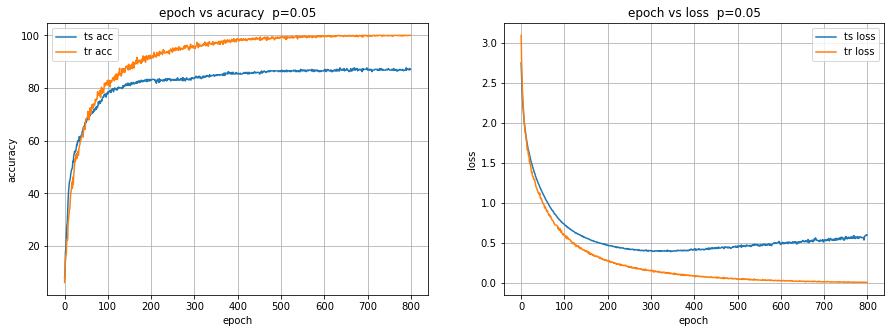

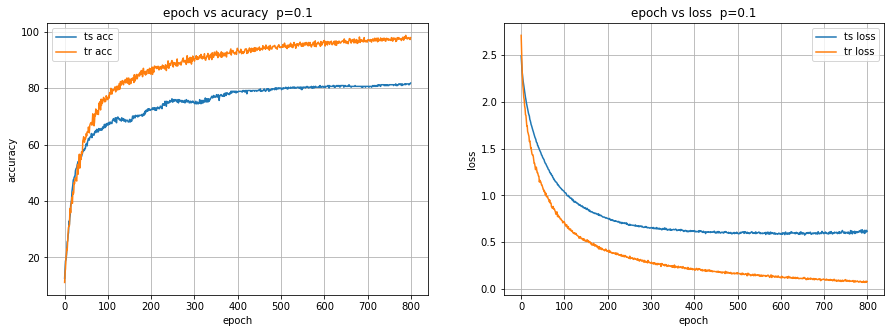

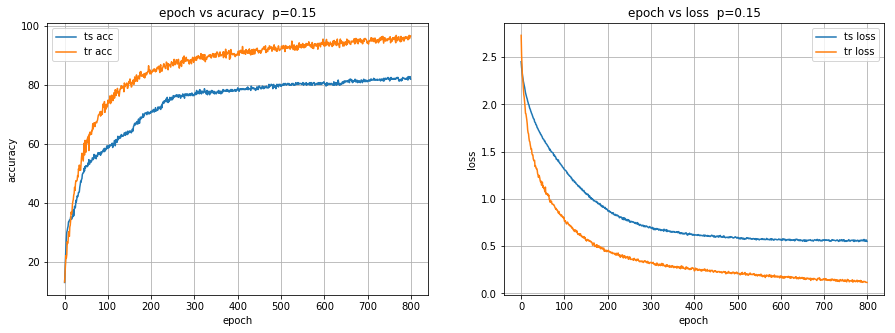

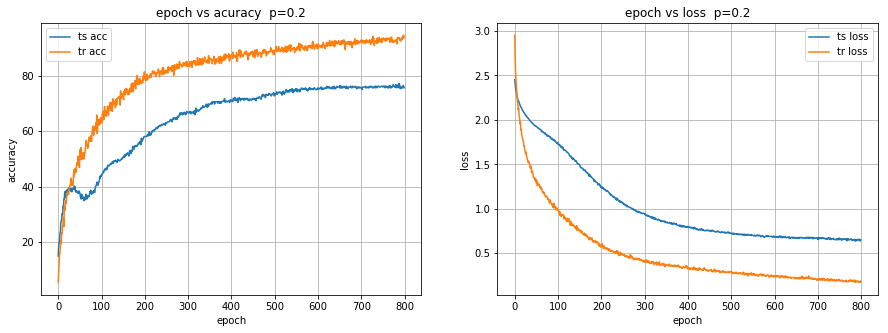

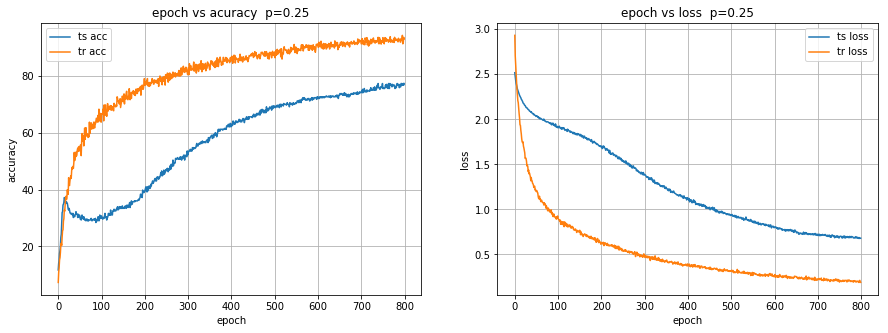

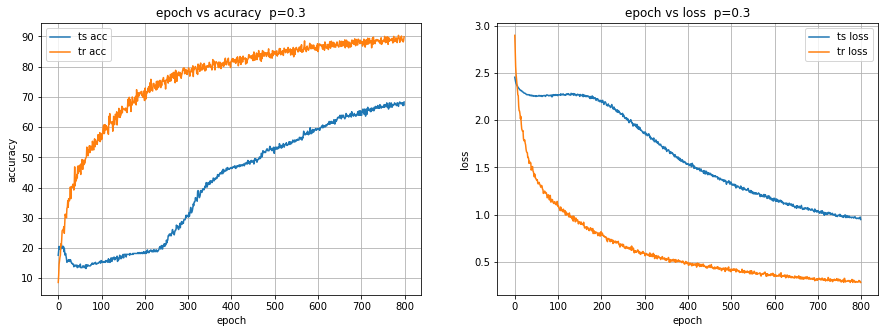

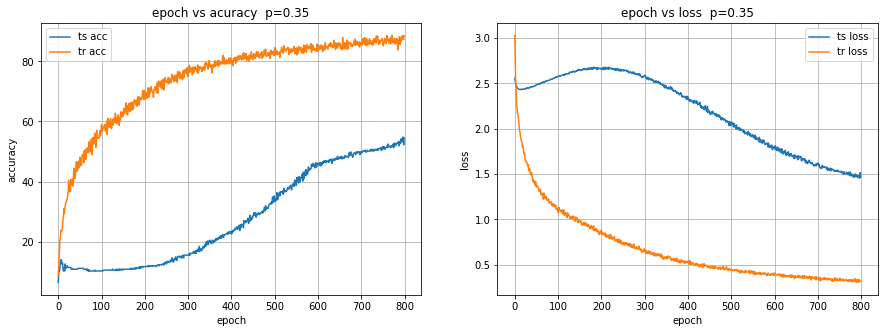

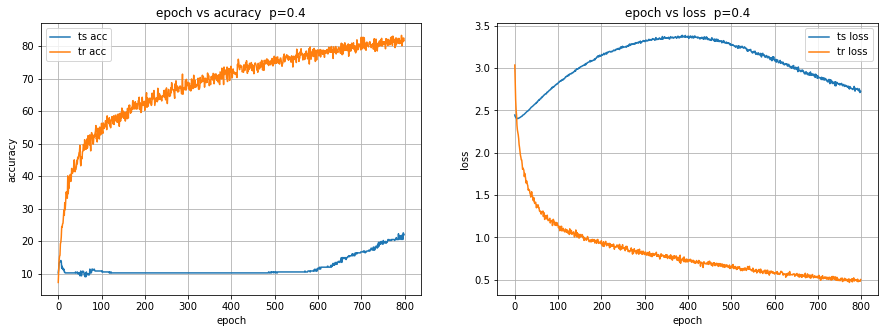

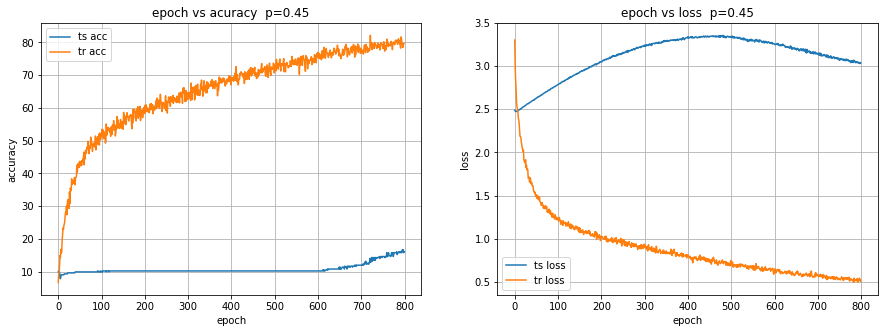

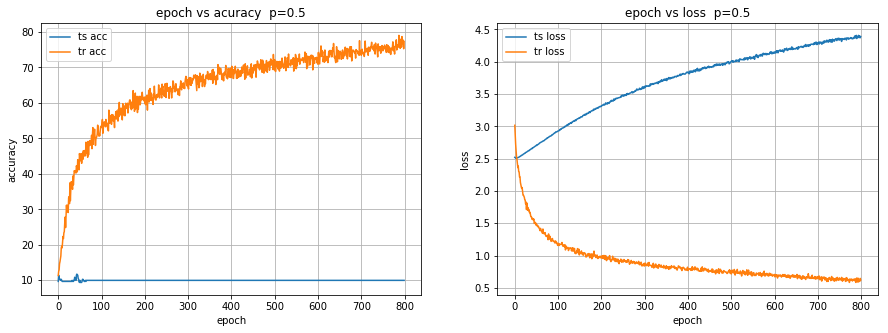

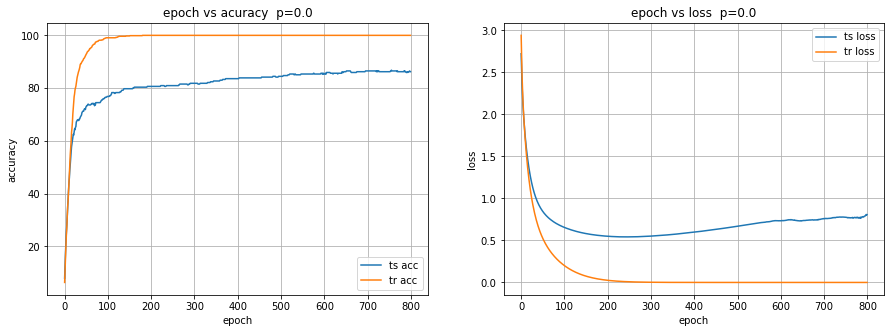

In [32]:
train = 0
test  = 1
acc   = 0
loss  = 1

x = np.linspace(0,epoch,epoch+1)
for i in range(len(drop_prob_list)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ts_a = test_file[i,:,test,acc]
    ts_l = test_file[i,:,test,loss]
    tr_a = test_file[i,:,train,acc]
    tr_l = test_file[i,:,train,loss]
    
    plt.plot(x,ts_a,label='ts acc')
    plt.plot(x,tr_a,label='tr acc')
    plt.title('epoch vs acuracy  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(x,ts_l,label='ts loss')
    plt.plot(x,tr_l,label='tr loss')
    plt.title('epoch vs loss  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    